# Model Training With Debiasing

## Importing libraries and assets

In [ ]:
# ref: https://github.com/Rak5hith-S/Visual_Question_Answering/blob/main/notebooks/2.%20Preprocessing%20and%20Model%20Training.ipynb

import collections
import contractions
import joblib
import json
import nltk
import random
import re
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub

from nltk.tokenize import word_tokenize
from tqdm.notebook import tqdm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sentence_transformers import SentenceTransformer
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing import image
import tensorflow.keras.backend as K
from tensorflow.keras.layers import (
    Embedding, LSTM, SpatialDropout1D, Input, concatenate, Dense, Multiply, 
    BatchNormalization, Dropout
)
from tensorflow.keras.callbacks import (
    LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
)
from tensorflow.keras.applications import xception
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

## Setup NLTK Tokenizers

In [8]:
nltk.data.path.append('./nltk_data')
nltk.download('punkt', download_dir='./nltk_data')
nltk.download('punkt_tab', download_dir='./nltk_data')

[nltk_data] Downloading package punkt to ./nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to ./nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

## Tensorflow Version and GPU Availability

In [9]:
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.16.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Data Preparation and Preprocessing 

### Loading and Filtering Dataset

- As it was done in the EDA the dataset is loaded and filtered out the samples whose answers belong to the top-100 most frequent one-word answers.

In [10]:
def load_vqa_data(annotations_path, questions_path):
    """
    Loads VQA dataset components: annotations and questions.

    Parameters:
        annotations_path (str): Path to the annotations JSON file.
        questions_path (str): Path to the questions JSON file.

    Returns:
        tuple: (annotations dictionary, questions dictionary)
    """

    # load annotations
    with open(annotations_path, 'r') as f:
        annotations = json.load(f)

    # load questions
    with open(questions_path, 'r') as f:
        questions = json.load(f)

    return annotations, questions

def process_vqa_data(questions, answers, img_dir):
    """
    Converts VQA JSON annotations into a structured DataFrame.

    Parameters:
        questions (dict): JSON object containing the questions.
        answers (dict): JSON object containing the annotations (answers).
        img_dir (str): Directory containing the images.

    Returns:
        pd.DataFrame: Processed DataFrame with image paths, questions, and answers.
    """

    # convert JSON data to DataFrames
    questions_df = pd.DataFrame.from_records(questions['questions'])
    answers_df = pd.DataFrame.from_records(answers['annotations'])

    # merge the DataFrames on 'image_id' and 'question_id'
    df = pd.merge(questions_df, answers_df, how='left', on=['image_id', 'question_id'])

    # extract a list of 10 answers per question
    df['answers'] = [[ans['answer'] for ans in ans_list] for ans_list in df['answers']]

    # construct image file paths based on 'image_id'
    df['image_path'] = "COCO_" + answers['data_subtype'] + "_" + df['image_id'].astype(str).str.zfill(12) + ".jpg"
    df['image_path'] = os.path.join(img_dir, '') + df['image_path']

    # reorder columns: Move 'image_path' to the first position
    df = df[['image_path'] + list(df.columns[:-1])]

    # drop unwanted columns
    df.drop(['image_id', 'question_id'], axis=1, inplace=True)

    return df

def filter_one_word_answers(df, top_n=100):
    """
    Filters the dataset to include only samples with one-word answers 
    and keeps only the top N most frequent one-word answers.

    Parameters:
        df (pd.DataFrame): The training dataset containing a 'multiple_choice_answer' column.
        top_n (int): The number of most frequent one-word answers to retain.

    Returns:
        pd.DataFrame: The filtered dataset.
    """

    # count words in each answer
    ans_word_count = df['multiple_choice_answer'].apply(lambda x: len(word_tokenize(x)))

    # filter for one-word answers
    df = df[ans_word_count == 1]

    # compute frequency of one-word answers
    one_word_ans_freq = df['multiple_choice_answer'].value_counts()

    # print total unique one-word answers
    print("Total number of unique one-word answers:", one_word_ans_freq.keys().nunique())

    # select the top N most frequent one-word answers
    top_answers = one_word_ans_freq.nlargest(top_n).index

    # filter the dataset for answers in the top N
    df = df[df['multiple_choice_answer'].isin(top_answers)]

    # print final dataset shape
    print(f"Filtered DataFrame shape: {df.shape}")

    return df

In [12]:
img_dir = "Datasets/VQAv2/InputImages/training-images/train2014"
answers, questions = load_vqa_data('Datasets/VQAv2/Annotations/TrainingAnnotations/v2_Annotations_Train_mscoco/v2_mscoco_train2014_annotations.json', 
                                           'Datasets/VQAv2/InputQuestions/TrainingQuestions/v2_Questions_Train_mscoco/v2_OpenEnded_mscoco_train2014_questions.json')

In [13]:
print("Dataset\n")
print("Total number of images: ", len(os.listdir(img_dir)))
print("Total number of questions: ", len(questions['questions']))
print("Total number of answer annotations: ", len(answers['annotations']))
print("Total number of answers(not unique) given for a question: ",
      len(answers['annotations'][0]['answers']))

Dataset

Total number of images:  82783
Total number of questions:  443757
Total number of answer annotations:  443757
Total number of answers(not unique) given for a question:  10


In [14]:
data_df = process_vqa_data(questions, answers, img_dir)

In [15]:
data_df.head()

,image_path,question,question_type,multiple_choice_answer,answers,answer_type
0,../../Datasets/VQAv2/InputImages/training-imag...,What is this photo taken looking through?,what is this,net,"[net, net, net, netting, net, net, mesh, net, ...",other
1,../../Datasets/VQAv2/InputImages/training-imag...,What position is this man playing?,what,pitcher,"[pitcher, catcher, pitcher, pitcher, pitcher, ...",other
2,../../Datasets/VQAv2/InputImages/training-imag...,What color is the players shirt?,what color is the,orange,"[orange, orange, orange, orange, orange, orang...",other
3,../../Datasets/VQAv2/InputImages/training-imag...,Is this man a professional baseball player?,is this,yes,"[yes, yes, yes, yes, yes, no, yes, yes, yes, yes]",yes/no
4,../../Datasets/VQAv2/InputImages/training-imag...,What color is the snow?,what color is the,white,"[white, white, white, white, white, white, whi...",other


In [16]:
data_df = filter_one_word_answers(data_df, top_n=100)

Total number of unique one-word answers: 10223
Filtered DataFrame shape: (307568, 6)


### Dataset Sampling

- The original dataset contains over 300,000 samples, which was too resource-intensive to process due to compute and memory constraints.

- To make training more manageable, the dataset was downsampled to 64,000 samples.

- The 64K subset was split into:

    - 51,200 samples for training (80%)

    - 12,800 samples for validation (20%)

- The 51,200 training samples were chosen specifically to allow for a batch size of 1,024, resulting in exactly 50 steps per epoch (51,200 / 1,024 = 50).

- Stratified sampling was used during selection to maintain the original distribution of answer_type categories in both training and validation sets.

In [17]:
data_df, _ = train_test_split(
    data_df,
    train_size=64000,
    stratify=data_df['answer_type'],
    random_state=30
)
data_df.shape


(64000, 6)

#### Distribution of answer_types in the Sampled Dataset

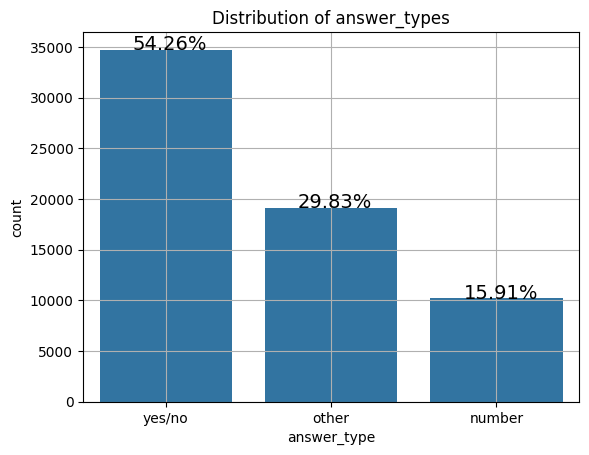

In [20]:
ax = sns.countplot(data=data_df, x='answer_type')

# Annotating
for p in ax.patches:
    ax.annotate(
        '{:.2f}%'.format( 
        (p.get_height()/len(data_df))*100), 
        (p.get_x()+0.2, p.get_height()),
        size=14
    )

plt.title("Distribution of answer_types")
plt.grid()
plt.show()

### Textual Data Cleaning (Questions)

- The released annotations have already undergone several preprocessing steps on the raw crowdsourced data, including:

    - Spelling correction applied to both questions and answers using Bing Speller.

    - Question normalization, which involves capitalizing the first character and ensuring the question ends with a question mark.

    - Answer normalization, which includes:

        - Converting all characters to lowercase.

        - Removing periods, except when used as decimal points.

        - Replacing number words with digits.

        - Removing articles such as "a," "an," and "the."
        
    - Adding apostrophes in cases where contractions were missing them (e.g., converting "dont" to "don't").


#### Further Cleaning and Contraction Handling

- In addition to the provided preprocessing, I further clean the questions by:

    - Expanding contractions using the Python contractions module (alternatives include pycontractions and others).

    - Converting text to lowercase.
    
    - Removing any special characters or non-alphanumeric symbols to standardize the text.

In [21]:
def clean_text(text):
    """
    Cleans the given text by expanding contractions, converting to lowercase, 
    and removing non-alphanumeric characters.

    Parameters:
        text (str): The input text to clean.

    Returns:
        str: The cleaned text.
    """
    text = contractions.fix(text)  # expand contractions
    text = text.lower()  # convert to lowercase
    text = re.sub(r'[^A-Za-z0-9]+', ' ', text)  # remove non-alphanumeric characters
    return text.strip()  # remove leading/trailing spaces

In [22]:
data_df['question'] = data_df['question'].apply(lambda x: clean_text(x))
data_df['question'].sample(10)

424490                    how many children in the picture
342535                    how many people are wearing blue
42899        what color is the lamp to the left of the man
10466                          do the shoes match the belt
153789    how many different beer brands are in the fridge
273849                                is the season summer
90359                   what material is the chair made of
414169                           is this an old volkswagen
345214                              what color is the roof
279313                          is this an electric toilet
Name: question, dtype: object

### Train-Val Splitting:

- A stratified split is applied to partition the data into 80% training and 20% validation sets, ensuring the class distribution remains consistent across both subsets.

In [23]:
train_df, val_df = train_test_split(
    data_df,
    train_size=0.8,
    stratify=data_df['answer_type'],
    random_state=30
)

print("Shape of train data: ", train_df.shape)
print("Shape of validation data: ", val_df.shape)

Shape of train data:  (51200, 6)
Shape of validation data:  (12800, 6)


In [24]:
# Saving the train data
train_df.to_csv('./train_df.csv', index=False)

# Saving the val data
val_df.to_csv('./val_df.csv', index=False)

In [25]:
# load the train data
train_df = pd.read_csv('./train_df.csv')

# load the val data
val_df = pd.read_csv('./val_df.csv')

#### Distribution of answer_types in Training and Validation Sets

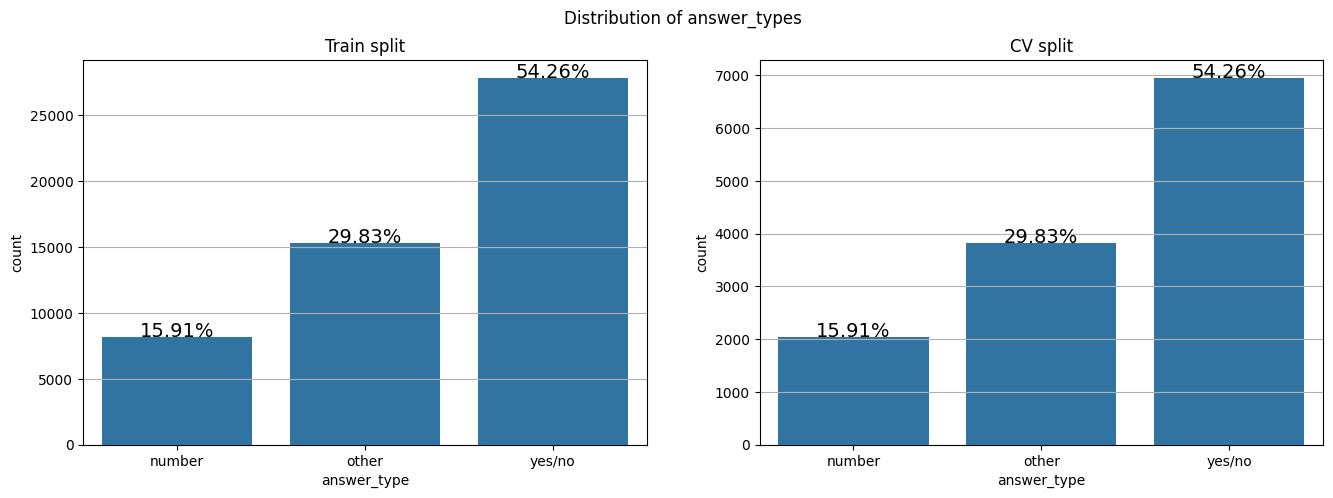

In [26]:
plt.figure(figsize=(16,5))

plt.subplot(1,2,1)
plt.grid()
plt.title("Train split")
ax = sns.countplot(data=train_df, x='answer_type', order=np.unique(train_df['answer_type']))

# Annotating
for p in ax.patches:
    ax.annotate(
        '{:.2f}%'.format( 
        (p.get_height()/len(train_df))*100), 
        (p.get_x()+0.2, p.get_height()),
        size=14
    )

plt.subplot(1,2,2)
plt.grid()
plt.title("CV split")
ax = sns.countplot(data=val_df, x='answer_type', order=np.unique(train_df['answer_type']))

# Annotating
for p in ax.patches:
    ax.annotate(
        '{:.2f}%'.format( 
        (p.get_height()/len(val_df))*100), 
        (p.get_x()+0.2, p.get_height()),
        size=14
    )

plt.suptitle("Distribution of answer_types")
plt.show()

### One-Hot Encode Answers

In [27]:
ohe=OneHotEncoder(sparse_output=False)
ohe.fit(train_df['multiple_choice_answer'].values.reshape(-1,1))

OneHotEncoder(sparse_output=False)

In [28]:
print("Number of answers: ", len(ohe.categories_[0]))
print("Answers: ", ohe.categories_)

Number of answers:  100
Answers:  [array(['0', '1', '10', '11', '12', '2', '20', '3', '4', '5', '6', '7',
       '8', '9', 'apple', 'banana', 'baseball', 'bathroom', 'beach',
       'bear', 'black', 'blue', 'brick', 'broccoli', 'brown', 'bus',
       'cake', 'camera', 'car', 'cat', 'clear', 'cow', 'dog', 'donut',
       'eating', 'elephant', 'female', 'flowers', 'food', 'frisbee',
       'giraffe', 'grass', 'gray', 'green', 'hat', 'horse', 'kitchen',
       'kite', 'laptop', 'left', 'male', 'man', 'many', 'metal',
       'motorcycle', 'no', 'none', 'nothing', 'orange', 'outside',
       'phone', 'pink', 'pizza', 'plane', 'purple', 'red', 'right',
       'sandwich', 'sheep', 'silver', 'sitting', 'skateboard',
       'skateboarding', 'skiing', 'snow', 'snowboarding', 'soccer',
       'standing', 'stop', 'summer', 'sunny', 'surfboard', 'surfing',
       'table', 'tan', 'tennis', 'tile', 'train', 'trees', 'umbrella',
       'walking', 'water', 'white', 'wii', 'wine', 'winter', 'woman',
   

In [29]:
# saving One-Hot Encoder
joblib.dump(ohe, "ohe.joblib")
ohe = joblib.load("ohe.joblib")

## Modeling

The Visual Question Answering (VQA) task is addressed through a multi-step modeling pipeline, which includes the following key components:

1. **Image Feature Extraction**  
   - Images are processed using a pre-trained **Xception** model.  
   - Features are extracted from the second-to-last layer, providing a compact, high-level representation of the visual content relevant for answering questions.

2. **Question Feature Encoding**  
   - Questions are encoded using **Sentence-BERT (SBERT)**, producing dense semantic embeddings that capture the meaning of each question.  
   - Additional text preprocessing is performed to clean and standardize the input before encoding.

3. **Joint Feature Fusion**  
   - Image and question features are combined through **element-wise (pointwise) multiplication**.  
   - This fusion technique creates a joint representation that integrates both modalities, enabling the model to reason over combined visual and textual information.

5. **Answer Prediction**  
   - The joint feature representation is passed through fully connected layers with **batch normalization** and **dropout** for regularization.  
   - The model outputs a probability distribution over the top **100** most frequent one-word answers using a **softmax** classifier.

### Answer Weighting and Custom Loss Function

#### Answer Weights Calculation

- Computes weights inversely proportional to answer frequencies.

- Answers that appear less frequently in the training dataset get higher weights, reducing prediction bias toward frequent answers.

In [ ]:
# Count the frequency of each answer in the training data
answer_counts = train_df['multiple_choice_answer'].value_counts()

# Aligns counts with the one-hot encoder category list.
answer_counts_aligned = answer_counts.reindex(ohe.categories_[0])
answer_counts_aligned.fillna(0, inplace=True)

# Computes the inverse frequency weight for each answer
total_answers = np.sum(answer_counts_aligned)
answer_weights = total_answers / (len(answer_counts_aligned) * answer_counts_aligned)

answer_weights_tensor = tf.constant(answer_weights.values, dtype=tf.float32)

print("Answer weights (first 10):", answer_weights_tensor.numpy()[:10])


Answer weights (first 10): [0.63602483 0.24878523 3.3032258  9.481482   5.688889   0.2549801
 6.826667   0.44716159 0.742029   1.2047058 ]


2025-03-28 17:19:24.967432: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-28 17:19:24.967541: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-28 17:19:24.967559: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-28 17:19:25.245136: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-28 17:19:25.245192: I external/local_xla/xla/stream_executor

#### Custom Weighted Categorical Crossentropy Loss

- This loss function applies the computed class weights during training.

In [31]:
def weighted_categorical_crossentropy(y_true, y_pred):
    """
    Applies class weights to the categorical crossentropy loss.
    """
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    
    # Compute per-sample weights
    weights = tf.reduce_sum(answer_weights_tensor * y_true, axis=-1)
    
    # Compute standard categorical crossentropy
    unweighted_loss = K.categorical_crossentropy(y_true, y_pred)
    
    # Multiply by weights
    weighted_loss = unweighted_loss * weights
    
    return weighted_loss

### Callbacks for Model Training

- These callbacks are used to monitor and control the training process, adjusting learning rates, handling early stopping, and ensuring stability during training.

#### Learning Rate Scheduling

- Reduces the learning rate by a fixed decay rate after each epoch.

In [32]:
def exp_decay(epoch, lr):
    """
    Applies exponential decay to the learning rate.

    This function reduces the learning rate by a fixed decay rate 
    after each epoch to allow the optimizer to make finer updates 
    as training progresses.

    Args:
        epoch (int): The current training epoch.
        lr (float): The current learning rate.

    Returns:
        float: The updated learning rate after applying decay.
    """
    decay_rate = 0.96  # Reduce LR by 4% per epoch
    return lr * decay_rate

lrschedule = LearningRateScheduler(exp_decay, verbose=1)


#### Reduce Learning Rate on Plateau

- Lowers the learning rate when validation accuracy stops improving.

In [33]:
reduce_lr_on_acc = ReduceLROnPlateau(factor=0.9, monitor='val_accuracy', patience=1, verbose=1, mode='max') 

#### Custom Callback to Terminate on NaN or Infinite Loss

- Monitors training for unstable behavior such as NaN or infinite loss/weights.

In [34]:
class TerminateNaN(tf.keras.callbacks.Callback):
    """
    Custom Keras callback to terminate model training when NaN or infinite values 
    are detected in the loss or model weights.

    This callback ensures training stability by:
    - Monitoring the loss at the end of each epoch.
    - Monitoring model weights after each epoch.
    - Automatically stopping training when an invalid value (NaN or infinity) is found.

    Useful in preventing wasted compute resources when training becomes unstable.

    Parameters
    ----------
    None

    Methods
    -------
    on_epoch_end(epoch, logs=None)
        Checks the training loss and model weights for NaN or infinite values
        at the end of each epoch and stops training if any are found.
    """
        
    def on_epoch_end(self, epoch, logs={}):
        """
        Checks loss and model weights for NaN or infinity at the end of each epoch.
        Stops training if invalid values are found.
        """
        loss = logs.get('loss')
        if loss is not None:
            if np.isnan(loss) or np.isinf(loss):
                print("Invalid loss and terminated at epoch {}".format(epoch))
                self.model.stop_training = True

        weights= self.model.get_weights()
        for i in weights:
            if np.isnan(np.sum(i)):
                print("Invalid weights and terminated at epoch {}".format(epoch))
                self.model.stop_training = True

terminate_nan = TerminateNaN()

#### Early Stopping

- Stops training early if validation accuracy doesn't improve over a specified number of epochs.

In [35]:
earlystop = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, mode='max', restore_best_weights=True)

### SBERT-Based Question Encoding

- Generates semantic embeddings of the input questions using a pre-trained Sentence-BERT (SBERT) model. These embeddings are dense vector representations that capture the meaning of the question, making them suitable for integration with image features in the VQA model.

In [36]:
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

def encode_questions_sbert(sbert_model, text):
    """
    Encodes a question into a dense vector representation using Sentence-BERT (SBERT).

    Cleans the input text and converts it into a semantic embedding 
    suitable for input into the VQA model.

    Args:
        sbert_model (SentenceTransformer): Pre-trained SBERT model used for encoding.
        text (str): Raw question text.

    Returns:
        numpy.ndarray: SBERT embedding of the input question, 
                       typically of shape (1, embedding_dim).
    """
    text = clean_text(text)  # still clean text
    sbert_embedding = sbert_model.encode([text])  # returns a (1, 384/768/1024) embedding depending on the model
    return sbert_embedding


### Image Feature Extraction and Encoding (Using Xception)

#### Preprocessing Images

- The input images are resized to a target size of (299, 299), which matches the required input dimensions for the Xception model (tf.keras.applications.xception.Xception).

- This preprocessing step scales the pixel values to the range [-1, 1], which is the expected input format for the Xception model.

- Unlike some other models (e.g., ResNet), Xception does not convert images from RGB to BGR or apply mean subtraction relative to ImageNet statistics. Instead, it normalizes pixel values to center them around zero by scaling.

In [37]:
IMG_TARGET_SIZE = (299, 299)

In [38]:
def preprocess_image_for_xception(img_path, target_size):
    """
    Loads and preprocesses an image for input into the Xception model.

    Args:
        img_path (str): Path to the image file.
        target_size (tuple): The desired size for the input image.

    Returns:
        numpy.ndarray: Preprocessed image array, ready for feature extraction.
    """
    img = image.load_img(img_path, target_size=target_size)
    img_arr = image.img_to_array(img)
    # Xception's preprocess_input scales pixels to the range [-1, 1]
    img_arr = xception.preprocess_input(img_arr)
    return img_arr

#### Xception Model to Featurize Images

- A pre-trained Xception model is loaded using tf.keras.applications.xception.Xception, with ImageNet weights and an input shape of (299, 299, 3) to match the required image dimensions.

- The model’s layers are frozen (trainable = False) to prevent them from being updated during training, ensuring that the extracted features remain consistent and leverage the knowledge learned from ImageNet.

- A separate feature extractor model, xception_featurizer, is created by specifying the inputs of the original Xception model and the outputs of its second-to-last layer.

- This layer provides a 2048-dimensional feature vector that serves as a compact and informative embedding of the input image.
The feature extractor model (xception_featurizer) is also frozen to avoid unintentional updates.

In [39]:
xception_model = xception.Xception(
    weights='imagenet',
    input_shape=IMG_TARGET_SIZE + (3,)
)
xception_model.trainable = False

# Create a model that outputs activations from Xception's second-to-last layer
xception_featurizer = Model(
    inputs=xception_model.inputs, 
    outputs=xception_model.layers[-2].output
)
xception_featurizer.trainable = False

# (Optional) View the model summary
xception_featurizer.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 149, 149, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 149, 149, 32)         0         ['block1_conv1_bn[0][0]'] 

#### Encoding Images Using the Xception Featurizer

- Generates a 2048-dimensional feature vector for a given image using the pre-trained Xception feature extractor.

In [40]:
def encode_image_with_xception(xception_featurizer, img_path, target_size):
    """
    Encodes an image into a feature vector using a pre-trained Xception model.
    
    Args:
        xception_featurizer (tf.keras.Model): Feature extractor model.
        img_path (str): Path to the image file.
        target_size (tuple): Target size for image preprocessing.

    Returns:
        numpy.ndarray: Encoded feature vector representing the input image.
    """
    # Preprocess the image using the updated function
    img_arr = preprocess_image_for_xception(img_path, target_size)
    # Expand dimensions and pass through the featurizer
    xception_feats = xception_featurizer(np.expand_dims(img_arr, axis=0))
    return xception_feats


### DataLoaders for Model Training and Validation

- CustomDatasetModel handles the retrieval and preprocessing of individual question-image-answer samples, including SBERT question encoding, Xception image feature extraction, and one-hot answer encoding.

- CustomDataLoader batches these preprocessed samples, manages data shuffling, and feeds them efficiently to the model during training and validation using TensorFlow's Sequence interface.

In [41]:
class CustomDatasetModel:
    """
    Custom Dataset Model for Multimodal Visual Question Answering (VQA).

    This dataset processes each sample by:
    - Encoding natural language questions into dense embeddings using Sentence-BERT (SBERT).
    - Extracting image features from preprocessed images using the pre-trained Xception model.
    - One-hot encoding the answers for classification.

    Suitable for multimodal learning tasks combining image and text features.

    Parameters
    ----------
    data : pandas.DataFrame
        DataFrame containing the dataset with columns: 'question', 'image_path', and 'multiple_choice_answer'.
    sbert_model : SentenceTransformer
        Pre-trained SBERT model for encoding the questions.
    xception_featurizer : tf.keras.Model
        Pre-trained Xception model providing image feature vectors.
    img_target_size : tuple of int
        Desired size for the image input (height, width).
    ohe : sklearn.preprocessing.OneHotEncoder
        One-hot encoder fitted on the answer categories.

    Methods
    -------
    __getitem__(index)
        Returns a tuple of (question_embedding, image_features, one_hot_encoded_answer).
    
    __len__()
        Returns the total number of samples in the dataset.
    """

    def __init__(self, data, sbert_model, xception_featurizer, img_target_size, ohe):
        self.length = len(data)
        self.questions = data['question'].values
        self.images = data['image_path'].values
        self.answers = data['multiple_choice_answer'].values
        
        self.sbert_model = sbert_model
        self.xception_featurizer = xception_featurizer
        self.img_target_size = img_target_size
        self.ohe = ohe
 
    def __getitem__(self, index):
        """
        Retrieves and encodes a single sample.
        """
        # Encode question with SBERT
        encoded_question = encode_questions_sbert(self.sbert_model, self.questions[index])[0]

        # Extract image features with Xception
        encoded_image = encode_image_with_xception(
            self.xception_featurizer,
            self.images[index],
            self.img_target_size
        )[0]

        # One-hot encode answer
        encoded_answer = self.ohe.transform(np.asarray([[self.answers[index]]]))[0]

        return encoded_question, encoded_image, encoded_answer
 
    def __len__(self):
        """
        Returns the number of samples.
        """
        return self.length

In [42]:
#https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence  
class CustomDataLoader(tf.keras.utils.Sequence):
    """
    Custom DataLoader for batching multimodal data in Visual Question Answering (VQA).

    This DataLoader works with `CustomDatasetModel` (or similar datasets) that return
    pre-processed question embeddings, image features, and one-hot encoded answers.

    It creates batches of data, shuffles them if specified, and works seamlessly with
    `tf.keras` training loops such as `model.fit()`.

    Parameters
    ----------
    dataset : CustomDatasetModel
        The dataset instance that provides individual samples of question embeddings,
        image features, and answers.
    batch_size : int, optional (default=1)
        Number of samples per batch.
    shuffle : bool, optional (default=True)
        Whether to shuffle the dataset at the beginning of training.
    shuffle_every_epoch : bool, optional (default=False)
        Whether to reshuffle the dataset at the end of every epoch.

    Methods
    -------
    __getitem__(index)
        Retrieves and returns a batch of data at the specified index.
        
    __len__()
        Returns the total number of batches per epoch.
        
    on_epoch_end()
        Shuffles the dataset at the end of each epoch if `shuffle_every_epoch` is True.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=True, shuffle_every_epoch=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.shuffle_every_epoch = shuffle_every_epoch
        self.indexes = np.arange(len(dataset))
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)
 
    def __getitem__(self, index):
        """
        Returns a single batch of data.
        """
        start = index * self.batch_size
        stop = (index + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[self.indexes[j]])
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]

        return tuple([[batch[0],batch[1]],batch[2]])
    
    def __len__(self):
        """
        Returns the number of batches per epoch.
        """
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """
        Shuffles data after each epoch if shuffle_every_epoch is enabled.
        """
        if self.shuffle_every_epoch:
            self.indexes = np.random.permutation(self.indexes)

In [43]:
# creating train and validation dataset
train_dataset = CustomDatasetModel(
    train_df, sbert_model, xception_featurizer, IMG_TARGET_SIZE, ohe
)

val_dataset = CustomDatasetModel(
    val_df, sbert_model, xception_featurizer, IMG_TARGET_SIZE, ohe
)

BATCH_SIZE = 1024

# creating data loaders
train_dataloader = CustomDataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle_every_epoch=True)
val_dataloader = CustomDataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle_every_epoch=True)


In [44]:
features, answers = train_dataloader[0]
question_features, image_features = features

print("Batch shape of question features:", question_features.shape)
print("Batch shape of image features:", image_features.shape)
print("Batch shape of one-hot encoded answers:", answers.shape)

2025-03-28 17:20:03.154655: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.
2025-03-28 17:20:03.170967: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906


Batch shape of question features: (1024, 384)
Batch shape of image features: (1024, 2048)
Batch shape of one-hot encoded answers: (1024, 100)


## Model Training

### TensorBoard Callback

- TensorBoard callback to visualize logs during training

In [45]:
log_dir="./model_logs"
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, write_grads=True, write_images=True)
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir, 
    histogram_freq=1
)

### ModelCheckpoint Callback

- Model checkpoint to save the best model based on validation accuracy

In [46]:
checkpoint = ModelCheckpoint(
    filepath="./best_model.keras", 
    monitor='val_accuracy',  
    verbose=1, 
    save_best_only=True, 
    mode='max'
)

In [38]:
# Clear any logs from previous runs
!rm -rf './model_logs/'

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
# ========================================================
#                  MODEL INPUTS AND FEATURE ENCODING
# ========================================================

# Question Feature Encoding
ques_input = Input(shape=(384, ), name='sbert_embedding')
print("Question Input Shape:", ques_input.get_shape())

ques_features = Dense(
    512, 
    activation='relu', 
    name='ques_dense', 
    kernel_initializer=tf.keras.initializers.he_normal(seed=33)
)(ques_input)
print("Question Features Shape:", ques_features.get_shape()) 

# Image Feature Encoding
img_input = Input(shape=(2048,), name='xception_activations')
print("Image Input Shape:", img_input.get_shape())

# Normalize image feature vectors
l2_normed_resnet_features = tf.math.l2_normalize(
    img_input, axis=1, epsilon=1e-12, name='l2_norm'
)
print("L2 Normalized Image Features Shape:", l2_normed_resnet_features.get_shape())

# Dense layers on image features
img_dense_1 = Dense(
    1024, 
    activation='relu', 
    name='img_dense_1',
    kernel_initializer=tf.keras.initializers.he_normal(seed=36),
)(l2_normed_resnet_features)
print("Image Dense Layer 1 Shape:", img_dense_1.get_shape())

img_features = Dense(
    512, 
    activation='relu', 
    name='img_dense_2', 
    kernel_initializer=tf.keras.initializers.he_normal(seed=39)
)(img_dense_1)
print("Image Dense Layer 2 Shape:", img_features.get_shape())

# ========================================================
#                  MULTIMODAL FUSION AND OUTPUT
# ========================================================

# Combine question and image features through pointwise multiplication
joint_feat_rep = Multiply(name='pointwise-multiplication')([ques_features, img_features])
print("Joint Feature Representation Shape:", joint_feat_rep.get_shape())

# Apply batch normalization and dropout for regularization
batch_norm_1 = BatchNormalization(name='batch_norm_1')(joint_feat_rep)
drop_out_1 = Dropout(0.2, name='dropout_1')(batch_norm_1)

# Additional dense layer for learning joint representations
d1=Dense(
    256, 
    activation='relu', 
    name='dense_1', 
    kernel_initializer=tf.keras.initializers.he_normal(seed=30)
)(drop_out_1)

# Final softmax layer for answer classification
final_output = Dense(
    100, 
    activation='softmax', 
    name='softmax_classification', 
    kernel_initializer=tf.keras.initializers.glorot_uniform(seed=3)
)(d1)
print("Final Output Shape:", final_output.get_shape())

# ========================================================
#                  COMPILE THE MODEL
# ========================================================
model = Model(inputs=[ques_input, img_input], outputs=final_output)
print(model.summary())

model.compile(
    loss=weighted_categorical_crossentropy,
    optimizer=AdamW(learning_rate=0.002, weight_decay=1e-5),
    metrics=['accuracy']
)

# ========================================================
#                  MODEL TRAINING
# ========================================================
history = model.fit(
    train_dataloader, 
    steps_per_epoch=50,
    epochs=20,  
    validation_data=val_dataloader, 
    validation_steps=12,
    callbacks=[lrschedule, terminate_nan, earlystop, tensorboard_callback, checkpoint]
)

(None, 384)
(None, 512)
(None, 2048)
(None, 2048)
(None, 1024)
(None, 512)
(None, 512)
(None, 100)
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 xception_activations (Inpu  [(None, 2048)]               0         []                            
 tLayer)                                                                                          
                                                                                                  
 tf.math.l2_normalize_2 (TF  (None, 2048)                 0         ['xception_activations[0][0]']
 OpLambda)                                                                                        
                                                                                                  
 sbert_embedding (InputLaye  [(None, 384)]                0         []                      

I0000 00:00:1742113605.980853    2540 service.cc:145] XLA service 0x7efca86585f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742113605.980939    2540 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2025-03-16 08:26:45.996144: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1742113606.063406    2540 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


50/50 [==============================] - ETA: 0s - loss: 2.9969 - accuracy: 0.1839     
Epoch 1: val_accuracy improved from -inf to 0.35872, saving model to ./best_model.keras
50/50 [==============================] - 4702s 94s/step - loss: 2.9969 - accuracy: 0.1839 - val_loss: 3.6739 - val_accuracy: 0.3587 - lr: 0.0019

Epoch 2: LearningRateScheduler setting learning rate to 0.0018432000651955605.
Epoch 2/20
50/50 [==============================] - ETA: 0s - loss: 1.7058 - accuracy: 0.3730     
Epoch 2: val_accuracy did not improve from 0.35872
50/50 [==============================] - 4530s 91s/step - loss: 1.7058 - accuracy: 0.3730 - val_loss: 3.5143 - val_accuracy: 0.3584 - lr: 0.0018

Epoch 3: LearningRateScheduler setting learning rate to 0.001769472062587738.
Epoch 3/20
50/50 [==============================] - ETA: 0s - loss: 1.3293 - accuracy: 0.4145   
Epoch 3: val_accuracy improved from 0.35872 to 0.37419, saving model to ./best_model.keras
50/50 [==============================

## Model Evaluation

- Evaluates the model’s accuracy for each answer type (e.g., "yes/no", "number", "other").

In [48]:
model = load_model(
    './best_model.keras',
    custom_objects={'weighted_categorical_crossentropy': weighted_categorical_crossentropy}
)

In [46]:
loss, accuracy = model.evaluate(val_dataloader, verbose=0)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <gast.gast.Expr object at 0x7f8a8b07e200>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <gast.gast.Expr object at 0x7f8a8b07e200>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [47]:
print(f"Val Loss: {loss:.4f}")
print(f"Val Accuracy: {accuracy:.4f}")

Val Loss: 2.5612
Val Accuracy: 0.4589


In [57]:
y_preds, y_trues = [], []

for (x, y) in val_dataloader:
    pred = model.predict(x)
    y_preds.extend(np.argmax(pred, axis=1))
    y_trues.extend(np.argmax(y, axis=1))

32/32 [==============================] - 0s 2ms/step


### Confusion Matrix Top K Answers

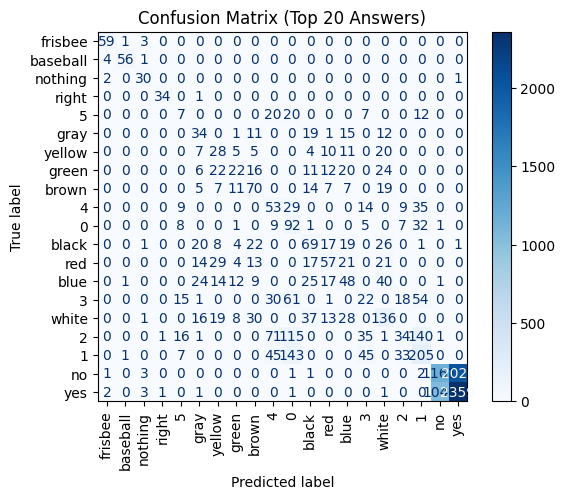

In [65]:
def plot_confusion_matrix(y_true, y_pred, ohe, top_k=20):
    cm = confusion_matrix(y_trues, y_preds)
    top_labels = np.argsort(cm.sum(axis=1))[-top_k:]
    cm_top = cm[top_labels][:, top_labels]
    labels = ohe.categories_[0][top_labels]

    disp = ConfusionMatrixDisplay(confusion_matrix=cm_top, display_labels=labels)
    disp.plot(xticks_rotation=90, cmap='Blues', values_format='d')
    plt.title(f'Confusion Matrix (Top {top_k} Answers)')
    plt.show()

plot_confusion_matrix(y_trues, y_preds, ohe, top_k=20)

### Class-wise Accuracy

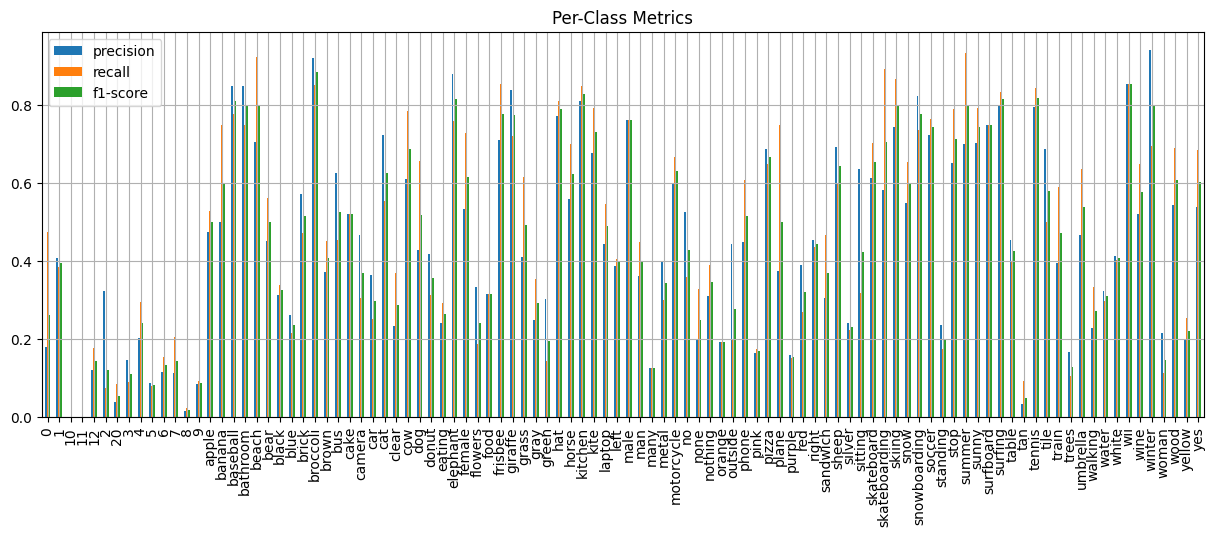

In [67]:
report = classification_report(y_trues, y_preds, target_names=ohe.categories_[0], output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report[['precision', 'recall', 'f1-score']].iloc[:-3].plot(kind='bar', figsize=(15, 5))
plt.title("Per-Class Metrics")
plt.grid()
plt.show()

### Image-Question-Answer Examples

1/1 [==============================] - 0s 21ms/step


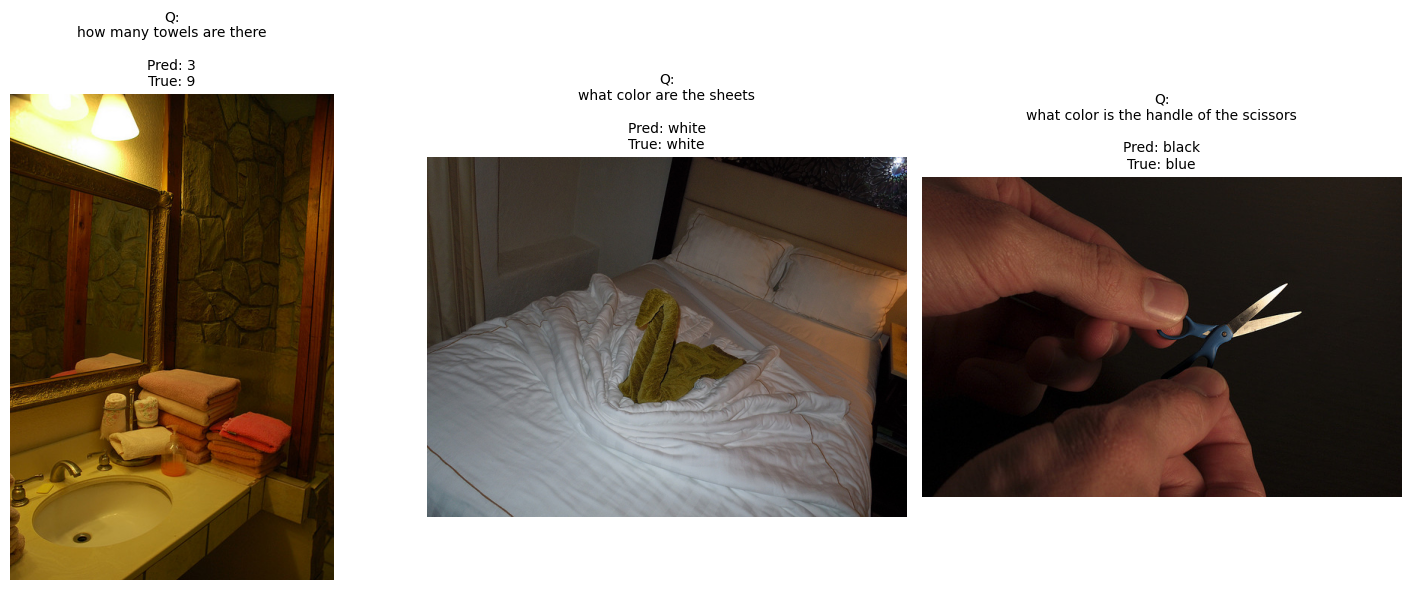

In [77]:
num_samples = 3

sample_idxs = random.sample(range(len(val_dataset)), num_samples)

fig, axes = plt.subplots(1, num_samples, figsize=(5 * num_samples, 6))

for i, idx in enumerate(sample_idxs):
    q_feat, img_feat, gt_ans = val_dataset[idx]
    pred = model.predict([[q_feat[np.newaxis, ...], img_feat[np.newaxis, ...]]])
    pred_label = ohe.categories_[0][np.argmax(pred)]
    true_label = val_dataset.answers[idx]

    img_path = val_dataset.images[idx]
    img = image.load_img(img_path)

    axes[i].imshow(img)
    axes[i].set_title(f"Q:\n{val_dataset.questions[idx]}\n\nPred: {pred_label}\nTrue: {true_label}", fontsize=10)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

### t-SNE Visualization

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


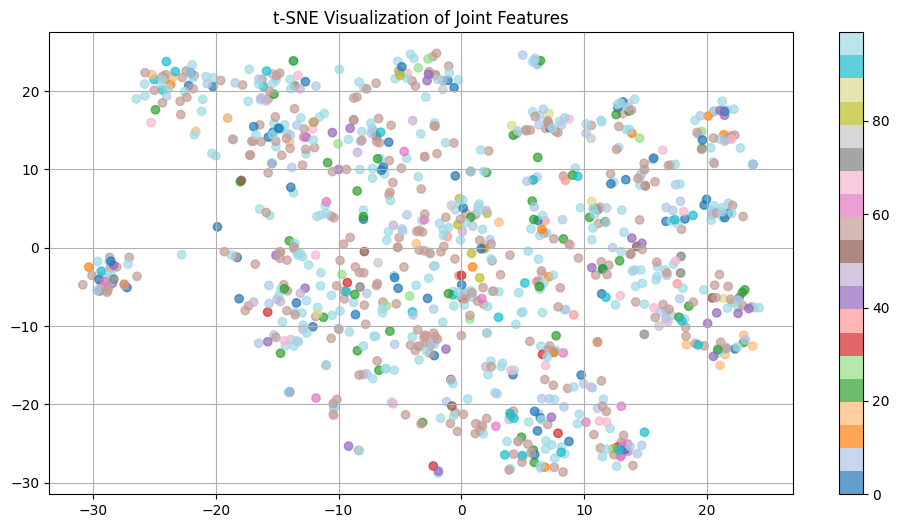

In [86]:
questions, images, labels = [], [], []
for i in range(1000):
    q, img, a = val_dataset[i]
    questions.append(q)
    images.append(img)
    labels.append(np.argmax(a))

joint_features = np.concatenate([questions, images], axis=1)
tsne = TSNE(n_components=2, perplexity=30, n_iter=500)
reduced = tsne.fit_transform(joint_features)

plt.figure(figsize=(12, 6))
scatter = plt.scatter(reduced[:,0], reduced[:,1], c=labels, cmap='tab20', alpha=0.7)
plt.colorbar(scatter)
plt.title('t-SNE Visualization of Joint Features')
plt.grid()
plt.show()

### Misclassified Examples Distribution

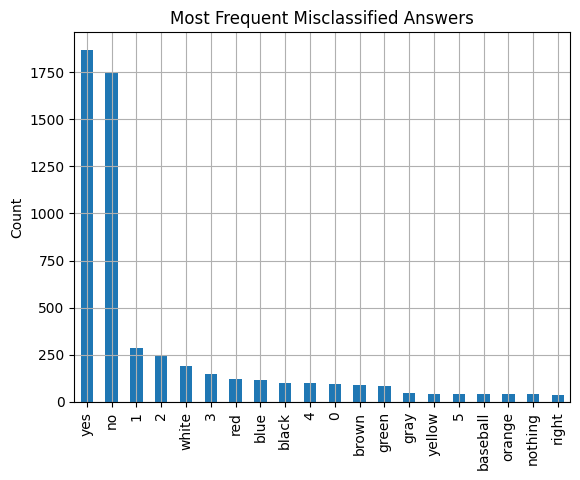

In [ ]:
incorrect = [val_dataset.answers[i] for i in range(len(y_trues)) if y_trues[i] != y_preds[i]]
err_counts = collections.Counter(incorrect)
pd.Series(err_counts).sort_values(ascending=False).head(20).plot(kind='bar')
plt.title("Most Frequent Misclassified Answers")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.grid()
plt.show()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <gast.gast.Expr object at 0x7feb6820caf0>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <gast.gast.Expr object at 0x7feb6820caf0>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


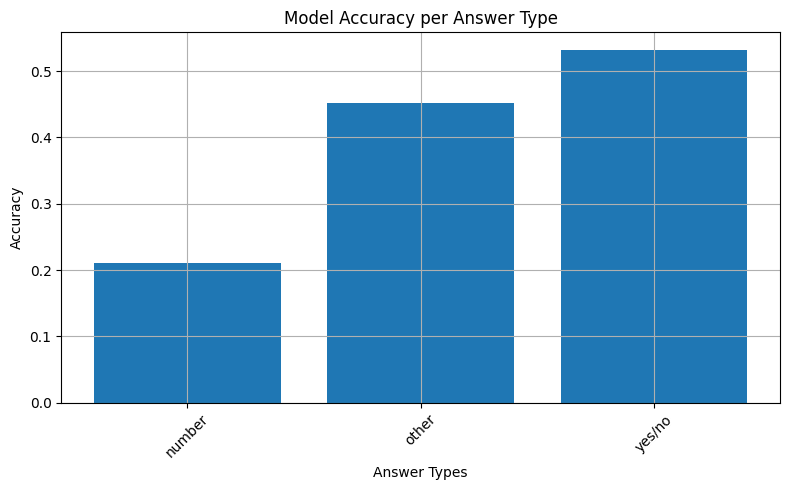

In [ ]:
model_acc = {}

for ans_type in np.unique(train_df['answer_type']):
    # Filter validation data for the specific answer type
    val_df_filtered = val_df[val_df['answer_type'] == ans_type]

    # Create the validation dataset for this answer type
    val_dataset_filtered = CustomDatasetModel(
        val_df_filtered, 
        sbert_model,
        xception_featurizer,
        IMG_TARGET_SIZE, 
        ohe
    )

    # create the dataloader for subset
    val_dataloader_filtered = CustomDataLoader(
        val_dataset_filtered, 
        batch_size=BATCH_SIZE, 
        shuffle_every_epoch=False
    )

    # Evaluate the model on this subset
    _, acc = model.evaluate(val_dataloader_filtered, verbose=0)

    # Store accuracy
    model_acc[ans_type] = acc

# Plot Accuracy per Answer Type
plt.figure(figsize=(8,5))

plt.grid()
plt.title("Model Accuracy per Answer Type")
ans_types = np.unique(train_df['answer_type'])

plt.xlabel("Answer Types")
plt.ylabel("Accuracy")

# collect accuracy values in order of answer types
acc_values = [model_acc[typ] for typ in ans_types]

plt.bar(ans_types, acc_values)

plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

## Evaluation Againt GQA-OOD

- Measures accuracy on ood_testdev_tail.json, ood_testdev_head.json, and ood_testdev_all.json.

- Prints out the accuracy numbers and detailed results.

In [ ]:
# Load testdev questions JSON
with open('Datasets/GQA/GQA-OOD/data/ood_testdev_all.json', 'r') as f:
    testdev_data = json.load(f)

# Convert to DataFrame for processing
records = []
for q_id, content in testdev_data.items():
    records.append({
        'question_id': q_id,
        'question': content['question'],
        'image_id': content['imageId']
    })

gqa_ood_testdev_df = pd.DataFrame(records)

# Construct image paths
img_dir = "Datasets/GQA/Images/images"

gqa_ood_testdev_df['image_path'] = gqa_ood_testdev_df['image_id'].apply(lambda x: os.path.join(img_dir, f"{x}.jpg"))

gqa_ood_testdev_df.head()

,question_id,question,image_id,image_path
0,201030415,What kind of furniture is brown?,n54424,../../Datasets/GQA-OOD/Images/images/n54424.jpg
1,201030459,What is the name of the piece of furniture tha...,n54424,../../Datasets/GQA-OOD/Images/images/n54424.jpg
2,201030460,What kind of furniture is in front of the wall?,n54424,../../Datasets/GQA-OOD/Images/images/n54424.jpg
3,201030469,Which kind of furniture is the wall behind of?,n54424,../../Datasets/GQA-OOD/Images/images/n54424.jpg
4,201030507,Does the shirt seem to be sleeveless or long s...,n54424,../../Datasets/GQA-OOD/Images/images/n54424.jpg


In [65]:
gqa_ood_testdev_df.shape

(2796, 4)

In [ ]:
from tqdm import tqdm

def produce_answer(X):
    """
    Produce the answer for a question asked about an image using Model-1.
    
    Parameters:
    -----------
    X: pandas.DataFrame
        DataFrame containing 'image_path' and 'question' columns. 
        It can have a single row or multiple rows.
    
    Returns:
    --------
    pred_df: pandas.DataFrame
        DataFrame containing 'image_path', 'question', and the predicted 'answer' by Model-1.
    """
    pred_df = X.copy()
    pred_ans = []

    for i in tqdm(range(len(X))):
        row = X.iloc[i]

        # encode the question using SBERT
        enc_question = encode_questions_sbert(sbert_model, row['question'])[0]

        # encode the image using Xception
        xception_features = encode_image_with_xception(
            xception_featurizer,
            row['image_path'],
            IMG_TARGET_SIZE
        )[0]

        # Generate answer prediction
        y_pred_val = model.predict([
            np.asarray([enc_question]), 
            np.asarray([xception_features])
        ])

        # convert prediction (one-hot output) back to the original answer
        y_pred_val_label = ohe.inverse_transform(
            tf.one_hot(
                tf.argmax(y_pred_val, axis=1), 
                depth=len(ohe.categories_[0])
            )
        )[0][0]

        pred_ans.append(y_pred_val_label)

    # Add predicted answers to the dataframe
    pred_df["pred_answer"] = pred_ans

    return pred_df

In [ ]:
predictions_df = produce_answer(gqa_ood_testdev_df)

predictions_df[['question_id', 'pred_answer']].head()



         | 0/2796 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step




         | 1/2796 [00:00<10:49,  4.30it/s]

1/1 [==============================] - 0s 13ms/step




         | 2/2796 [00:00<07:47,  5.97it/s]

1/1 [==============================] - 0s 15ms/step




         | 3/2796 [00:00<06:32,  7.11it/s]

1/1 [==============================] - 0s 13ms/step




         | 4/2796 [00:00<06:03,  7.67it/s]

1/1 [==============================] - 0s 16ms/step




         | 5/2796 [00:00<05:52,  7.92it/s]

1/1 [==============================] - 0s 14ms/step




         | 6/2796 [00:00<05:41,  8.18it/s]

1/1 [==============================] - 0s 14ms/step




         | 7/2796 [00:00<05:34,  8.35it/s]

1/1 [==============================] - 0s 14ms/step




         | 8/2796 [00:01<05:31,  8.42it/s]

1/1 [==============================] - 0s 14ms/step




         | 9/2796 [00:01<05:22,  8.65it/s]

1/1 [==============================] - 0s 13ms/step




         | 10/2796 [00:01<05:13,  8.90it/s]

1/1 [==============================] - 0s 13ms/step




         | 11/2796 [00:01<05:05,  9.10it/s]

1/1 [==============================] - 0s 15ms/step




         | 12/2796 [00:01<05:02,  9.22it/s]

1/1 [==============================] - 0s 13ms/step




         | 13/2796 [00:01<05:03,  9.18it/s]

1/1 [==============================] - 0s 14ms/step




         | 14/2796 [00:01<05:01,  9.22it/s]

1/1 [==============================] - 0s 14ms/step




         | 15/2796 [00:01<05:03,  9.15it/s]

1/1 [==============================] - 0s 14ms/step




         | 16/2796 [00:01<05:17,  8.76it/s]

1/1 [==============================] - 0s 14ms/step




         | 17/2796 [00:02<05:14,  8.83it/s]

1/1 [==============================] - 0s 14ms/step




         | 18/2796 [00:02<05:10,  8.94it/s]

1/1 [==============================] - 0s 14ms/step




         | 19/2796 [00:02<05:12,  8.89it/s]

1/1 [==============================] - 0s 14ms/step




         | 20/2796 [00:02<05:07,  9.04it/s]

1/1 [==============================] - 0s 16ms/step




         | 21/2796 [00:02<05:15,  8.80it/s]

1/1 [==============================] - 0s 14ms/step




         | 22/2796 [00:02<05:16,  8.77it/s]

1/1 [==============================] - 0s 13ms/step




         | 23/2796 [00:02<05:11,  8.91it/s]

1/1 [==============================] - 0s 14ms/step




         | 24/2796 [00:02<05:15,  8.78it/s]

1/1 [==============================] - 0s 14ms/step




         | 25/2796 [00:02<05:14,  8.80it/s]

1/1 [==============================] - 0s 14ms/step




         | 26/2796 [00:03<05:08,  8.97it/s]

1/1 [==============================] - 0s 13ms/step




         | 27/2796 [00:03<05:09,  8.94it/s]

1/1 [==============================] - 0s 14ms/step




         | 28/2796 [00:03<05:06,  9.02it/s]

1/1 [==============================] - 0s 15ms/step




         | 29/2796 [00:03<05:09,  8.94it/s]

1/1 [==============================] - 0s 14ms/step




         | 30/2796 [00:03<05:11,  8.87it/s]

1/1 [==============================] - 0s 14ms/step




         | 31/2796 [00:03<05:09,  8.93it/s]

1/1 [==============================] - 0s 15ms/step




         | 32/2796 [00:03<05:30,  8.37it/s]

1/1 [==============================] - 0s 15ms/step




         | 33/2796 [00:03<05:23,  8.54it/s]

1/1 [==============================] - 0s 15ms/step




         | 34/2796 [00:03<05:34,  8.27it/s]

1/1 [==============================] - 0s 15ms/step




         | 35/2796 [00:04<05:39,  8.13it/s]

1/1 [==============================] - 0s 14ms/step




         | 36/2796 [00:04<05:32,  8.30it/s]

1/1 [==============================] - 0s 15ms/step




         | 37/2796 [00:04<05:28,  8.40it/s]

1/1 [==============================] - 0s 16ms/step




         | 38/2796 [00:04<05:26,  8.46it/s]

1/1 [==============================] - 0s 16ms/step




         | 39/2796 [00:04<05:26,  8.44it/s]

1/1 [==============================] - 0s 16ms/step




         | 40/2796 [00:04<05:40,  8.09it/s]

1/1 [==============================] - 0s 16ms/step




         | 41/2796 [00:04<05:58,  7.68it/s]

1/1 [==============================] - 0s 16ms/step




         | 42/2796 [00:04<06:00,  7.64it/s]

1/1 [==============================] - 0s 15ms/step




         | 43/2796 [00:05<05:56,  7.73it/s]

1/1 [==============================] - 0s 15ms/step




         | 44/2796 [00:05<05:53,  7.79it/s]

1/1 [==============================] - 0s 15ms/step




         | 45/2796 [00:05<05:48,  7.89it/s]

1/1 [==============================] - 0s 16ms/step




         | 46/2796 [00:05<06:00,  7.62it/s]

1/1 [==============================] - 0s 15ms/step




         | 47/2796 [00:05<05:48,  7.88it/s]

1/1 [==============================] - 0s 15ms/step




         | 48/2796 [00:05<05:51,  7.82it/s]

1/1 [==============================] - 0s 15ms/step




         | 49/2796 [00:05<05:43,  8.00it/s]

1/1 [==============================] - 0s 14ms/step




         | 50/2796 [00:06<05:51,  7.81it/s]

1/1 [==============================] - 0s 14ms/step




         | 51/2796 [00:06<07:38,  5.99it/s]

1/1 [==============================] - 0s 14ms/step




         | 52/2796 [00:06<06:53,  6.64it/s]

1/1 [==============================] - 0s 13ms/step




         | 53/2796 [00:06<06:16,  7.28it/s]

1/1 [==============================] - 0s 14ms/step




         | 54/2796 [00:06<06:01,  7.58it/s]

1/1 [==============================] - 0s 15ms/step




         | 55/2796 [00:06<05:49,  7.85it/s]

1/1 [==============================] - 0s 14ms/step




         | 56/2796 [00:06<05:41,  8.02it/s]

1/1 [==============================] - 0s 14ms/step




         | 57/2796 [00:06<05:35,  8.17it/s]

1/1 [==============================] - 0s 15ms/step




         | 58/2796 [00:07<05:25,  8.41it/s]

1/1 [==============================] - 0s 14ms/step




         | 59/2796 [00:07<05:24,  8.45it/s]

1/1 [==============================] - 0s 13ms/step




         | 60/2796 [00:07<05:15,  8.67it/s]

1/1 [==============================] - 0s 13ms/step




         | 61/2796 [00:07<05:09,  8.83it/s]

1/1 [==============================] - 0s 15ms/step




         | 62/2796 [00:07<05:09,  8.83it/s]

1/1 [==============================] - 0s 14ms/step




         | 63/2796 [00:07<05:09,  8.84it/s]

1/1 [==============================] - 0s 14ms/step




         | 64/2796 [00:07<05:03,  9.00it/s]

1/1 [==============================] - 0s 14ms/step




         | 65/2796 [00:07<05:03,  9.01it/s]

1/1 [==============================] - 0s 13ms/step




         | 66/2796 [00:07<05:04,  8.96it/s]

1/1 [==============================] - 0s 14ms/step




         | 67/2796 [00:08<05:08,  8.86it/s]

1/1 [==============================] - 0s 13ms/step




         | 68/2796 [00:08<05:02,  9.01it/s]

1/1 [==============================] - 0s 14ms/step




         | 69/2796 [00:08<05:01,  9.05it/s]

1/1 [==============================] - 0s 14ms/step




         | 70/2796 [00:08<05:22,  8.45it/s]

1/1 [==============================] - 0s 14ms/step




         | 71/2796 [00:08<05:16,  8.60it/s]

1/1 [==============================] - 0s 15ms/step




         | 72/2796 [00:08<05:13,  8.69it/s]

1/1 [==============================] - 0s 13ms/step




         | 73/2796 [00:08<05:09,  8.80it/s]

1/1 [==============================] - 0s 14ms/step




         | 74/2796 [00:08<05:04,  8.95it/s]

1/1 [==============================] - 0s 14ms/step




         | 75/2796 [00:08<05:07,  8.85it/s]

1/1 [==============================] - 0s 14ms/step




         | 76/2796 [00:09<05:04,  8.94it/s]

1/1 [==============================] - 0s 13ms/step




         | 77/2796 [00:09<06:20,  7.15it/s]

1/1 [==============================] - 0s 14ms/step




         | 78/2796 [00:09<05:53,  7.69it/s]

1/1 [==============================] - 0s 15ms/step




         | 79/2796 [00:09<05:41,  7.96it/s]

1/1 [==============================] - 0s 14ms/step




         | 80/2796 [00:09<05:36,  8.07it/s]

1/1 [==============================] - 0s 14ms/step




         | 81/2796 [00:09<05:28,  8.27it/s]

1/1 [==============================] - 0s 14ms/step




         | 82/2796 [00:09<05:16,  8.57it/s]

1/1 [==============================] - 0s 14ms/step




         | 83/2796 [00:09<05:11,  8.70it/s]

1/1 [==============================] - 0s 14ms/step




         | 84/2796 [00:10<05:07,  8.81it/s]

1/1 [==============================] - 0s 13ms/step




         | 85/2796 [00:10<05:04,  8.90it/s]

1/1 [==============================] - 0s 15ms/step




         | 86/2796 [00:10<05:02,  8.95it/s]

1/1 [==============================] - 0s 15ms/step




         | 87/2796 [00:10<05:09,  8.77it/s]

1/1 [==============================] - 0s 14ms/step




         | 88/2796 [00:10<05:09,  8.75it/s]

1/1 [==============================] - 0s 14ms/step




         | 89/2796 [00:10<05:05,  8.87it/s]

1/1 [==============================] - 0s 15ms/step




         | 90/2796 [00:10<05:11,  8.67it/s]

1/1 [==============================] - 0s 15ms/step




         | 91/2796 [00:10<05:21,  8.43it/s]

1/1 [==============================] - 0s 15ms/step




         | 92/2796 [00:11<05:17,  8.52it/s]

1/1 [==============================] - 0s 14ms/step




         | 93/2796 [00:11<05:27,  8.24it/s]

1/1 [==============================] - 0s 15ms/step




         | 94/2796 [00:11<05:24,  8.33it/s]

1/1 [==============================] - 0s 15ms/step




         | 95/2796 [00:11<05:22,  8.37it/s]

1/1 [==============================] - 0s 15ms/step




         | 96/2796 [00:11<05:35,  8.06it/s]

1/1 [==============================] - 0s 15ms/step




         | 97/2796 [00:11<05:36,  8.02it/s]

1/1 [==============================] - 0s 16ms/step




         | 98/2796 [00:11<05:32,  8.11it/s]

1/1 [==============================] - 0s 15ms/step




         | 99/2796 [00:11<05:28,  8.20it/s]

1/1 [==============================] - 0s 15ms/step




         | 100/2796 [00:11<05:26,  8.25it/s]

1/1 [==============================] - 0s 16ms/step




         | 101/2796 [00:12<05:23,  8.34it/s]

1/1 [==============================] - 0s 15ms/step




         | 102/2796 [00:12<05:19,  8.44it/s]

1/1 [==============================] - 0s 16ms/step




         | 103/2796 [00:12<05:19,  8.42it/s]

1/1 [==============================] - 0s 15ms/step




         | 104/2796 [00:12<05:17,  8.47it/s]

1/1 [==============================] - 0s 15ms/step




         | 105/2796 [00:12<05:24,  8.29it/s]

1/1 [==============================] - 0s 18ms/step




         | 106/2796 [00:12<05:25,  8.25it/s]

1/1 [==============================] - 0s 15ms/step




         | 107/2796 [00:12<05:32,  8.10it/s]

1/1 [==============================] - 0s 15ms/step




         | 108/2796 [00:12<05:24,  8.29it/s]

1/1 [==============================] - 0s 28ms/step




         | 109/2796 [00:13<05:35,  8.01it/s]

1/1 [==============================] - 0s 45ms/step




         | 110/2796 [00:13<06:00,  7.45it/s]

1/1 [==============================] - 0s 15ms/step




         | 111/2796 [00:13<05:54,  7.57it/s]

1/1 [==============================] - 0s 16ms/step




         | 112/2796 [00:13<05:40,  7.89it/s]

1/1 [==============================] - 0s 16ms/step




         | 113/2796 [00:13<05:34,  8.01it/s]

1/1 [==============================] - 0s 17ms/step




         | 114/2796 [00:13<05:30,  8.12it/s]

1/1 [==============================] - 0s 15ms/step




         | 115/2796 [00:13<05:21,  8.33it/s]

1/1 [==============================] - 0s 16ms/step




         | 116/2796 [00:13<05:22,  8.30it/s]

1/1 [==============================] - 0s 16ms/step




         | 117/2796 [00:14<05:26,  8.22it/s]

1/1 [==============================] - 0s 15ms/step




         | 118/2796 [00:14<05:29,  8.14it/s]

1/1 [==============================] - 0s 15ms/step




         | 119/2796 [00:14<05:26,  8.20it/s]

1/1 [==============================] - 0s 15ms/step




         | 120/2796 [00:14<05:20,  8.36it/s]

1/1 [==============================] - 0s 15ms/step




         | 121/2796 [00:14<05:24,  8.24it/s]

1/1 [==============================] - 0s 16ms/step




         | 122/2796 [00:14<05:21,  8.31it/s]

1/1 [==============================] - 0s 16ms/step




         | 123/2796 [00:14<05:19,  8.37it/s]

1/1 [==============================] - 0s 15ms/step




         | 124/2796 [00:14<05:16,  8.43it/s]

1/1 [==============================] - 0s 15ms/step




         | 125/2796 [00:15<05:14,  8.48it/s]

1/1 [==============================] - 0s 16ms/step




         | 126/2796 [00:15<05:18,  8.39it/s]

1/1 [==============================] - 0s 16ms/step




         | 127/2796 [00:15<05:24,  8.23it/s]

1/1 [==============================] - 0s 17ms/step




         | 128/2796 [00:15<05:35,  7.96it/s]

1/1 [==============================] - 0s 15ms/step




         | 129/2796 [00:15<05:34,  7.96it/s]

1/1 [==============================] - 0s 15ms/step




         | 130/2796 [00:15<05:24,  8.23it/s]

1/1 [==============================] - 0s 16ms/step




         | 131/2796 [00:15<05:19,  8.33it/s]

1/1 [==============================] - 0s 17ms/step




         | 132/2796 [00:15<05:25,  8.18it/s]

1/1 [==============================] - 0s 15ms/step




         | 133/2796 [00:16<05:24,  8.22it/s]

1/1 [==============================] - 0s 15ms/step




         | 134/2796 [00:16<05:26,  8.16it/s]

1/1 [==============================] - 0s 15ms/step




         | 135/2796 [00:16<05:20,  8.30it/s]

1/1 [==============================] - 0s 15ms/step




         | 136/2796 [00:16<05:24,  8.20it/s]

1/1 [==============================] - 0s 15ms/step




         | 137/2796 [00:16<05:22,  8.25it/s]

1/1 [==============================] - 0s 15ms/step




         | 138/2796 [00:16<05:15,  8.43it/s]

1/1 [==============================] - 0s 15ms/step




         | 139/2796 [00:16<05:11,  8.52it/s]

1/1 [==============================] - 0s 14ms/step




         | 140/2796 [00:16<05:08,  8.61it/s]

1/1 [==============================] - 0s 16ms/step




         | 141/2796 [00:16<05:11,  8.52it/s]

1/1 [==============================] - 0s 15ms/step




         | 142/2796 [00:17<05:08,  8.60it/s]

1/1 [==============================] - 0s 15ms/step




         | 143/2796 [00:17<05:11,  8.51it/s]

1/1 [==============================] - 0s 17ms/step




         | 144/2796 [00:17<05:19,  8.29it/s]

1/1 [==============================] - 0s 16ms/step




         | 145/2796 [00:17<05:35,  7.90it/s]

1/1 [==============================] - 0s 17ms/step




         | 146/2796 [00:17<05:33,  7.95it/s]

1/1 [==============================] - 0s 17ms/step




         | 147/2796 [00:17<05:33,  7.95it/s]

1/1 [==============================] - 0s 16ms/step




         | 148/2796 [00:17<05:27,  8.08it/s]

1/1 [==============================] - 0s 15ms/step




         | 149/2796 [00:17<05:26,  8.12it/s]

1/1 [==============================] - 0s 16ms/step




         | 150/2796 [00:18<05:21,  8.23it/s]

1/1 [==============================] - 0s 15ms/step




         | 151/2796 [00:18<05:17,  8.34it/s]

1/1 [==============================] - 0s 16ms/step




         | 152/2796 [00:18<05:21,  8.23it/s]

1/1 [==============================] - 0s 15ms/step




         | 153/2796 [00:18<05:17,  8.32it/s]

1/1 [==============================] - 0s 15ms/step




         | 154/2796 [00:18<05:22,  8.19it/s]

1/1 [==============================] - 0s 15ms/step




         | 155/2796 [00:18<05:21,  8.20it/s]

1/1 [==============================] - 0s 15ms/step




         | 156/2796 [00:18<05:13,  8.41it/s]

1/1 [==============================] - 0s 17ms/step




         | 157/2796 [00:18<05:13,  8.41it/s]

1/1 [==============================] - 0s 14ms/step




         | 158/2796 [00:19<05:11,  8.46it/s]

1/1 [==============================] - 0s 16ms/step




         | 159/2796 [00:19<05:10,  8.50it/s]

1/1 [==============================] - 0s 15ms/step




         | 160/2796 [00:19<05:08,  8.55it/s]

1/1 [==============================] - 0s 15ms/step




         | 161/2796 [00:19<05:07,  8.57it/s]

1/1 [==============================] - 0s 14ms/step




         | 162/2796 [00:19<05:03,  8.69it/s]

1/1 [==============================] - 0s 15ms/step




         | 163/2796 [00:19<05:07,  8.56it/s]

1/1 [==============================] - 0s 17ms/step




         | 164/2796 [00:19<05:06,  8.58it/s]

1/1 [==============================] - 0s 17ms/step




         | 165/2796 [00:19<05:23,  8.14it/s]

1/1 [==============================] - 0s 18ms/step




         | 166/2796 [00:19<05:28,  8.00it/s]

1/1 [==============================] - 0s 17ms/step




         | 167/2796 [00:20<05:30,  7.94it/s]

1/1 [==============================] - 0s 16ms/step




         | 168/2796 [00:20<05:30,  7.96it/s]

1/1 [==============================] - 0s 17ms/step




         | 169/2796 [00:20<05:35,  7.83it/s]

1/1 [==============================] - 0s 16ms/step




         | 170/2796 [00:20<05:40,  7.72it/s]

1/1 [==============================] - 0s 16ms/step




         | 171/2796 [00:20<05:32,  7.91it/s]

1/1 [==============================] - 0s 16ms/step




         | 172/2796 [00:20<05:27,  8.00it/s]

1/1 [==============================] - 0s 17ms/step




         | 173/2796 [00:20<05:29,  7.96it/s]

1/1 [==============================] - 0s 16ms/step




         | 174/2796 [00:21<05:32,  7.89it/s]

1/1 [==============================] - 0s 16ms/step




         | 175/2796 [00:21<05:30,  7.93it/s]

1/1 [==============================] - 0s 15ms/step




         | 176/2796 [00:21<05:20,  8.17it/s]

1/1 [==============================] - 0s 15ms/step




         | 177/2796 [00:21<05:35,  7.80it/s]

1/1 [==============================] - 0s 15ms/step




         | 178/2796 [00:21<05:26,  8.01it/s]

1/1 [==============================] - 0s 15ms/step




         | 179/2796 [00:21<05:20,  8.17it/s]

1/1 [==============================] - 0s 15ms/step




         | 180/2796 [00:21<05:27,  7.98it/s]

1/1 [==============================] - 0s 16ms/step




         | 181/2796 [00:21<05:26,  8.00it/s]

1/1 [==============================] - 0s 14ms/step




         | 182/2796 [00:21<05:21,  8.12it/s]

1/1 [==============================] - 0s 15ms/step




         | 183/2796 [00:22<05:17,  8.23it/s]

1/1 [==============================] - 0s 15ms/step




         | 184/2796 [00:22<05:07,  8.49it/s]

1/1 [==============================] - 0s 15ms/step




         | 185/2796 [00:22<05:07,  8.50it/s]

1/1 [==============================] - 0s 15ms/step




         | 186/2796 [00:22<05:05,  8.54it/s]

1/1 [==============================] - 0s 16ms/step




         | 187/2796 [00:22<05:08,  8.46it/s]

1/1 [==============================] - 0s 16ms/step




         | 188/2796 [00:22<05:12,  8.35it/s]

1/1 [==============================] - 0s 15ms/step




         | 189/2796 [00:22<05:10,  8.40it/s]

1/1 [==============================] - 0s 16ms/step




         | 190/2796 [00:22<05:08,  8.45it/s]

1/1 [==============================] - 0s 16ms/step




         | 191/2796 [00:23<05:25,  8.01it/s]

1/1 [==============================] - 0s 16ms/step




         | 192/2796 [00:23<05:27,  7.96it/s]

1/1 [==============================] - 0s 16ms/step




         | 193/2796 [00:23<05:28,  7.92it/s]

1/1 [==============================] - 0s 17ms/step




         | 194/2796 [00:23<05:28,  7.93it/s]

1/1 [==============================] - 0s 16ms/step




         | 195/2796 [00:23<05:28,  7.91it/s]

1/1 [==============================] - 0s 15ms/step




         | 196/2796 [00:23<05:30,  7.87it/s]

1/1 [==============================] - 0s 15ms/step




         | 197/2796 [00:23<05:19,  8.15it/s]

1/1 [==============================] - 0s 15ms/step




         | 198/2796 [00:23<05:13,  8.28it/s]

1/1 [==============================] - 0s 15ms/step




         | 199/2796 [00:24<05:09,  8.38it/s]

1/1 [==============================] - 0s 15ms/step




         | 200/2796 [00:24<05:07,  8.44it/s]

1/1 [==============================] - 0s 16ms/step




         | 201/2796 [00:24<05:05,  8.49it/s]

1/1 [==============================] - 0s 15ms/step




         | 202/2796 [00:24<05:18,  8.13it/s]

1/1 [==============================] - 0s 15ms/step




         | 203/2796 [00:24<05:16,  8.20it/s]

1/1 [==============================] - 0s 15ms/step




         | 204/2796 [00:24<05:12,  8.29it/s]

1/1 [==============================] - 0s 16ms/step




         | 205/2796 [00:24<05:20,  8.08it/s]

1/1 [==============================] - 0s 15ms/step




         | 206/2796 [00:24<05:25,  7.96it/s]

1/1 [==============================] - 0s 15ms/step




         | 207/2796 [00:25<05:18,  8.12it/s]

1/1 [==============================] - 0s 15ms/step




         | 208/2796 [00:25<05:15,  8.21it/s]

1/1 [==============================] - 0s 15ms/step




         | 209/2796 [00:25<05:13,  8.26it/s]

1/1 [==============================] - 0s 16ms/step




         | 210/2796 [00:25<05:18,  8.11it/s]

1/1 [==============================] - 0s 17ms/step




         | 211/2796 [00:25<05:17,  8.13it/s]

1/1 [==============================] - 0s 16ms/step




         | 212/2796 [00:25<05:20,  8.06it/s]

1/1 [==============================] - 0s 17ms/step




         | 213/2796 [00:25<05:32,  7.77it/s]

1/1 [==============================] - 0s 16ms/step




         | 214/2796 [00:25<05:34,  7.72it/s]

1/1 [==============================] - 0s 16ms/step




         | 215/2796 [00:26<05:29,  7.84it/s]

1/1 [==============================] - 0s 18ms/step




         | 216/2796 [00:26<05:28,  7.84it/s]

1/1 [==============================] - 0s 15ms/step




         | 217/2796 [00:26<05:28,  7.84it/s]

1/1 [==============================] - 0s 16ms/step




         | 218/2796 [00:26<05:27,  7.86it/s]

1/1 [==============================] - 0s 17ms/step




         | 219/2796 [00:26<05:21,  8.01it/s]

1/1 [==============================] - 0s 15ms/step




         | 220/2796 [00:26<05:21,  8.02it/s]

1/1 [==============================] - 0s 15ms/step




         | 221/2796 [00:26<05:18,  8.08it/s]

1/1 [==============================] - 0s 16ms/step




         | 222/2796 [00:26<05:20,  8.04it/s]

1/1 [==============================] - 0s 15ms/step




         | 223/2796 [00:27<05:15,  8.16it/s]

1/1 [==============================] - 0s 15ms/step




         | 224/2796 [00:27<05:14,  8.18it/s]

1/1 [==============================] - 0s 15ms/step




         | 225/2796 [00:27<05:13,  8.19it/s]

1/1 [==============================] - 0s 15ms/step




         | 226/2796 [00:27<05:09,  8.29it/s]

1/1 [==============================] - 0s 15ms/step




         | 227/2796 [00:27<05:05,  8.42it/s]

1/1 [==============================] - 0s 15ms/step




         | 228/2796 [00:27<05:01,  8.52it/s]

1/1 [==============================] - 0s 15ms/step




         | 229/2796 [00:27<05:02,  8.49it/s]

1/1 [==============================] - 0s 16ms/step




         | 230/2796 [00:27<04:58,  8.60it/s]

1/1 [==============================] - 0s 15ms/step




         | 231/2796 [00:27<05:08,  8.31it/s]

1/1 [==============================] - 0s 16ms/step




         | 232/2796 [00:28<05:14,  8.15it/s]

1/1 [==============================] - 0s 17ms/step




         | 233/2796 [00:28<05:33,  7.70it/s]

1/1 [==============================] - 0s 17ms/step




         | 234/2796 [00:28<05:23,  7.92it/s]

1/1 [==============================] - 0s 15ms/step




         | 235/2796 [00:28<05:10,  8.24it/s]

1/1 [==============================] - 0s 16ms/step




         | 236/2796 [00:28<05:12,  8.20it/s]

1/1 [==============================] - 0s 15ms/step




         | 237/2796 [00:28<05:12,  8.20it/s]

1/1 [==============================] - 0s 17ms/step




         | 238/2796 [00:28<05:32,  7.68it/s]

1/1 [==============================] - 0s 16ms/step




         | 239/2796 [00:29<05:33,  7.68it/s]

1/1 [==============================] - 0s 15ms/step




         | 240/2796 [00:29<05:20,  7.97it/s]

1/1 [==============================] - 0s 16ms/step




         | 241/2796 [00:29<05:22,  7.92it/s]

1/1 [==============================] - 0s 15ms/step




         | 242/2796 [00:29<05:22,  7.92it/s]

1/1 [==============================] - 0s 15ms/step




         | 243/2796 [00:29<05:14,  8.12it/s]

1/1 [==============================] - 0s 15ms/step




         | 244/2796 [00:29<05:11,  8.19it/s]

1/1 [==============================] - 0s 15ms/step




         | 245/2796 [00:29<05:09,  8.25it/s]

1/1 [==============================] - 0s 16ms/step




         | 246/2796 [00:29<05:05,  8.35it/s]

1/1 [==============================] - 0s 15ms/step




         | 247/2796 [00:29<05:17,  8.03it/s]

1/1 [==============================] - 0s 17ms/step




         | 248/2796 [00:30<05:12,  8.15it/s]

1/1 [==============================] - 0s 16ms/step




         | 249/2796 [00:30<05:13,  8.13it/s]

1/1 [==============================] - 0s 17ms/step




         | 250/2796 [00:30<05:27,  7.78it/s]

1/1 [==============================] - 0s 16ms/step




         | 251/2796 [00:30<05:19,  7.96it/s]

1/1 [==============================] - 0s 17ms/step




         | 252/2796 [00:30<05:27,  7.76it/s]

1/1 [==============================] - 0s 17ms/step




         | 253/2796 [00:30<05:32,  7.64it/s]

1/1 [==============================] - 0s 15ms/step




         | 254/2796 [00:30<05:33,  7.62it/s]

1/1 [==============================] - 0s 14ms/step




         | 255/2796 [00:31<05:21,  7.90it/s]

1/1 [==============================] - 0s 15ms/step




         | 256/2796 [00:31<05:15,  8.04it/s]

1/1 [==============================] - 0s 15ms/step




         | 257/2796 [00:31<05:21,  7.91it/s]

1/1 [==============================] - 0s 15ms/step




         | 258/2796 [00:31<05:20,  7.93it/s]

1/1 [==============================] - 0s 16ms/step




         | 259/2796 [00:31<05:18,  7.98it/s]

1/1 [==============================] - 0s 15ms/step




         | 260/2796 [00:31<05:20,  7.92it/s]

1/1 [==============================] - 0s 15ms/step




         | 261/2796 [00:31<05:08,  8.21it/s]

1/1 [==============================] - 0s 15ms/step




         | 262/2796 [00:31<05:05,  8.28it/s]

1/1 [==============================] - 0s 15ms/step




         | 263/2796 [00:31<05:03,  8.36it/s]

1/1 [==============================] - 0s 15ms/step




         | 264/2796 [00:32<04:59,  8.46it/s]

1/1 [==============================] - 0s 14ms/step




         | 265/2796 [00:32<05:00,  8.43it/s]

1/1 [==============================] - 0s 15ms/step




         | 266/2796 [00:32<04:58,  8.49it/s]

1/1 [==============================] - 0s 16ms/step




         | 267/2796 [00:32<05:05,  8.29it/s]

1/1 [==============================] - 0s 16ms/step




         | 268/2796 [00:32<05:03,  8.32it/s]

1/1 [==============================] - 0s 16ms/step




         | 269/2796 [00:32<04:59,  8.43it/s]

1/1 [==============================] - 0s 15ms/step




         | 270/2796 [00:32<04:56,  8.52it/s]

1/1 [==============================] - 0s 14ms/step




         | 271/2796 [00:32<04:58,  8.46it/s]

1/1 [==============================] - 0s 15ms/step




         | 272/2796 [00:33<04:59,  8.42it/s]

1/1 [==============================] - 0s 16ms/step




         | 273/2796 [00:33<04:53,  8.61it/s]

1/1 [==============================] - 0s 15ms/step




         | 274/2796 [00:33<04:53,  8.60it/s]

1/1 [==============================] - 0s 15ms/step




         | 275/2796 [00:33<04:57,  8.47it/s]

1/1 [==============================] - 0s 15ms/step




         | 276/2796 [00:33<04:52,  8.62it/s]

1/1 [==============================] - 0s 15ms/step




         | 277/2796 [00:33<04:57,  8.48it/s]

1/1 [==============================] - 0s 16ms/step




         | 278/2796 [00:33<05:01,  8.34it/s]

1/1 [==============================] - 0s 16ms/step




         | 279/2796 [00:33<05:00,  8.37it/s]

1/1 [==============================] - 0s 17ms/step




         | 280/2796 [00:34<05:00,  8.37it/s]

1/1 [==============================] - 0s 15ms/step




         | 281/2796 [00:34<04:56,  8.49it/s]

1/1 [==============================] - 0s 17ms/step




         | 282/2796 [00:34<04:58,  8.41it/s]

1/1 [==============================] - 0s 17ms/step




         | 283/2796 [00:34<05:03,  8.28it/s]

1/1 [==============================] - 0s 16ms/step




         | 284/2796 [00:34<05:20,  7.85it/s]

1/1 [==============================] - 0s 15ms/step




         | 285/2796 [00:34<05:19,  7.87it/s]

1/1 [==============================] - 0s 15ms/step




         | 286/2796 [00:34<05:09,  8.12it/s]

1/1 [==============================] - 0s 16ms/step




         | 287/2796 [00:34<05:07,  8.16it/s]

1/1 [==============================] - 0s 15ms/step




         | 288/2796 [00:34<05:00,  8.34it/s]

1/1 [==============================] - 0s 14ms/step




         | 289/2796 [00:35<04:51,  8.59it/s]

1/1 [==============================] - 0s 14ms/step




         | 290/2796 [00:35<04:49,  8.67it/s]

1/1 [==============================] - 0s 15ms/step




         | 291/2796 [00:35<04:55,  8.47it/s]

1/1 [==============================] - 0s 16ms/step




         | 292/2796 [00:35<04:54,  8.51it/s]

1/1 [==============================] - 0s 15ms/step




         | 293/2796 [00:35<04:54,  8.49it/s]

1/1 [==============================] - 0s 15ms/step




         | 294/2796 [00:35<04:51,  8.57it/s]

1/1 [==============================] - 0s 14ms/step




         | 295/2796 [00:35<04:46,  8.72it/s]

1/1 [==============================] - 0s 16ms/step




         | 296/2796 [00:35<04:52,  8.54it/s]

1/1 [==============================] - 0s 15ms/step




         | 297/2796 [00:36<04:56,  8.43it/s]

1/1 [==============================] - 0s 15ms/step




         | 298/2796 [00:36<04:55,  8.46it/s]

1/1 [==============================] - 0s 14ms/step




         | 299/2796 [00:36<05:04,  8.21it/s]

1/1 [==============================] - 0s 17ms/step




         | 300/2796 [00:36<05:08,  8.08it/s]

1/1 [==============================] - 0s 16ms/step




         | 301/2796 [00:36<05:15,  7.92it/s]

1/1 [==============================] - 0s 16ms/step




         | 302/2796 [00:36<05:12,  7.98it/s]

1/1 [==============================] - 0s 16ms/step




         | 303/2796 [00:36<05:16,  7.89it/s]

1/1 [==============================] - 0s 17ms/step




         | 304/2796 [00:36<05:27,  7.60it/s]

1/1 [==============================] - 0s 15ms/step




         | 305/2796 [00:37<05:28,  7.59it/s]

1/1 [==============================] - 0s 15ms/step




         | 306/2796 [00:37<05:14,  7.92it/s]

1/1 [==============================] - 0s 15ms/step




         | 307/2796 [00:37<05:01,  8.25it/s]

1/1 [==============================] - 0s 16ms/step




         | 308/2796 [00:37<05:00,  8.29it/s]

1/1 [==============================] - 0s 16ms/step




         | 309/2796 [00:37<04:59,  8.30it/s]

1/1 [==============================] - 0s 17ms/step




         | 310/2796 [00:37<04:58,  8.34it/s]

1/1 [==============================] - 0s 17ms/step




         | 311/2796 [00:37<05:07,  8.09it/s]

1/1 [==============================] - 0s 17ms/step




         | 312/2796 [00:37<05:05,  8.14it/s]

1/1 [==============================] - 0s 14ms/step




         | 313/2796 [00:38<05:08,  8.05it/s]

1/1 [==============================] - 0s 14ms/step




         | 314/2796 [00:38<05:14,  7.89it/s]

1/1 [==============================] - 0s 15ms/step




▏        | 315/2796 [00:38<05:26,  7.59it/s]

1/1 [==============================] - 0s 15ms/step




▏        | 316/2796 [00:38<05:19,  7.76it/s]

1/1 [==============================] - 0s 15ms/step




▏        | 317/2796 [00:38<05:20,  7.74it/s]

1/1 [==============================] - 0s 16ms/step




▏        | 318/2796 [00:38<05:11,  7.96it/s]

1/1 [==============================] - 0s 15ms/step




▏        | 319/2796 [00:38<05:02,  8.18it/s]

1/1 [==============================] - 0s 16ms/step




▏        | 320/2796 [00:38<04:58,  8.30it/s]

1/1 [==============================] - 0s 15ms/step




▏        | 321/2796 [00:39<04:50,  8.51it/s]

1/1 [==============================] - 0s 15ms/step




▏        | 322/2796 [00:39<04:48,  8.57it/s]

1/1 [==============================] - 0s 15ms/step




▏        | 323/2796 [00:39<04:43,  8.74it/s]

1/1 [==============================] - 0s 18ms/step




▏        | 324/2796 [00:39<05:59,  6.87it/s]

1/1 [==============================] - 0s 16ms/step




▏        | 325/2796 [00:39<05:36,  7.33it/s]

1/1 [==============================] - 0s 15ms/step




▏        | 326/2796 [00:39<05:20,  7.70it/s]

1/1 [==============================] - 0s 15ms/step




▏        | 327/2796 [00:39<05:09,  7.98it/s]

1/1 [==============================] - 0s 16ms/step




▏        | 328/2796 [00:39<05:04,  8.11it/s]

1/1 [==============================] - 0s 15ms/step




▏        | 329/2796 [00:40<05:04,  8.10it/s]

1/1 [==============================] - 0s 15ms/step




▏        | 330/2796 [00:40<04:54,  8.36it/s]

1/1 [==============================] - 0s 15ms/step




▏        | 331/2796 [00:40<04:48,  8.55it/s]

1/1 [==============================] - 0s 16ms/step




▏        | 332/2796 [00:40<04:57,  8.28it/s]

1/1 [==============================] - 0s 17ms/step




▏        | 333/2796 [00:40<05:07,  8.00it/s]

1/1 [==============================] - 0s 16ms/step




▏        | 334/2796 [00:40<05:05,  8.06it/s]

1/1 [==============================] - 0s 16ms/step




▏        | 335/2796 [00:40<05:05,  8.06it/s]

1/1 [==============================] - 0s 17ms/step




▏        | 336/2796 [00:40<05:05,  8.05it/s]

1/1 [==============================] - 0s 19ms/step




▏        | 337/2796 [00:41<05:06,  8.02it/s]

1/1 [==============================] - 0s 17ms/step




▏        | 338/2796 [00:41<05:04,  8.08it/s]

1/1 [==============================] - 0s 16ms/step




▏        | 339/2796 [00:41<05:01,  8.15it/s]

1/1 [==============================] - 0s 17ms/step




▏        | 340/2796 [00:41<05:01,  8.14it/s]

1/1 [==============================] - 0s 21ms/step




▏        | 341/2796 [00:41<05:28,  7.48it/s]

1/1 [==============================] - 0s 16ms/step




▏        | 342/2796 [00:41<05:18,  7.71it/s]

1/1 [==============================] - 0s 16ms/step




▏        | 343/2796 [00:41<05:07,  7.97it/s]

1/1 [==============================] - 0s 15ms/step




▏        | 344/2796 [00:41<04:58,  8.22it/s]

1/1 [==============================] - 0s 16ms/step




▏        | 345/2796 [00:42<04:56,  8.25it/s]

1/1 [==============================] - 0s 15ms/step




▏        | 346/2796 [00:42<04:58,  8.21it/s]

1/1 [==============================] - 0s 16ms/step




▏        | 347/2796 [00:42<04:59,  8.17it/s]

1/1 [==============================] - 0s 15ms/step




▏        | 348/2796 [00:42<05:00,  8.15it/s]

1/1 [==============================] - 0s 17ms/step




▏        | 349/2796 [00:42<04:55,  8.28it/s]

1/1 [==============================] - 0s 15ms/step




▎        | 350/2796 [00:42<04:53,  8.34it/s]

1/1 [==============================] - 0s 15ms/step




▎        | 351/2796 [00:42<04:51,  8.38it/s]

1/1 [==============================] - 0s 15ms/step




▎        | 352/2796 [00:42<04:46,  8.53it/s]

1/1 [==============================] - 0s 15ms/step




▎        | 353/2796 [00:42<04:46,  8.53it/s]

1/1 [==============================] - 0s 15ms/step




▎        | 354/2796 [00:43<04:45,  8.54it/s]

1/1 [==============================] - 0s 14ms/step




▎        | 355/2796 [00:43<04:43,  8.60it/s]

1/1 [==============================] - 0s 16ms/step




▎        | 356/2796 [00:43<04:40,  8.69it/s]

1/1 [==============================] - 0s 15ms/step




▎        | 357/2796 [00:43<04:43,  8.62it/s]

1/1 [==============================] - 0s 17ms/step




▎        | 358/2796 [00:43<04:51,  8.38it/s]

1/1 [==============================] - 0s 16ms/step




▎        | 359/2796 [00:43<04:51,  8.36it/s]

1/1 [==============================] - 0s 27ms/step




▎        | 360/2796 [00:43<05:03,  8.03it/s]

1/1 [==============================] - 0s 16ms/step




▎        | 361/2796 [00:43<04:59,  8.13it/s]

1/1 [==============================] - 0s 17ms/step




▎        | 362/2796 [00:44<04:55,  8.25it/s]

1/1 [==============================] - 0s 16ms/step




▎        | 363/2796 [00:44<04:57,  8.18it/s]

1/1 [==============================] - 0s 17ms/step




▎        | 364/2796 [00:44<04:58,  8.16it/s]

1/1 [==============================] - 0s 16ms/step




▎        | 365/2796 [00:44<04:55,  8.22it/s]

1/1 [==============================] - 0s 16ms/step




▎        | 366/2796 [00:44<05:03,  8.00it/s]

1/1 [==============================] - 0s 16ms/step




▎        | 367/2796 [00:44<04:58,  8.13it/s]

1/1 [==============================] - 0s 17ms/step




▎        | 368/2796 [00:44<04:59,  8.11it/s]

1/1 [==============================] - 0s 15ms/step




▎        | 369/2796 [00:44<05:00,  8.08it/s]

1/1 [==============================] - 0s 14ms/step




▎        | 370/2796 [00:45<04:52,  8.28it/s]

1/1 [==============================] - 0s 15ms/step




▎        | 371/2796 [00:45<04:56,  8.17it/s]

1/1 [==============================] - 0s 16ms/step




▎        | 372/2796 [00:45<04:52,  8.28it/s]

1/1 [==============================] - 0s 15ms/step




▎        | 373/2796 [00:45<04:59,  8.10it/s]

1/1 [==============================] - 0s 15ms/step




▎        | 374/2796 [00:45<04:54,  8.23it/s]

1/1 [==============================] - 0s 15ms/step




▎        | 375/2796 [00:45<04:50,  8.34it/s]

1/1 [==============================] - 0s 15ms/step




▎        | 376/2796 [00:45<04:43,  8.53it/s]

1/1 [==============================] - 0s 15ms/step




▎        | 377/2796 [00:45<04:40,  8.63it/s]

1/1 [==============================] - 0s 15ms/step




▎        | 378/2796 [00:45<04:36,  8.74it/s]

1/1 [==============================] - 0s 15ms/step




▎        | 379/2796 [00:46<04:32,  8.87it/s]

1/1 [==============================] - 0s 15ms/step




▎        | 380/2796 [00:46<04:30,  8.93it/s]

1/1 [==============================] - 0s 14ms/step




▎        | 381/2796 [00:46<04:29,  8.97it/s]

1/1 [==============================] - 0s 15ms/step




▎        | 382/2796 [00:46<04:33,  8.84it/s]

1/1 [==============================] - 0s 15ms/step




▎        | 383/2796 [00:46<04:34,  8.80it/s]

1/1 [==============================] - 0s 15ms/step




▎        | 384/2796 [00:46<04:35,  8.76it/s]

1/1 [==============================] - 0s 16ms/step




▍        | 385/2796 [00:46<04:36,  8.71it/s]

1/1 [==============================] - 0s 17ms/step




▍        | 386/2796 [00:46<04:46,  8.41it/s]

1/1 [==============================] - 0s 19ms/step




▍        | 387/2796 [00:47<04:58,  8.07it/s]

1/1 [==============================] - 0s 17ms/step




▍        | 388/2796 [00:47<05:01,  7.99it/s]

1/1 [==============================] - 0s 16ms/step




▍        | 389/2796 [00:47<05:02,  7.96it/s]

1/1 [==============================] - 0s 17ms/step




▍        | 390/2796 [00:47<05:01,  7.99it/s]

1/1 [==============================] - 0s 17ms/step




▍        | 391/2796 [00:47<05:08,  7.80it/s]

1/1 [==============================] - 0s 16ms/step




▍        | 392/2796 [00:47<05:00,  7.99it/s]

1/1 [==============================] - 0s 17ms/step




▍        | 393/2796 [00:47<04:57,  8.09it/s]

1/1 [==============================] - 0s 19ms/step




▍        | 394/2796 [00:47<04:58,  8.05it/s]

1/1 [==============================] - 0s 16ms/step




▍        | 395/2796 [00:48<05:02,  7.94it/s]

1/1 [==============================] - 0s 17ms/step




▍        | 396/2796 [00:48<05:00,  7.99it/s]

1/1 [==============================] - 0s 16ms/step




▍        | 397/2796 [00:48<05:01,  7.96it/s]

1/1 [==============================] - 0s 18ms/step




▍        | 398/2796 [00:48<04:56,  8.08it/s]

1/1 [==============================] - 0s 17ms/step




▍        | 399/2796 [00:48<05:00,  7.99it/s]

1/1 [==============================] - 0s 17ms/step




▍        | 400/2796 [00:48<04:59,  8.01it/s]

1/1 [==============================] - 0s 17ms/step




▍        | 401/2796 [00:48<04:58,  8.02it/s]

1/1 [==============================] - 0s 17ms/step




▍        | 402/2796 [00:48<05:05,  7.83it/s]

1/1 [==============================] - 0s 16ms/step




▍        | 403/2796 [00:49<05:02,  7.91it/s]

1/1 [==============================] - 0s 16ms/step




▍        | 404/2796 [00:49<04:57,  8.04it/s]

1/1 [==============================] - 0s 16ms/step




▍        | 405/2796 [00:49<05:00,  7.96it/s]

1/1 [==============================] - 0s 16ms/step




▍        | 406/2796 [00:49<04:55,  8.08it/s]

1/1 [==============================] - 0s 16ms/step




▍        | 407/2796 [00:49<04:55,  8.09it/s]

1/1 [==============================] - 0s 17ms/step




▍        | 408/2796 [00:49<04:53,  8.15it/s]

1/1 [==============================] - 0s 17ms/step




▍        | 409/2796 [00:49<04:50,  8.21it/s]

1/1 [==============================] - 0s 16ms/step




▍        | 410/2796 [00:49<04:51,  8.18it/s]

1/1 [==============================] - 0s 16ms/step




▍        | 411/2796 [00:50<04:45,  8.35it/s]

1/1 [==============================] - 0s 15ms/step




▍        | 412/2796 [00:50<04:51,  8.18it/s]

1/1 [==============================] - 0s 17ms/step




▍        | 413/2796 [00:50<04:50,  8.21it/s]

1/1 [==============================] - 0s 15ms/step




▍        | 414/2796 [00:50<04:45,  8.35it/s]

1/1 [==============================] - 0s 15ms/step




▍        | 415/2796 [00:50<04:41,  8.47it/s]

1/1 [==============================] - 0s 16ms/step




▍        | 416/2796 [00:50<04:46,  8.30it/s]

1/1 [==============================] - 0s 16ms/step




▍        | 417/2796 [00:50<04:48,  8.24it/s]

1/1 [==============================] - 0s 21ms/step




▍        | 418/2796 [00:50<04:51,  8.15it/s]

1/1 [==============================] - 0s 14ms/step




▍        | 419/2796 [00:50<04:48,  8.23it/s]

1/1 [==============================] - 0s 15ms/step




▌        | 420/2796 [00:51<04:43,  8.37it/s]

1/1 [==============================] - 0s 16ms/step




▌        | 421/2796 [00:51<04:46,  8.28it/s]

1/1 [==============================] - 0s 15ms/step




▌        | 422/2796 [00:51<04:47,  8.26it/s]

1/1 [==============================] - 0s 14ms/step




▌        | 423/2796 [00:51<04:48,  8.22it/s]

1/1 [==============================] - 0s 15ms/step




▌        | 424/2796 [00:51<04:46,  8.29it/s]

1/1 [==============================] - 0s 16ms/step




▌        | 425/2796 [00:51<04:51,  8.12it/s]

1/1 [==============================] - 0s 17ms/step




▌        | 426/2796 [00:51<04:55,  8.01it/s]

1/1 [==============================] - 0s 17ms/step




▌        | 427/2796 [00:51<04:50,  8.14it/s]

1/1 [==============================] - 0s 16ms/step




▌        | 428/2796 [00:52<04:49,  8.19it/s]

1/1 [==============================] - 0s 17ms/step




▌        | 429/2796 [00:52<04:47,  8.22it/s]

1/1 [==============================] - 0s 18ms/step




▌        | 430/2796 [00:52<04:49,  8.16it/s]

1/1 [==============================] - 0s 17ms/step




▌        | 431/2796 [00:52<05:09,  7.65it/s]

1/1 [==============================] - 0s 17ms/step




▌        | 432/2796 [00:52<05:07,  7.69it/s]

1/1 [==============================] - 0s 15ms/step




▌        | 433/2796 [00:52<04:58,  7.91it/s]

1/1 [==============================] - 0s 16ms/step




▌        | 434/2796 [00:52<04:53,  8.05it/s]

1/1 [==============================] - 0s 15ms/step




▌        | 435/2796 [00:52<04:46,  8.24it/s]

1/1 [==============================] - 0s 14ms/step




▌        | 436/2796 [00:53<04:41,  8.38it/s]

1/1 [==============================] - 0s 16ms/step




▌        | 437/2796 [00:53<04:40,  8.41it/s]

1/1 [==============================] - 0s 15ms/step




▌        | 438/2796 [00:53<04:36,  8.53it/s]

1/1 [==============================] - 0s 15ms/step




▌        | 439/2796 [00:53<04:33,  8.61it/s]

1/1 [==============================] - 0s 15ms/step




▌        | 440/2796 [00:53<04:32,  8.66it/s]

1/1 [==============================] - 0s 17ms/step




▌        | 441/2796 [00:53<04:44,  8.28it/s]

1/1 [==============================] - 0s 15ms/step




▌        | 442/2796 [00:53<04:51,  8.07it/s]

1/1 [==============================] - 0s 15ms/step




▌        | 443/2796 [00:53<04:56,  7.94it/s]

1/1 [==============================] - 0s 16ms/step




▌        | 444/2796 [00:54<04:52,  8.05it/s]

1/1 [==============================] - 0s 17ms/step




▌        | 445/2796 [00:54<04:48,  8.15it/s]

1/1 [==============================] - 0s 14ms/step




▌        | 446/2796 [00:54<04:41,  8.34it/s]

1/1 [==============================] - 0s 15ms/step




▌        | 447/2796 [00:54<04:41,  8.34it/s]

1/1 [==============================] - 0s 17ms/step




▌        | 448/2796 [00:54<04:41,  8.34it/s]

1/1 [==============================] - 0s 14ms/step




▌        | 449/2796 [00:54<04:36,  8.48it/s]

1/1 [==============================] - 0s 14ms/step




▌        | 450/2796 [00:54<04:36,  8.50it/s]

1/1 [==============================] - 0s 14ms/step




▌        | 451/2796 [00:54<04:34,  8.56it/s]

1/1 [==============================] - 0s 15ms/step




▌        | 452/2796 [00:54<04:30,  8.67it/s]

1/1 [==============================] - 0s 15ms/step




▌        | 453/2796 [00:55<04:34,  8.54it/s]

1/1 [==============================] - 0s 14ms/step




▌        | 454/2796 [00:55<04:30,  8.64it/s]

1/1 [==============================] - 0s 14ms/step




▋        | 455/2796 [00:55<04:31,  8.63it/s]

1/1 [==============================] - 0s 14ms/step




▋        | 456/2796 [00:55<04:28,  8.72it/s]

1/1 [==============================] - 0s 14ms/step




▋        | 457/2796 [00:55<04:27,  8.73it/s]

1/1 [==============================] - 0s 16ms/step




▋        | 458/2796 [00:55<04:29,  8.68it/s]

1/1 [==============================] - 0s 18ms/step




▋        | 459/2796 [00:55<04:34,  8.50it/s]

1/1 [==============================] - 0s 17ms/step




▋        | 460/2796 [00:55<04:40,  8.33it/s]

1/1 [==============================] - 0s 17ms/step




▋        | 461/2796 [00:56<04:46,  8.15it/s]

1/1 [==============================] - 0s 16ms/step




▋        | 462/2796 [00:56<04:47,  8.12it/s]

1/1 [==============================] - 0s 16ms/step




▋        | 463/2796 [00:56<04:49,  8.07it/s]

1/1 [==============================] - 0s 17ms/step




▋        | 464/2796 [00:56<04:52,  7.97it/s]

1/1 [==============================] - 0s 16ms/step




▋        | 465/2796 [00:56<04:55,  7.90it/s]

1/1 [==============================] - 0s 17ms/step




▋        | 466/2796 [00:56<04:52,  7.97it/s]

1/1 [==============================] - 0s 16ms/step




▋        | 467/2796 [00:56<04:50,  8.02it/s]

1/1 [==============================] - 0s 17ms/step




▋        | 468/2796 [00:56<04:50,  8.01it/s]

1/1 [==============================] - 0s 16ms/step




▋        | 469/2796 [00:57<05:10,  7.49it/s]

1/1 [==============================] - 0s 16ms/step




▋        | 470/2796 [00:57<05:02,  7.68it/s]

1/1 [==============================] - 0s 15ms/step




▋        | 471/2796 [00:57<04:54,  7.88it/s]

1/1 [==============================] - 0s 17ms/step




▋        | 472/2796 [00:57<05:01,  7.71it/s]

1/1 [==============================] - 0s 15ms/step




▋        | 473/2796 [00:57<04:52,  7.94it/s]

1/1 [==============================] - 0s 15ms/step




▋        | 474/2796 [00:57<04:44,  8.15it/s]

1/1 [==============================] - 0s 15ms/step




▋        | 475/2796 [00:57<04:40,  8.28it/s]

1/1 [==============================] - 0s 16ms/step




▋        | 476/2796 [00:57<04:33,  8.48it/s]

1/1 [==============================] - 0s 15ms/step




▋        | 477/2796 [00:58<04:32,  8.52it/s]

1/1 [==============================] - 0s 15ms/step




▋        | 478/2796 [00:58<04:29,  8.59it/s]

1/1 [==============================] - 0s 15ms/step




▋        | 479/2796 [00:58<04:31,  8.54it/s]

1/1 [==============================] - 0s 16ms/step




▋        | 480/2796 [00:58<04:27,  8.65it/s]

1/1 [==============================] - 0s 15ms/step




▋        | 481/2796 [00:58<04:25,  8.71it/s]

1/1 [==============================] - 0s 15ms/step




▋        | 482/2796 [00:58<04:31,  8.53it/s]

1/1 [==============================] - 0s 15ms/step




▋        | 483/2796 [00:58<04:41,  8.21it/s]

1/1 [==============================] - 0s 19ms/step




▋        | 484/2796 [00:58<05:03,  7.61it/s]

1/1 [==============================] - 0s 15ms/step




▋        | 485/2796 [00:59<05:04,  7.59it/s]

1/1 [==============================] - 0s 15ms/step




▋        | 486/2796 [00:59<04:53,  7.88it/s]

1/1 [==============================] - 0s 15ms/step




▋        | 487/2796 [00:59<04:43,  8.14it/s]

1/1 [==============================] - 0s 15ms/step




▋        | 488/2796 [00:59<04:38,  8.30it/s]

1/1 [==============================] - 0s 14ms/step




▋        | 489/2796 [00:59<04:38,  8.29it/s]

1/1 [==============================] - 0s 17ms/step




▊        | 490/2796 [00:59<04:50,  7.95it/s]

1/1 [==============================] - 0s 23ms/step




▊        | 491/2796 [00:59<05:00,  7.67it/s]

1/1 [==============================] - 0s 15ms/step




▊        | 492/2796 [00:59<04:52,  7.87it/s]

1/1 [==============================] - 0s 17ms/step




▊        | 493/2796 [01:00<04:46,  8.05it/s]

1/1 [==============================] - 0s 16ms/step




▊        | 494/2796 [01:00<04:40,  8.20it/s]

1/1 [==============================] - 0s 15ms/step




▊        | 495/2796 [01:00<04:39,  8.23it/s]

1/1 [==============================] - 0s 15ms/step




▊        | 496/2796 [01:00<04:36,  8.32it/s]

1/1 [==============================] - 0s 15ms/step




▊        | 497/2796 [01:00<04:32,  8.43it/s]

1/1 [==============================] - 0s 15ms/step




▊        | 498/2796 [01:00<04:30,  8.51it/s]

1/1 [==============================] - 0s 15ms/step




▊        | 499/2796 [01:00<04:28,  8.57it/s]

1/1 [==============================] - 0s 15ms/step




▊        | 500/2796 [01:00<04:41,  8.17it/s]

1/1 [==============================] - 0s 15ms/step




▊        | 501/2796 [01:00<04:35,  8.34it/s]

1/1 [==============================] - 0s 21ms/step




▊        | 502/2796 [01:01<04:36,  8.29it/s]

1/1 [==============================] - 0s 15ms/step




▊        | 503/2796 [01:01<04:34,  8.36it/s]

1/1 [==============================] - 0s 14ms/step




▊        | 504/2796 [01:01<04:28,  8.54it/s]

1/1 [==============================] - 0s 14ms/step




▊        | 505/2796 [01:01<04:24,  8.65it/s]

1/1 [==============================] - 0s 16ms/step




▊        | 506/2796 [01:01<04:27,  8.58it/s]

1/1 [==============================] - 0s 21ms/step




▊        | 507/2796 [01:01<04:31,  8.45it/s]

1/1 [==============================] - 0s 14ms/step




▊        | 508/2796 [01:01<05:15,  7.25it/s]

1/1 [==============================] - 0s 16ms/step




▊        | 509/2796 [01:01<05:05,  7.48it/s]

1/1 [==============================] - 0s 16ms/step




▊        | 510/2796 [01:02<04:55,  7.75it/s]

1/1 [==============================] - 0s 15ms/step




▊        | 511/2796 [01:02<04:46,  7.98it/s]

1/1 [==============================] - 0s 16ms/step




▊        | 512/2796 [01:02<04:43,  8.06it/s]

1/1 [==============================] - 0s 15ms/step




▊        | 513/2796 [01:02<04:46,  7.97it/s]

1/1 [==============================] - 0s 14ms/step




▊        | 514/2796 [01:02<04:39,  8.16it/s]

1/1 [==============================] - 0s 14ms/step




▊        | 515/2796 [01:02<04:34,  8.32it/s]

1/1 [==============================] - 0s 16ms/step




▊        | 516/2796 [01:02<04:48,  7.91it/s]

1/1 [==============================] - 0s 15ms/step




▊        | 517/2796 [01:02<04:59,  7.60it/s]

1/1 [==============================] - 0s 16ms/step




▊        | 518/2796 [01:03<04:52,  7.80it/s]

1/1 [==============================] - 0s 18ms/step




▊        | 519/2796 [01:03<05:07,  7.39it/s]

1/1 [==============================] - 0s 15ms/step




▊        | 520/2796 [01:03<04:56,  7.68it/s]

1/1 [==============================] - 0s 17ms/step




▊        | 521/2796 [01:03<04:54,  7.72it/s]

1/1 [==============================] - 0s 18ms/step




▊        | 522/2796 [01:03<04:53,  7.73it/s]

1/1 [==============================] - 0s 15ms/step




▊        | 523/2796 [01:03<04:45,  7.96it/s]

1/1 [==============================] - 0s 15ms/step




▊        | 524/2796 [01:03<04:38,  8.15it/s]

1/1 [==============================] - 0s 15ms/step




▉        | 525/2796 [01:03<04:34,  8.28it/s]

1/1 [==============================] - 0s 16ms/step




▉        | 526/2796 [01:04<04:33,  8.31it/s]

1/1 [==============================] - 0s 15ms/step




▉        | 527/2796 [01:04<04:26,  8.50it/s]

1/1 [==============================] - 0s 14ms/step




▉        | 528/2796 [01:04<04:21,  8.68it/s]

1/1 [==============================] - 0s 15ms/step




▉        | 529/2796 [01:04<04:21,  8.67it/s]

1/1 [==============================] - 0s 18ms/step




▉        | 530/2796 [01:04<04:27,  8.48it/s]

1/1 [==============================] - 0s 13ms/step




▉        | 531/2796 [01:04<06:11,  6.10it/s]

1/1 [==============================] - 0s 14ms/step




▉        | 532/2796 [01:04<05:36,  6.74it/s]

1/1 [==============================] - 0s 14ms/step




▉        | 533/2796 [01:05<05:19,  7.08it/s]

1/1 [==============================] - 0s 15ms/step




▉        | 534/2796 [01:05<05:05,  7.41it/s]

1/1 [==============================] - 0s 14ms/step




▉        | 535/2796 [01:05<04:50,  7.78it/s]

1/1 [==============================] - 0s 15ms/step




▉        | 536/2796 [01:05<04:42,  8.01it/s]

1/1 [==============================] - 0s 15ms/step




▉        | 537/2796 [01:05<04:32,  8.30it/s]

1/1 [==============================] - 0s 15ms/step




▉        | 538/2796 [01:05<04:23,  8.55it/s]

1/1 [==============================] - 0s 14ms/step




▉        | 539/2796 [01:05<04:20,  8.67it/s]

1/1 [==============================] - 0s 14ms/step




▉        | 540/2796 [01:05<04:17,  8.77it/s]

1/1 [==============================] - 0s 16ms/step




▉        | 541/2796 [01:05<04:20,  8.65it/s]

1/1 [==============================] - 0s 17ms/step




▉        | 542/2796 [01:06<04:25,  8.51it/s]

1/1 [==============================] - 0s 16ms/step




▉        | 543/2796 [01:06<04:27,  8.43it/s]

1/1 [==============================] - 0s 15ms/step




▉        | 544/2796 [01:06<04:26,  8.45it/s]

1/1 [==============================] - 0s 14ms/step




▉        | 545/2796 [01:06<04:27,  8.41it/s]

1/1 [==============================] - 0s 14ms/step




▉        | 546/2796 [01:06<04:20,  8.62it/s]

1/1 [==============================] - 0s 14ms/step




▉        | 547/2796 [01:06<04:14,  8.83it/s]

1/1 [==============================] - 0s 17ms/step




▉        | 548/2796 [01:06<04:20,  8.62it/s]

1/1 [==============================] - 0s 14ms/step




▉        | 549/2796 [01:06<04:23,  8.51it/s]

1/1 [==============================] - 0s 14ms/step




▉        | 550/2796 [01:07<04:27,  8.39it/s]

1/1 [==============================] - 0s 15ms/step




▉        | 551/2796 [01:07<04:23,  8.52it/s]

1/1 [==============================] - 0s 14ms/step




▉        | 552/2796 [01:07<04:42,  7.93it/s]

1/1 [==============================] - 0s 15ms/step




▉        | 553/2796 [01:07<04:34,  8.17it/s]

1/1 [==============================] - 0s 15ms/step




▉        | 554/2796 [01:07<04:34,  8.16it/s]

1/1 [==============================] - 0s 16ms/step




▉        | 555/2796 [01:07<04:30,  8.28it/s]

1/1 [==============================] - 0s 16ms/step




▉        | 556/2796 [01:07<04:27,  8.39it/s]

1/1 [==============================] - 0s 16ms/step




▉        | 557/2796 [01:07<04:28,  8.35it/s]

1/1 [==============================] - 0s 15ms/step




▉        | 558/2796 [01:08<04:29,  8.32it/s]

1/1 [==============================] - 0s 15ms/step




▉        | 559/2796 [01:08<04:30,  8.27it/s]

1/1 [==============================] - 0s 14ms/step




█        | 560/2796 [01:08<04:26,  8.39it/s]

1/1 [==============================] - 0s 18ms/step




█        | 561/2796 [01:08<04:32,  8.20it/s]

1/1 [==============================] - 0s 15ms/step




█        | 562/2796 [01:08<04:31,  8.21it/s]

1/1 [==============================] - 0s 14ms/step




█        | 563/2796 [01:08<04:44,  7.85it/s]

1/1 [==============================] - 0s 16ms/step




█        | 564/2796 [01:08<04:40,  7.97it/s]

1/1 [==============================] - 0s 16ms/step




█        | 565/2796 [01:08<04:33,  8.14it/s]

1/1 [==============================] - 0s 15ms/step




█        | 566/2796 [01:08<04:35,  8.08it/s]

1/1 [==============================] - 0s 16ms/step




█        | 567/2796 [01:09<04:31,  8.21it/s]

1/1 [==============================] - 0s 15ms/step




█        | 568/2796 [01:09<04:27,  8.32it/s]

1/1 [==============================] - 0s 15ms/step




█        | 569/2796 [01:09<04:22,  8.47it/s]

1/1 [==============================] - 0s 15ms/step




█        | 570/2796 [01:09<05:25,  6.84it/s]

1/1 [==============================] - 0s 16ms/step




█        | 571/2796 [01:09<05:05,  7.28it/s]

1/1 [==============================] - 0s 15ms/step




█        | 572/2796 [01:09<04:54,  7.56it/s]

1/1 [==============================] - 0s 14ms/step




█        | 573/2796 [01:09<04:49,  7.68it/s]

1/1 [==============================] - 0s 16ms/step




█        | 574/2796 [01:10<04:39,  7.94it/s]

1/1 [==============================] - 0s 15ms/step




█        | 575/2796 [01:10<04:39,  7.95it/s]

1/1 [==============================] - 0s 17ms/step




█        | 576/2796 [01:10<04:37,  8.00it/s]

1/1 [==============================] - 0s 15ms/step




█        | 577/2796 [01:10<04:30,  8.21it/s]

1/1 [==============================] - 0s 17ms/step




█        | 578/2796 [01:10<04:38,  7.95it/s]

1/1 [==============================] - 0s 16ms/step




█        | 579/2796 [01:10<05:09,  7.16it/s]

1/1 [==============================] - 0s 16ms/step




█        | 580/2796 [01:10<04:54,  7.52it/s]

1/1 [==============================] - 0s 15ms/step




█        | 581/2796 [01:10<04:46,  7.73it/s]

1/1 [==============================] - 0s 16ms/step




█        | 582/2796 [01:11<04:49,  7.65it/s]

1/1 [==============================] - 0s 18ms/step




█        | 583/2796 [01:11<04:47,  7.70it/s]

1/1 [==============================] - 0s 15ms/step




█        | 584/2796 [01:11<04:46,  7.72it/s]

1/1 [==============================] - 0s 16ms/step




█        | 585/2796 [01:11<04:41,  7.85it/s]

1/1 [==============================] - 0s 16ms/step




█        | 586/2796 [01:11<04:41,  7.86it/s]

1/1 [==============================] - 0s 15ms/step




█        | 587/2796 [01:11<04:40,  7.88it/s]

1/1 [==============================] - 0s 19ms/step




█        | 588/2796 [01:11<04:39,  7.91it/s]

1/1 [==============================] - 0s 14ms/step




█        | 589/2796 [01:11<04:35,  8.00it/s]

1/1 [==============================] - 0s 17ms/step




█        | 590/2796 [01:12<04:34,  8.04it/s]

1/1 [==============================] - 0s 20ms/step




█        | 591/2796 [01:12<04:54,  7.49it/s]

1/1 [==============================] - 0s 15ms/step




█        | 592/2796 [01:12<04:51,  7.56it/s]

1/1 [==============================] - 0s 15ms/step




█        | 593/2796 [01:12<04:49,  7.62it/s]

1/1 [==============================] - 0s 14ms/step




█        | 594/2796 [01:12<04:40,  7.86it/s]

1/1 [==============================] - 0s 15ms/step




█▏       | 595/2796 [01:12<04:35,  8.00it/s]

1/1 [==============================] - 0s 15ms/step




█▏       | 596/2796 [01:12<04:43,  7.77it/s]

1/1 [==============================] - 0s 15ms/step




█▏       | 597/2796 [01:12<04:47,  7.65it/s]

1/1 [==============================] - 0s 15ms/step




█▏       | 598/2796 [01:13<04:45,  7.70it/s]

1/1 [==============================] - 0s 15ms/step




█▏       | 599/2796 [01:13<04:37,  7.91it/s]

1/1 [==============================] - 0s 17ms/step




█▏       | 600/2796 [01:13<04:31,  8.08it/s]

1/1 [==============================] - 0s 16ms/step




█▏       | 601/2796 [01:13<04:33,  8.02it/s]

1/1 [==============================] - 0s 16ms/step




█▏       | 602/2796 [01:13<04:29,  8.13it/s]

1/1 [==============================] - 0s 15ms/step




█▏       | 603/2796 [01:13<04:22,  8.35it/s]

1/1 [==============================] - 0s 15ms/step




█▏       | 604/2796 [01:13<04:21,  8.39it/s]

1/1 [==============================] - 0s 14ms/step




█▏       | 605/2796 [01:13<04:19,  8.45it/s]

1/1 [==============================] - 0s 15ms/step




█▏       | 606/2796 [01:14<04:17,  8.49it/s]

1/1 [==============================] - 0s 16ms/step




█▏       | 607/2796 [01:14<04:16,  8.55it/s]

1/1 [==============================] - 0s 16ms/step




█▏       | 608/2796 [01:14<04:17,  8.50it/s]

1/1 [==============================] - 0s 16ms/step




█▏       | 609/2796 [01:14<04:20,  8.41it/s]

1/1 [==============================] - 0s 27ms/step




█▏       | 610/2796 [01:14<04:29,  8.12it/s]

1/1 [==============================] - 0s 16ms/step




█▏       | 611/2796 [01:14<04:26,  8.19it/s]

1/1 [==============================] - 0s 16ms/step




█▏       | 612/2796 [01:14<04:28,  8.12it/s]

1/1 [==============================] - 0s 16ms/step




█▏       | 613/2796 [01:14<04:33,  7.99it/s]

1/1 [==============================] - 0s 16ms/step




█▏       | 614/2796 [01:15<04:41,  7.74it/s]

1/1 [==============================] - 0s 16ms/step




█▏       | 615/2796 [01:15<04:36,  7.88it/s]

1/1 [==============================] - 0s 16ms/step




█▏       | 616/2796 [01:15<04:39,  7.79it/s]

1/1 [==============================] - 0s 16ms/step




█▏       | 617/2796 [01:15<04:41,  7.73it/s]

1/1 [==============================] - 0s 17ms/step




█▏       | 618/2796 [01:15<04:46,  7.61it/s]

1/1 [==============================] - 0s 17ms/step




█▏       | 619/2796 [01:15<04:40,  7.76it/s]

1/1 [==============================] - 0s 16ms/step




█▏       | 620/2796 [01:15<04:40,  7.76it/s]

1/1 [==============================] - 0s 15ms/step




█▏       | 621/2796 [01:15<04:38,  7.81it/s]

1/1 [==============================] - 0s 16ms/step




█▏       | 622/2796 [01:16<04:34,  7.91it/s]

1/1 [==============================] - 0s 16ms/step




█▏       | 623/2796 [01:16<04:36,  7.86it/s]

1/1 [==============================] - 0s 16ms/step




█▏       | 624/2796 [01:16<04:35,  7.89it/s]

1/1 [==============================] - 0s 16ms/step




█▏       | 625/2796 [01:16<04:32,  7.98it/s]

1/1 [==============================] - 0s 16ms/step




█▏       | 626/2796 [01:16<04:29,  8.05it/s]

1/1 [==============================] - 0s 15ms/step




█▏       | 627/2796 [01:16<04:27,  8.11it/s]

1/1 [==============================] - 0s 16ms/step




█▏       | 628/2796 [01:16<04:32,  7.94it/s]

1/1 [==============================] - 0s 35ms/step




█▏       | 629/2796 [01:16<04:47,  7.54it/s]

1/1 [==============================] - 0s 14ms/step




█▎       | 630/2796 [01:17<04:43,  7.64it/s]

1/1 [==============================] - 0s 18ms/step




█▎       | 631/2796 [01:17<04:42,  7.66it/s]

1/1 [==============================] - 0s 16ms/step




█▎       | 632/2796 [01:17<04:40,  7.70it/s]

1/1 [==============================] - 0s 16ms/step




█▎       | 633/2796 [01:17<04:36,  7.84it/s]

1/1 [==============================] - 0s 17ms/step




█▎       | 634/2796 [01:17<04:34,  7.88it/s]

1/1 [==============================] - 0s 16ms/step




█▎       | 635/2796 [01:17<04:29,  8.02it/s]

1/1 [==============================] - 0s 15ms/step




█▎       | 636/2796 [01:17<04:32,  7.92it/s]

1/1 [==============================] - 0s 14ms/step




█▎       | 637/2796 [01:18<04:31,  7.95it/s]

1/1 [==============================] - 0s 15ms/step




█▎       | 638/2796 [01:18<04:31,  7.94it/s]

1/1 [==============================] - 0s 15ms/step




█▎       | 639/2796 [01:18<04:24,  8.15it/s]

1/1 [==============================] - 0s 15ms/step




█▎       | 640/2796 [01:18<04:22,  8.22it/s]

1/1 [==============================] - 0s 15ms/step




█▎       | 641/2796 [01:18<04:16,  8.39it/s]

1/1 [==============================] - 0s 18ms/step




█▎       | 642/2796 [01:18<04:14,  8.47it/s]

1/1 [==============================] - 0s 15ms/step




█▎       | 643/2796 [01:18<04:12,  8.52it/s]

1/1 [==============================] - 0s 14ms/step




█▎       | 644/2796 [01:18<04:14,  8.47it/s]

1/1 [==============================] - 0s 16ms/step




█▎       | 645/2796 [01:18<04:16,  8.39it/s]

1/1 [==============================] - 0s 17ms/step




█▎       | 646/2796 [01:19<04:17,  8.33it/s]

1/1 [==============================] - 0s 16ms/step




█▎       | 647/2796 [01:19<04:24,  8.13it/s]

1/1 [==============================] - 0s 16ms/step




█▎       | 648/2796 [01:19<04:28,  7.99it/s]

1/1 [==============================] - 0s 17ms/step




█▎       | 649/2796 [01:19<04:30,  7.94it/s]

1/1 [==============================] - 0s 17ms/step




█▎       | 650/2796 [01:19<04:27,  8.03it/s]

1/1 [==============================] - 0s 17ms/step




█▎       | 651/2796 [01:19<04:26,  8.05it/s]

1/1 [==============================] - 0s 16ms/step




█▎       | 652/2796 [01:19<04:22,  8.17it/s]

1/1 [==============================] - 0s 17ms/step




█▎       | 653/2796 [01:19<04:21,  8.18it/s]

1/1 [==============================] - 0s 15ms/step




█▎       | 654/2796 [01:20<04:27,  8.01it/s]

1/1 [==============================] - 0s 16ms/step




█▎       | 655/2796 [01:20<04:24,  8.09it/s]

1/1 [==============================] - 0s 18ms/step




█▎       | 656/2796 [01:20<04:36,  7.73it/s]

1/1 [==============================] - 0s 16ms/step




█▎       | 657/2796 [01:20<04:44,  7.52it/s]

1/1 [==============================] - 0s 26ms/step




█▎       | 658/2796 [01:20<04:47,  7.45it/s]

1/1 [==============================] - 0s 15ms/step




█▎       | 659/2796 [01:20<04:40,  7.61it/s]

1/1 [==============================] - 0s 15ms/step




█▎       | 660/2796 [01:20<04:34,  7.77it/s]

1/1 [==============================] - 0s 16ms/step




█▎       | 661/2796 [01:20<04:37,  7.71it/s]

1/1 [==============================] - 0s 16ms/step




█▎       | 662/2796 [01:21<04:35,  7.74it/s]

1/1 [==============================] - 0s 16ms/step




█▎       | 663/2796 [01:21<04:28,  7.95it/s]

1/1 [==============================] - 0s 18ms/step




█▎       | 664/2796 [01:21<04:27,  7.98it/s]

1/1 [==============================] - 0s 16ms/step




█▍       | 665/2796 [01:21<04:26,  8.01it/s]

1/1 [==============================] - 0s 16ms/step




█▍       | 666/2796 [01:21<04:23,  8.07it/s]

1/1 [==============================] - 0s 15ms/step




█▍       | 667/2796 [01:21<04:21,  8.13it/s]

1/1 [==============================] - 0s 16ms/step




█▍       | 668/2796 [01:21<04:28,  7.93it/s]

1/1 [==============================] - 0s 16ms/step




█▍       | 669/2796 [01:21<04:27,  7.97it/s]

1/1 [==============================] - 0s 17ms/step




█▍       | 670/2796 [01:22<04:24,  8.04it/s]

1/1 [==============================] - 0s 18ms/step




█▍       | 671/2796 [01:22<04:29,  7.88it/s]

1/1 [==============================] - 0s 16ms/step




█▍       | 672/2796 [01:22<04:29,  7.89it/s]

1/1 [==============================] - 0s 16ms/step




█▍       | 673/2796 [01:22<04:24,  8.02it/s]

1/1 [==============================] - 0s 17ms/step




█▍       | 674/2796 [01:22<04:21,  8.12it/s]

1/1 [==============================] - 0s 16ms/step




█▍       | 675/2796 [01:22<04:17,  8.22it/s]

1/1 [==============================] - 0s 15ms/step




█▍       | 676/2796 [01:22<04:13,  8.35it/s]

1/1 [==============================] - 0s 16ms/step




█▍       | 677/2796 [01:22<04:19,  8.16it/s]

1/1 [==============================] - 0s 14ms/step




█▍       | 678/2796 [01:23<04:27,  7.93it/s]

1/1 [==============================] - 0s 21ms/step




█▍       | 679/2796 [01:23<04:37,  7.64it/s]

1/1 [==============================] - 0s 15ms/step




█▍       | 680/2796 [01:23<04:34,  7.72it/s]

1/1 [==============================] - 0s 16ms/step




█▍       | 681/2796 [01:23<04:27,  7.91it/s]

1/1 [==============================] - 0s 14ms/step




█▍       | 682/2796 [01:23<04:20,  8.10it/s]

1/1 [==============================] - 0s 15ms/step




█▍       | 683/2796 [01:23<04:16,  8.24it/s]

1/1 [==============================] - 0s 16ms/step




█▍       | 684/2796 [01:23<04:19,  8.13it/s]

1/1 [==============================] - 0s 15ms/step




█▍       | 685/2796 [01:23<04:13,  8.33it/s]

1/1 [==============================] - 0s 15ms/step




█▍       | 686/2796 [01:24<04:12,  8.35it/s]

1/1 [==============================] - 0s 14ms/step




█▍       | 687/2796 [01:24<04:06,  8.55it/s]

1/1 [==============================] - 0s 15ms/step




█▍       | 688/2796 [01:24<04:04,  8.62it/s]

1/1 [==============================] - 0s 15ms/step




█▍       | 689/2796 [01:24<04:06,  8.53it/s]

1/1 [==============================] - 0s 15ms/step




█▍       | 690/2796 [01:24<04:03,  8.66it/s]

1/1 [==============================] - 0s 15ms/step




█▍       | 691/2796 [01:24<04:01,  8.73it/s]

1/1 [==============================] - 0s 16ms/step




█▍       | 692/2796 [01:24<04:04,  8.61it/s]

1/1 [==============================] - 0s 16ms/step




█▍       | 693/2796 [01:24<04:05,  8.58it/s]

1/1 [==============================] - 0s 15ms/step




█▍       | 694/2796 [01:25<04:14,  8.25it/s]

1/1 [==============================] - 0s 16ms/step




█▍       | 695/2796 [01:25<04:12,  8.31it/s]

1/1 [==============================] - 0s 17ms/step




█▍       | 696/2796 [01:25<04:13,  8.27it/s]

1/1 [==============================] - 0s 18ms/step




█▍       | 697/2796 [01:25<04:18,  8.13it/s]

1/1 [==============================] - 0s 17ms/step




█▍       | 698/2796 [01:25<04:17,  8.15it/s]

1/1 [==============================] - 0s 17ms/step




█▌       | 699/2796 [01:25<04:15,  8.19it/s]

1/1 [==============================] - 0s 16ms/step




█▌       | 700/2796 [01:25<04:14,  8.24it/s]

1/1 [==============================] - 0s 16ms/step




█▌       | 701/2796 [01:25<04:13,  8.27it/s]

1/1 [==============================] - 0s 17ms/step




█▌       | 702/2796 [01:25<04:12,  8.31it/s]

1/1 [==============================] - 0s 17ms/step




█▌       | 703/2796 [01:26<04:10,  8.37it/s]

1/1 [==============================] - 0s 16ms/step




█▌       | 704/2796 [01:26<04:08,  8.41it/s]

1/1 [==============================] - 0s 16ms/step




█▌       | 705/2796 [01:26<04:10,  8.36it/s]

1/1 [==============================] - 0s 17ms/step




█▌       | 706/2796 [01:26<04:10,  8.36it/s]

1/1 [==============================] - 0s 16ms/step




█▌       | 707/2796 [01:26<04:15,  8.19it/s]

1/1 [==============================] - 0s 17ms/step




█▌       | 708/2796 [01:26<04:14,  8.21it/s]

1/1 [==============================] - 0s 17ms/step




█▌       | 709/2796 [01:26<04:13,  8.22it/s]

1/1 [==============================] - 0s 16ms/step




█▌       | 710/2796 [01:27<05:22,  6.46it/s]

1/1 [==============================] - 0s 14ms/step




█▌       | 711/2796 [01:27<04:54,  7.07it/s]

1/1 [==============================] - 0s 13ms/step




█▌       | 712/2796 [01:27<04:35,  7.56it/s]

1/1 [==============================] - 0s 14ms/step




█▌       | 713/2796 [01:27<04:23,  7.91it/s]

1/1 [==============================] - 0s 15ms/step




█▌       | 714/2796 [01:27<04:19,  8.03it/s]

1/1 [==============================] - 0s 15ms/step




█▌       | 715/2796 [01:27<04:15,  8.14it/s]

1/1 [==============================] - 0s 13ms/step




█▌       | 716/2796 [01:27<04:09,  8.34it/s]

1/1 [==============================] - 0s 14ms/step




█▌       | 717/2796 [01:27<04:01,  8.62it/s]

1/1 [==============================] - 0s 14ms/step




█▌       | 718/2796 [01:27<03:59,  8.67it/s]

1/1 [==============================] - 0s 14ms/step




█▌       | 719/2796 [01:28<03:54,  8.87it/s]

1/1 [==============================] - 0s 14ms/step




█▌       | 720/2796 [01:28<03:56,  8.76it/s]

1/1 [==============================] - 0s 14ms/step




█▌       | 721/2796 [01:28<03:58,  8.71it/s]

1/1 [==============================] - 0s 14ms/step




█▌       | 722/2796 [01:28<04:01,  8.59it/s]

1/1 [==============================] - 0s 14ms/step




█▌       | 723/2796 [01:28<03:58,  8.68it/s]

1/1 [==============================] - 0s 15ms/step




█▌       | 724/2796 [01:28<03:54,  8.84it/s]

1/1 [==============================] - 0s 15ms/step




█▌       | 725/2796 [01:28<03:58,  8.68it/s]

1/1 [==============================] - 0s 21ms/step




█▌       | 726/2796 [01:28<04:20,  7.93it/s]

1/1 [==============================] - 0s 16ms/step




█▌       | 727/2796 [01:29<04:18,  8.00it/s]

1/1 [==============================] - 0s 14ms/step




█▌       | 728/2796 [01:29<04:22,  7.88it/s]

1/1 [==============================] - 0s 14ms/step




█▌       | 729/2796 [01:29<04:13,  8.15it/s]

1/1 [==============================] - 0s 14ms/step




█▌       | 730/2796 [01:29<04:06,  8.37it/s]

1/1 [==============================] - 0s 15ms/step




█▌       | 731/2796 [01:29<04:02,  8.52it/s]

1/1 [==============================] - 0s 14ms/step




█▌       | 732/2796 [01:29<03:58,  8.64it/s]

1/1 [==============================] - 0s 15ms/step




█▌       | 733/2796 [01:29<04:08,  8.31it/s]

1/1 [==============================] - 0s 15ms/step




█▋       | 734/2796 [01:29<04:11,  8.21it/s]

1/1 [==============================] - 0s 15ms/step




█▋       | 735/2796 [01:30<04:07,  8.34it/s]

1/1 [==============================] - 0s 14ms/step




█▋       | 736/2796 [01:30<04:09,  8.27it/s]

1/1 [==============================] - 0s 15ms/step




█▋       | 737/2796 [01:30<04:05,  8.38it/s]

1/1 [==============================] - 0s 15ms/step




█▋       | 738/2796 [01:30<04:04,  8.43it/s]

1/1 [==============================] - 0s 15ms/step




█▋       | 739/2796 [01:30<04:04,  8.41it/s]

1/1 [==============================] - 0s 14ms/step




█▋       | 740/2796 [01:30<04:05,  8.37it/s]

1/1 [==============================] - 0s 16ms/step




█▋       | 741/2796 [01:30<04:01,  8.49it/s]

1/1 [==============================] - 0s 14ms/step




█▋       | 742/2796 [01:30<03:58,  8.61it/s]

1/1 [==============================] - 0s 15ms/step




█▋       | 743/2796 [01:30<04:03,  8.42it/s]

1/1 [==============================] - 0s 15ms/step




█▋       | 744/2796 [01:31<03:59,  8.55it/s]

1/1 [==============================] - 0s 14ms/step




█▋       | 745/2796 [01:31<03:56,  8.68it/s]

1/1 [==============================] - 0s 15ms/step




█▋       | 746/2796 [01:31<03:58,  8.59it/s]

1/1 [==============================] - 0s 16ms/step




█▋       | 747/2796 [01:31<03:59,  8.54it/s]

1/1 [==============================] - 0s 15ms/step




█▋       | 748/2796 [01:31<03:59,  8.55it/s]

1/1 [==============================] - 0s 15ms/step




█▋       | 749/2796 [01:31<03:54,  8.74it/s]

1/1 [==============================] - 0s 15ms/step




█▋       | 750/2796 [01:31<03:54,  8.74it/s]

1/1 [==============================] - 0s 17ms/step




█▋       | 751/2796 [01:31<04:04,  8.35it/s]

1/1 [==============================] - 0s 16ms/step




█▋       | 752/2796 [01:32<04:05,  8.32it/s]

1/1 [==============================] - 0s 16ms/step




█▋       | 753/2796 [01:32<04:00,  8.49it/s]

1/1 [==============================] - 0s 15ms/step




█▋       | 754/2796 [01:32<03:58,  8.57it/s]

1/1 [==============================] - 0s 14ms/step




█▋       | 755/2796 [01:32<03:57,  8.61it/s]

1/1 [==============================] - 0s 15ms/step




█▋       | 756/2796 [01:32<03:56,  8.62it/s]

1/1 [==============================] - 0s 15ms/step




█▋       | 757/2796 [01:32<03:54,  8.69it/s]

1/1 [==============================] - 0s 15ms/step




█▋       | 758/2796 [01:32<03:56,  8.62it/s]

1/1 [==============================] - 0s 15ms/step




█▋       | 759/2796 [01:32<03:56,  8.61it/s]

1/1 [==============================] - 0s 15ms/step




█▋       | 760/2796 [01:32<03:55,  8.66it/s]

1/1 [==============================] - 0s 15ms/step




█▋       | 761/2796 [01:33<03:57,  8.57it/s]

1/1 [==============================] - 0s 15ms/step




█▋       | 762/2796 [01:33<03:54,  8.67it/s]

1/1 [==============================] - 0s 14ms/step




█▋       | 763/2796 [01:33<03:55,  8.65it/s]

1/1 [==============================] - 0s 15ms/step




█▋       | 764/2796 [01:33<03:56,  8.58it/s]

1/1 [==============================] - 0s 14ms/step




█▋       | 765/2796 [01:33<03:52,  8.75it/s]

1/1 [==============================] - 0s 15ms/step




█▋       | 766/2796 [01:33<04:01,  8.41it/s]

1/1 [==============================] - 0s 15ms/step




█▋       | 767/2796 [01:33<03:55,  8.60it/s]

1/1 [==============================] - 0s 16ms/step




█▋       | 768/2796 [01:33<03:54,  8.66it/s]

1/1 [==============================] - 0s 17ms/step




█▊       | 769/2796 [01:33<04:04,  8.29it/s]

1/1 [==============================] - 0s 15ms/step




█▊       | 770/2796 [01:34<04:01,  8.40it/s]

1/1 [==============================] - 0s 16ms/step




█▊       | 771/2796 [01:34<04:01,  8.37it/s]

1/1 [==============================] - 0s 16ms/step




█▊       | 772/2796 [01:34<04:03,  8.32it/s]

1/1 [==============================] - 0s 16ms/step




█▊       | 773/2796 [01:34<04:03,  8.32it/s]

1/1 [==============================] - 0s 16ms/step




█▊       | 774/2796 [01:34<04:00,  8.39it/s]

1/1 [==============================] - 0s 17ms/step




█▊       | 775/2796 [01:34<04:01,  8.37it/s]

1/1 [==============================] - 0s 16ms/step




█▊       | 776/2796 [01:34<04:02,  8.34it/s]

1/1 [==============================] - 0s 16ms/step




█▊       | 777/2796 [01:34<04:03,  8.29it/s]

1/1 [==============================] - 0s 17ms/step




█▊       | 778/2796 [01:35<04:04,  8.24it/s]

1/1 [==============================] - 0s 15ms/step




█▊       | 779/2796 [01:35<04:03,  8.27it/s]

1/1 [==============================] - 0s 18ms/step




█▊       | 780/2796 [01:35<04:08,  8.12it/s]

1/1 [==============================] - 0s 17ms/step




█▊       | 781/2796 [01:35<04:05,  8.21it/s]

1/1 [==============================] - 0s 16ms/step




█▊       | 782/2796 [01:35<04:03,  8.26it/s]

1/1 [==============================] - 0s 26ms/step




█▊       | 783/2796 [01:35<04:42,  7.13it/s]

1/1 [==============================] - 0s 16ms/step




█▊       | 784/2796 [01:35<04:30,  7.45it/s]

1/1 [==============================] - 0s 15ms/step




█▊       | 785/2796 [01:35<04:20,  7.71it/s]

1/1 [==============================] - 0s 15ms/step




█▊       | 786/2796 [01:36<04:12,  7.96it/s]

1/1 [==============================] - 0s 15ms/step




█▊       | 787/2796 [01:36<04:18,  7.77it/s]

1/1 [==============================] - 0s 15ms/step




█▊       | 788/2796 [01:36<04:12,  7.95it/s]

1/1 [==============================] - 0s 18ms/step




█▊       | 789/2796 [01:36<04:07,  8.12it/s]

1/1 [==============================] - 0s 15ms/step




█▊       | 790/2796 [01:36<04:01,  8.31it/s]

1/1 [==============================] - 0s 15ms/step




█▊       | 791/2796 [01:36<04:11,  7.97it/s]

1/1 [==============================] - 0s 15ms/step




█▊       | 792/2796 [01:36<04:03,  8.24it/s]

1/1 [==============================] - 0s 15ms/step




█▊       | 793/2796 [01:36<03:58,  8.39it/s]

1/1 [==============================] - 0s 14ms/step




█▊       | 794/2796 [01:37<03:55,  8.51it/s]

1/1 [==============================] - 0s 15ms/step




█▊       | 795/2796 [01:37<03:52,  8.62it/s]

1/1 [==============================] - 0s 15ms/step




█▊       | 796/2796 [01:37<03:49,  8.70it/s]

1/1 [==============================] - 0s 14ms/step




Exception ignored in: <function tqdm.__del__ at 0x7fed66f158a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/usr/local/lib/python3.11/dist-packages/tqdm/notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
    ^^^^^^^^^
AttributeError: 'tqdm_notebook' object has no attribute 'disp'
Exception ignored in: <function tqdm.__del__ at 0x7fed66f158a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/usr/local/lib/python3.11/dist-packages/tqdm/notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
    ^^^^^^^^^
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


1/1 [==============================] - 0s 21ms/step




█▊       | 798/2796 [01:38<15:13,  2.19it/s]

1/1 [==============================] - 0s 22ms/step




█▊       | 799/2796 [01:38<12:01,  2.77it/s]

1/1 [==============================] - 0s 21ms/step




█▊       | 800/2796 [01:38<09:49,  3.39it/s]

1/1 [==============================] - 0s 20ms/step




█▊       | 801/2796 [01:39<08:08,  4.08it/s]

1/1 [==============================] - 0s 20ms/step




█▊       | 802/2796 [01:39<06:58,  4.77it/s]

1/1 [==============================] - 0s 20ms/step




█▊       | 803/2796 [01:39<06:11,  5.36it/s]

1/1 [==============================] - 0s 113ms/step




█▉       | 804/2796 [01:39<06:39,  4.98it/s]

1/1 [==============================] - 0s 21ms/step




█▉       | 805/2796 [01:39<05:56,  5.59it/s]

1/1 [==============================] - 0s 21ms/step




█▉       | 806/2796 [01:39<05:35,  5.93it/s]

1/1 [==============================] - 0s 23ms/step




█▉       | 807/2796 [01:39<05:13,  6.35it/s]

1/1 [==============================] - 0s 22ms/step




█▉       | 808/2796 [01:40<04:56,  6.69it/s]

1/1 [==============================] - 0s 21ms/step




█▉       | 809/2796 [01:40<04:46,  6.93it/s]

1/1 [==============================] - 0s 19ms/step




█▉       | 810/2796 [01:40<04:44,  6.98it/s]

1/1 [==============================] - 0s 20ms/step




█▉       | 811/2796 [01:40<04:36,  7.18it/s]

1/1 [==============================] - 0s 21ms/step




█▉       | 812/2796 [01:40<04:32,  7.28it/s]

1/1 [==============================] - 0s 20ms/step




█▉       | 813/2796 [01:40<04:28,  7.39it/s]

1/1 [==============================] - 0s 20ms/step




█▉       | 814/2796 [01:40<04:25,  7.46it/s]

1/1 [==============================] - 0s 21ms/step




█▉       | 815/2796 [01:41<04:28,  7.38it/s]

1/1 [==============================] - 0s 22ms/step




█▉       | 816/2796 [01:41<04:27,  7.42it/s]

1/1 [==============================] - 0s 21ms/step




█▉       | 817/2796 [01:41<04:25,  7.46it/s]

1/1 [==============================] - 0s 22ms/step




█▉       | 818/2796 [01:41<04:37,  7.13it/s]

1/1 [==============================] - 0s 22ms/step




█▉       | 819/2796 [01:41<04:30,  7.31it/s]

1/1 [==============================] - 0s 20ms/step




█▉       | 820/2796 [01:41<04:21,  7.57it/s]

1/1 [==============================] - 0s 23ms/step




█▉       | 821/2796 [01:41<04:23,  7.50it/s]

1/1 [==============================] - 0s 23ms/step




█▉       | 822/2796 [01:41<04:29,  7.33it/s]

1/1 [==============================] - 0s 23ms/step




█▉       | 823/2796 [01:42<04:28,  7.36it/s]

1/1 [==============================] - 0s 22ms/step




█▉       | 824/2796 [01:42<04:29,  7.31it/s]

1/1 [==============================] - 0s 20ms/step




█▉       | 825/2796 [01:42<04:31,  7.27it/s]

1/1 [==============================] - 0s 20ms/step




█▉       | 826/2796 [01:42<04:35,  7.15it/s]

1/1 [==============================] - 0s 22ms/step




█▉       | 827/2796 [01:42<04:25,  7.41it/s]

1/1 [==============================] - 0s 22ms/step




█▉       | 828/2796 [01:42<04:25,  7.40it/s]

1/1 [==============================] - 0s 19ms/step




█▉       | 829/2796 [01:42<04:22,  7.51it/s]

1/1 [==============================] - 0s 19ms/step




█▉       | 830/2796 [01:43<04:14,  7.71it/s]

1/1 [==============================] - 0s 23ms/step




█▉       | 831/2796 [01:43<04:15,  7.68it/s]

1/1 [==============================] - 0s 21ms/step




█▉       | 832/2796 [01:43<04:19,  7.57it/s]

1/1 [==============================] - 0s 21ms/step




█▉       | 833/2796 [01:43<04:19,  7.58it/s]

1/1 [==============================] - 0s 21ms/step




█▉       | 834/2796 [01:43<04:24,  7.41it/s]

1/1 [==============================] - 0s 21ms/step




█▉       | 835/2796 [01:43<04:22,  7.47it/s]

1/1 [==============================] - 0s 21ms/step




█▉       | 836/2796 [01:43<04:31,  7.23it/s]

1/1 [==============================] - 0s 20ms/step




█▉       | 837/2796 [01:44<04:29,  7.27it/s]

1/1 [==============================] - 0s 21ms/step




█▉       | 838/2796 [01:44<04:27,  7.32it/s]

1/1 [==============================] - 0s 21ms/step




██       | 839/2796 [01:44<04:24,  7.39it/s]

1/1 [==============================] - 0s 21ms/step




██       | 840/2796 [01:44<04:25,  7.38it/s]

1/1 [==============================] - 0s 22ms/step




██       | 841/2796 [01:44<04:26,  7.32it/s]

1/1 [==============================] - 0s 20ms/step




██       | 842/2796 [01:44<04:25,  7.35it/s]

1/1 [==============================] - 0s 20ms/step




██       | 843/2796 [01:44<04:24,  7.38it/s]

1/1 [==============================] - 0s 20ms/step




██       | 844/2796 [01:44<04:20,  7.49it/s]

1/1 [==============================] - 0s 20ms/step




██       | 845/2796 [01:45<04:17,  7.57it/s]

1/1 [==============================] - 0s 20ms/step




██       | 846/2796 [01:45<04:15,  7.62it/s]

1/1 [==============================] - 0s 20ms/step




██       | 847/2796 [01:45<04:13,  7.70it/s]

1/1 [==============================] - 0s 21ms/step




██       | 848/2796 [01:45<04:13,  7.69it/s]

1/1 [==============================] - 0s 21ms/step




██       | 849/2796 [01:45<04:13,  7.69it/s]

1/1 [==============================] - 0s 20ms/step




██       | 850/2796 [01:45<04:23,  7.38it/s]

1/1 [==============================] - 0s 22ms/step




██       | 851/2796 [01:45<04:38,  6.99it/s]

1/1 [==============================] - 0s 20ms/step




██       | 852/2796 [01:46<04:40,  6.93it/s]

1/1 [==============================] - 0s 19ms/step




██       | 853/2796 [01:46<04:30,  7.18it/s]

1/1 [==============================] - 0s 20ms/step




██       | 854/2796 [01:46<04:23,  7.38it/s]

1/1 [==============================] - 0s 20ms/step




██       | 855/2796 [01:46<04:22,  7.40it/s]

1/1 [==============================] - 0s 18ms/step




██       | 856/2796 [01:46<06:03,  5.33it/s]

1/1 [==============================] - 0s 18ms/step




██       | 857/2796 [01:46<05:23,  5.99it/s]

1/1 [==============================] - 0s 17ms/step




██       | 858/2796 [01:46<04:55,  6.56it/s]

1/1 [==============================] - 0s 18ms/step




██       | 859/2796 [01:47<04:39,  6.93it/s]

1/1 [==============================] - 0s 18ms/step




██       | 860/2796 [01:47<04:26,  7.27it/s]

1/1 [==============================] - 0s 19ms/step




██       | 861/2796 [01:47<04:19,  7.47it/s]

1/1 [==============================] - 0s 18ms/step




██       | 862/2796 [01:47<04:12,  7.66it/s]

1/1 [==============================] - 0s 18ms/step




██       | 863/2796 [01:47<04:08,  7.79it/s]

1/1 [==============================] - 0s 18ms/step




██       | 864/2796 [01:47<04:04,  7.91it/s]

1/1 [==============================] - 0s 18ms/step




██       | 865/2796 [01:47<04:02,  7.97it/s]

1/1 [==============================] - 0s 18ms/step




██       | 866/2796 [01:47<04:02,  7.96it/s]

1/1 [==============================] - 0s 19ms/step




██       | 867/2796 [01:48<04:07,  7.78it/s]

1/1 [==============================] - 0s 18ms/step




██       | 868/2796 [01:48<04:12,  7.64it/s]

1/1 [==============================] - 0s 18ms/step




██       | 869/2796 [01:48<04:15,  7.55it/s]

1/1 [==============================] - 0s 19ms/step




██       | 870/2796 [01:48<04:10,  7.70it/s]

1/1 [==============================] - 0s 18ms/step




██       | 871/2796 [01:48<04:07,  7.78it/s]

1/1 [==============================] - 0s 17ms/step




██       | 872/2796 [01:48<04:06,  7.81it/s]

1/1 [==============================] - 0s 17ms/step




██       | 873/2796 [01:48<04:01,  7.97it/s]

1/1 [==============================] - 0s 17ms/step




██▏      | 874/2796 [01:48<03:57,  8.11it/s]

1/1 [==============================] - 0s 18ms/step




██▏      | 875/2796 [01:49<04:01,  7.94it/s]

1/1 [==============================] - 0s 17ms/step




██▏      | 876/2796 [01:49<04:00,  7.98it/s]

1/1 [==============================] - 0s 18ms/step




██▏      | 877/2796 [01:49<03:56,  8.10it/s]

1/1 [==============================] - 0s 18ms/step




██▏      | 878/2796 [01:49<03:55,  8.15it/s]

1/1 [==============================] - 0s 17ms/step




██▏      | 879/2796 [01:49<04:00,  7.97it/s]

1/1 [==============================] - 0s 17ms/step




██▏      | 880/2796 [01:49<03:58,  8.04it/s]

1/1 [==============================] - 0s 17ms/step




██▏      | 881/2796 [01:49<03:53,  8.20it/s]

1/1 [==============================] - 0s 18ms/step




██▏      | 882/2796 [01:49<03:52,  8.23it/s]

1/1 [==============================] - 0s 19ms/step




██▏      | 883/2796 [01:50<04:00,  7.96it/s]

1/1 [==============================] - 0s 18ms/step




██▏      | 884/2796 [01:50<04:02,  7.89it/s]

1/1 [==============================] - 0s 19ms/step




██▏      | 885/2796 [01:50<04:05,  7.78it/s]

1/1 [==============================] - 0s 19ms/step




██▏      | 886/2796 [01:50<04:01,  7.91it/s]

1/1 [==============================] - 0s 19ms/step




██▏      | 887/2796 [01:50<03:59,  7.98it/s]

1/1 [==============================] - 0s 21ms/step




██▏      | 888/2796 [01:50<03:57,  8.02it/s]

1/1 [==============================] - 0s 18ms/step




██▏      | 889/2796 [01:50<03:55,  8.10it/s]

1/1 [==============================] - 0s 18ms/step




██▏      | 890/2796 [01:50<03:54,  8.13it/s]

1/1 [==============================] - 0s 20ms/step




██▏      | 891/2796 [01:51<03:57,  8.00it/s]

1/1 [==============================] - 0s 18ms/step




██▏      | 892/2796 [01:51<03:55,  8.10it/s]

1/1 [==============================] - 0s 18ms/step




██▏      | 893/2796 [01:51<03:55,  8.10it/s]

1/1 [==============================] - 0s 20ms/step




██▏      | 894/2796 [01:51<04:00,  7.91it/s]

1/1 [==============================] - 0s 18ms/step




██▏      | 895/2796 [01:51<03:57,  8.01it/s]

1/1 [==============================] - 0s 20ms/step




██▏      | 896/2796 [01:51<03:55,  8.06it/s]

1/1 [==============================] - 0s 18ms/step




██▏      | 897/2796 [01:51<04:00,  7.89it/s]

1/1 [==============================] - 0s 19ms/step




██▏      | 898/2796 [01:51<03:58,  7.95it/s]

1/1 [==============================] - 0s 20ms/step




██▏      | 899/2796 [01:52<04:01,  7.87it/s]

1/1 [==============================] - 0s 21ms/step




██▏      | 900/2796 [01:52<04:08,  7.64it/s]

1/1 [==============================] - 0s 18ms/step




██▏      | 901/2796 [01:52<05:06,  6.18it/s]

1/1 [==============================] - 0s 18ms/step




██▏      | 902/2796 [01:52<04:42,  6.70it/s]

1/1 [==============================] - 0s 17ms/step




██▏      | 903/2796 [01:52<04:23,  7.18it/s]

1/1 [==============================] - 0s 18ms/step




██▏      | 904/2796 [01:52<04:11,  7.52it/s]

1/1 [==============================] - 0s 17ms/step




██▏      | 905/2796 [01:52<04:08,  7.62it/s]

1/1 [==============================] - 0s 16ms/step




██▏      | 906/2796 [01:53<03:59,  7.88it/s]

1/1 [==============================] - 0s 17ms/step




██▏      | 907/2796 [01:53<04:07,  7.62it/s]

1/1 [==============================] - 0s 18ms/step




██▏      | 908/2796 [01:53<03:59,  7.89it/s]

1/1 [==============================] - 0s 17ms/step




██▎      | 909/2796 [01:53<03:55,  8.01it/s]

1/1 [==============================] - 0s 17ms/step




██▎      | 910/2796 [01:53<03:55,  8.00it/s]

1/1 [==============================] - 0s 17ms/step




██▎      | 911/2796 [01:53<03:50,  8.17it/s]

1/1 [==============================] - 0s 18ms/step




██▎      | 912/2796 [01:53<03:48,  8.25it/s]

1/1 [==============================] - 0s 16ms/step




██▎      | 913/2796 [01:53<03:58,  7.89it/s]

1/1 [==============================] - 0s 17ms/step




██▎      | 914/2796 [01:54<03:58,  7.90it/s]

1/1 [==============================] - 0s 20ms/step




██▎      | 915/2796 [01:54<04:04,  7.69it/s]

1/1 [==============================] - 0s 17ms/step




██▎      | 916/2796 [01:54<03:58,  7.89it/s]

1/1 [==============================] - 0s 16ms/step




██▎      | 917/2796 [01:54<03:52,  8.07it/s]

1/1 [==============================] - 0s 17ms/step




██▎      | 918/2796 [01:54<03:48,  8.21it/s]

1/1 [==============================] - 0s 17ms/step




██▎      | 919/2796 [01:54<03:46,  8.30it/s]

1/1 [==============================] - 0s 16ms/step




██▎      | 920/2796 [01:54<03:42,  8.42it/s]

1/1 [==============================] - 0s 18ms/step




██▎      | 921/2796 [01:54<03:39,  8.55it/s]

1/1 [==============================] - 0s 17ms/step




██▎      | 922/2796 [01:55<03:39,  8.53it/s]

1/1 [==============================] - 0s 15ms/step




██▎      | 923/2796 [01:55<03:39,  8.52it/s]

1/1 [==============================] - 0s 16ms/step




██▎      | 924/2796 [01:55<03:43,  8.37it/s]

1/1 [==============================] - 0s 20ms/step




██▎      | 925/2796 [01:55<03:42,  8.39it/s]

1/1 [==============================] - 0s 18ms/step




██▎      | 926/2796 [01:55<03:45,  8.29it/s]

1/1 [==============================] - 0s 17ms/step




██▎      | 927/2796 [01:55<03:43,  8.36it/s]

1/1 [==============================] - 0s 19ms/step




██▎      | 928/2796 [01:55<03:44,  8.32it/s]

1/1 [==============================] - 0s 17ms/step




██▎      | 929/2796 [01:55<03:52,  8.05it/s]

1/1 [==============================] - 0s 19ms/step




██▎      | 930/2796 [01:56<03:51,  8.08it/s]

1/1 [==============================] - 0s 19ms/step




██▎      | 931/2796 [01:56<03:52,  8.01it/s]

1/1 [==============================] - 0s 19ms/step




██▎      | 932/2796 [01:56<03:57,  7.86it/s]

1/1 [==============================] - 0s 19ms/step




██▎      | 933/2796 [01:56<03:59,  7.76it/s]

1/1 [==============================] - 0s 18ms/step




██▎      | 934/2796 [01:56<03:58,  7.81it/s]

1/1 [==============================] - 0s 17ms/step




██▎      | 935/2796 [01:56<03:57,  7.83it/s]

1/1 [==============================] - 0s 17ms/step




██▎      | 936/2796 [01:56<03:52,  8.00it/s]

1/1 [==============================] - 0s 18ms/step




██▎      | 937/2796 [01:56<03:57,  7.83it/s]

1/1 [==============================] - 0s 22ms/step




██▎      | 938/2796 [01:57<03:55,  7.88it/s]

1/1 [==============================] - 0s 17ms/step




██▎      | 939/2796 [01:57<03:50,  8.06it/s]

1/1 [==============================] - 0s 18ms/step




██▎      | 940/2796 [01:57<03:52,  7.99it/s]

1/1 [==============================] - 0s 20ms/step




██▎      | 941/2796 [01:57<03:54,  7.90it/s]

1/1 [==============================] - 0s 20ms/step




██▎      | 942/2796 [01:57<04:04,  7.59it/s]

1/1 [==============================] - 0s 25ms/step




██▎      | 943/2796 [01:57<04:02,  7.63it/s]

1/1 [==============================] - 0s 22ms/step




██▍      | 944/2796 [01:57<04:02,  7.64it/s]

1/1 [==============================] - 0s 16ms/step




██▍      | 945/2796 [01:57<03:58,  7.75it/s]

1/1 [==============================] - 0s 17ms/step




██▍      | 946/2796 [01:58<03:55,  7.84it/s]

1/1 [==============================] - 0s 19ms/step




██▍      | 947/2796 [01:58<03:53,  7.91it/s]

1/1 [==============================] - 0s 21ms/step




██▍      | 948/2796 [01:58<04:12,  7.31it/s]

1/1 [==============================] - 0s 19ms/step




██▍      | 949/2796 [01:58<04:12,  7.32it/s]

1/1 [==============================] - 0s 19ms/step




██▍      | 950/2796 [01:58<04:13,  7.29it/s]

1/1 [==============================] - 0s 18ms/step




██▍      | 951/2796 [01:58<04:11,  7.35it/s]

1/1 [==============================] - 0s 23ms/step




██▍      | 952/2796 [01:58<04:20,  7.07it/s]

1/1 [==============================] - 0s 17ms/step




██▍      | 953/2796 [01:59<04:19,  7.10it/s]

1/1 [==============================] - 0s 18ms/step




██▍      | 954/2796 [01:59<04:10,  7.36it/s]

1/1 [==============================] - 0s 22ms/step




██▍      | 955/2796 [01:59<04:08,  7.41it/s]

1/1 [==============================] - 0s 18ms/step




██▍      | 956/2796 [01:59<04:14,  7.24it/s]

1/1 [==============================] - 0s 18ms/step




██▍      | 957/2796 [01:59<04:08,  7.40it/s]

1/1 [==============================] - 0s 19ms/step




██▍      | 958/2796 [01:59<04:05,  7.49it/s]

1/1 [==============================] - 0s 17ms/step




██▍      | 959/2796 [01:59<04:02,  7.56it/s]

1/1 [==============================] - 0s 17ms/step




██▍      | 960/2796 [01:59<03:53,  7.85it/s]

1/1 [==============================] - 0s 16ms/step




██▍      | 961/2796 [02:00<03:48,  8.02it/s]

1/1 [==============================] - 0s 16ms/step




██▍      | 962/2796 [02:00<03:43,  8.21it/s]

1/1 [==============================] - 0s 19ms/step




██▍      | 963/2796 [02:00<03:40,  8.29it/s]

1/1 [==============================] - 0s 19ms/step




██▍      | 964/2796 [02:00<03:45,  8.14it/s]

1/1 [==============================] - 0s 19ms/step




██▍      | 965/2796 [02:00<03:44,  8.15it/s]

1/1 [==============================] - 0s 19ms/step




██▍      | 966/2796 [02:00<03:48,  8.01it/s]

1/1 [==============================] - 0s 19ms/step




██▍      | 967/2796 [02:00<03:49,  7.97it/s]

1/1 [==============================] - 0s 19ms/step




██▍      | 968/2796 [02:00<03:53,  7.81it/s]

1/1 [==============================] - 0s 18ms/step




██▍      | 969/2796 [02:01<03:52,  7.87it/s]

1/1 [==============================] - 0s 18ms/step




██▍      | 970/2796 [02:01<03:51,  7.87it/s]

1/1 [==============================] - 0s 17ms/step




██▍      | 971/2796 [02:01<03:51,  7.89it/s]

1/1 [==============================] - 0s 19ms/step




██▍      | 972/2796 [02:01<03:52,  7.84it/s]

1/1 [==============================] - 0s 19ms/step




██▍      | 973/2796 [02:01<03:51,  7.86it/s]

1/1 [==============================] - 0s 19ms/step




██▍      | 974/2796 [02:01<03:54,  7.78it/s]

1/1 [==============================] - 0s 18ms/step




██▍      | 975/2796 [02:01<03:56,  7.69it/s]

1/1 [==============================] - 0s 17ms/step




██▍      | 976/2796 [02:02<04:08,  7.33it/s]

1/1 [==============================] - 0s 17ms/step




██▍      | 977/2796 [02:02<04:01,  7.53it/s]

1/1 [==============================] - 0s 17ms/step




██▍      | 978/2796 [02:02<03:51,  7.85it/s]

1/1 [==============================] - 0s 17ms/step




██▌      | 979/2796 [02:02<03:45,  8.05it/s]

1/1 [==============================] - 0s 21ms/step




██▌      | 980/2796 [02:02<03:50,  7.87it/s]

1/1 [==============================] - 0s 18ms/step




██▌      | 981/2796 [02:02<03:48,  7.95it/s]

1/1 [==============================] - 0s 17ms/step




██▌      | 982/2796 [02:02<03:43,  8.10it/s]

1/1 [==============================] - 0s 17ms/step




██▌      | 983/2796 [02:02<03:41,  8.18it/s]

1/1 [==============================] - 0s 18ms/step




██▌      | 984/2796 [02:02<03:48,  7.94it/s]

1/1 [==============================] - 0s 17ms/step




██▌      | 985/2796 [02:03<03:50,  7.85it/s]

1/1 [==============================] - 0s 17ms/step




██▌      | 986/2796 [02:03<03:50,  7.85it/s]

1/1 [==============================] - 0s 16ms/step




██▌      | 987/2796 [02:03<03:45,  8.01it/s]

1/1 [==============================] - 0s 18ms/step




██▌      | 988/2796 [02:03<03:47,  7.93it/s]

1/1 [==============================] - 0s 17ms/step




██▌      | 989/2796 [02:03<03:44,  8.04it/s]

1/1 [==============================] - 0s 18ms/step




██▌      | 990/2796 [02:03<03:43,  8.09it/s]

1/1 [==============================] - 0s 20ms/step




██▌      | 991/2796 [02:03<03:44,  8.04it/s]

1/1 [==============================] - 0s 20ms/step




██▌      | 992/2796 [02:04<03:47,  7.95it/s]

1/1 [==============================] - 0s 18ms/step




██▌      | 993/2796 [02:04<03:49,  7.87it/s]

1/1 [==============================] - 0s 18ms/step




██▌      | 994/2796 [02:04<03:47,  7.91it/s]

1/1 [==============================] - 0s 17ms/step




██▌      | 995/2796 [02:04<03:45,  7.98it/s]

1/1 [==============================] - 0s 19ms/step




██▌      | 996/2796 [02:04<03:50,  7.82it/s]

1/1 [==============================] - 0s 18ms/step




██▌      | 997/2796 [02:04<03:48,  7.87it/s]

1/1 [==============================] - 0s 19ms/step




██▌      | 998/2796 [02:04<03:52,  7.72it/s]

1/1 [==============================] - 0s 18ms/step




██▌      | 999/2796 [02:04<03:50,  7.79it/s]

1/1 [==============================] - 0s 18ms/step




██▌      | 1000/2796 [02:05<03:51,  7.76it/s]

1/1 [==============================] - 0s 18ms/step




██▌      | 1001/2796 [02:05<03:52,  7.72it/s]

1/1 [==============================] - 0s 18ms/step




██▌      | 1002/2796 [02:05<03:48,  7.86it/s]

1/1 [==============================] - 0s 18ms/step




██▌      | 1003/2796 [02:05<03:53,  7.69it/s]

1/1 [==============================] - 0s 22ms/step




██▌      | 1004/2796 [02:05<03:57,  7.56it/s]

1/1 [==============================] - 0s 22ms/step




██▌      | 1005/2796 [02:05<04:02,  7.38it/s]

1/1 [==============================] - 0s 20ms/step




██▌      | 1006/2796 [02:05<04:05,  7.28it/s]

1/1 [==============================] - 0s 18ms/step




██▌      | 1007/2796 [02:06<04:19,  6.90it/s]

1/1 [==============================] - 0s 21ms/step




██▌      | 1008/2796 [02:06<04:12,  7.08it/s]

1/1 [==============================] - 0s 16ms/step




██▌      | 1009/2796 [02:06<04:00,  7.43it/s]

1/1 [==============================] - 0s 16ms/step




██▌      | 1010/2796 [02:06<03:50,  7.76it/s]

1/1 [==============================] - 0s 16ms/step




██▌      | 1011/2796 [02:06<03:44,  7.95it/s]

1/1 [==============================] - 0s 16ms/step




██▌      | 1012/2796 [02:06<03:43,  8.00it/s]

1/1 [==============================] - 0s 17ms/step




██▌      | 1013/2796 [02:06<03:43,  7.97it/s]

1/1 [==============================] - 0s 18ms/step




██▋      | 1014/2796 [02:06<03:42,  8.03it/s]

1/1 [==============================] - 0s 17ms/step




██▋      | 1015/2796 [02:06<03:39,  8.11it/s]

1/1 [==============================] - 0s 17ms/step




██▋      | 1016/2796 [02:07<03:48,  7.79it/s]

1/1 [==============================] - 0s 16ms/step




██▋      | 1017/2796 [02:07<03:42,  8.00it/s]

1/1 [==============================] - 0s 17ms/step




██▋      | 1018/2796 [02:07<03:41,  8.02it/s]

1/1 [==============================] - 0s 17ms/step




██▋      | 1019/2796 [02:07<03:37,  8.15it/s]

1/1 [==============================] - 0s 17ms/step




██▋      | 1020/2796 [02:07<03:37,  8.17it/s]

1/1 [==============================] - 0s 19ms/step




██▋      | 1021/2796 [02:07<03:40,  8.06it/s]

1/1 [==============================] - 0s 20ms/step




██▋      | 1022/2796 [02:07<03:45,  7.86it/s]

1/1 [==============================] - 0s 17ms/step




██▋      | 1023/2796 [02:08<04:08,  7.15it/s]

1/1 [==============================] - 0s 16ms/step




██▋      | 1024/2796 [02:08<03:59,  7.41it/s]

1/1 [==============================] - 0s 16ms/step




██▋      | 1025/2796 [02:08<03:53,  7.58it/s]

1/1 [==============================] - 0s 17ms/step




██▋      | 1026/2796 [02:08<03:46,  7.81it/s]

1/1 [==============================] - 0s 18ms/step




██▋      | 1027/2796 [02:08<03:43,  7.90it/s]

1/1 [==============================] - 0s 16ms/step




██▋      | 1028/2796 [02:08<03:41,  7.97it/s]

1/1 [==============================] - 0s 17ms/step




██▋      | 1029/2796 [02:08<03:41,  7.97it/s]

1/1 [==============================] - 0s 17ms/step




██▋      | 1030/2796 [02:08<03:38,  8.10it/s]

1/1 [==============================] - 0s 17ms/step




██▋      | 1031/2796 [02:09<03:36,  8.16it/s]

1/1 [==============================] - 0s 17ms/step




██▋      | 1032/2796 [02:09<03:36,  8.15it/s]

1/1 [==============================] - 0s 17ms/step




██▋      | 1033/2796 [02:09<03:34,  8.21it/s]

1/1 [==============================] - 0s 16ms/step




██▋      | 1034/2796 [02:09<03:33,  8.24it/s]

1/1 [==============================] - 0s 17ms/step




██▋      | 1035/2796 [02:09<03:34,  8.20it/s]

1/1 [==============================] - 0s 16ms/step




██▋      | 1036/2796 [02:09<04:21,  6.72it/s]

1/1 [==============================] - 0s 18ms/step




██▋      | 1037/2796 [02:09<04:09,  7.06it/s]

1/1 [==============================] - 0s 18ms/step




██▋      | 1038/2796 [02:09<04:09,  7.04it/s]

1/1 [==============================] - 0s 19ms/step




██▋      | 1039/2796 [02:10<04:08,  7.08it/s]

1/1 [==============================] - 0s 18ms/step




██▋      | 1040/2796 [02:10<04:06,  7.12it/s]

1/1 [==============================] - 0s 18ms/step




██▋      | 1041/2796 [02:10<03:57,  7.38it/s]

1/1 [==============================] - 0s 18ms/step




██▋      | 1042/2796 [02:10<03:54,  7.47it/s]

1/1 [==============================] - 0s 18ms/step




██▋      | 1043/2796 [02:10<03:53,  7.50it/s]

1/1 [==============================] - 0s 19ms/step




██▋      | 1044/2796 [02:10<04:05,  7.14it/s]

1/1 [==============================] - 0s 17ms/step




██▋      | 1045/2796 [02:10<04:01,  7.26it/s]

1/1 [==============================] - 0s 17ms/step




██▋      | 1046/2796 [02:11<03:54,  7.47it/s]

1/1 [==============================] - 0s 17ms/step




██▋      | 1047/2796 [02:11<03:48,  7.66it/s]

1/1 [==============================] - 0s 16ms/step




██▋      | 1048/2796 [02:11<03:52,  7.51it/s]

1/1 [==============================] - 0s 16ms/step




██▊      | 1049/2796 [02:11<03:45,  7.76it/s]

1/1 [==============================] - 0s 17ms/step




██▊      | 1050/2796 [02:11<03:41,  7.90it/s]

1/1 [==============================] - 0s 17ms/step




██▊      | 1051/2796 [02:11<03:34,  8.12it/s]

1/1 [==============================] - 0s 17ms/step




██▊      | 1052/2796 [02:11<03:31,  8.24it/s]

1/1 [==============================] - 0s 17ms/step




██▊      | 1053/2796 [02:11<03:28,  8.36it/s]

1/1 [==============================] - 0s 18ms/step




██▊      | 1054/2796 [02:12<03:35,  8.07it/s]

1/1 [==============================] - 0s 18ms/step




██▊      | 1055/2796 [02:12<03:37,  8.01it/s]

1/1 [==============================] - 0s 17ms/step




██▊      | 1056/2796 [02:12<03:36,  8.05it/s]

1/1 [==============================] - 0s 17ms/step




██▊      | 1057/2796 [02:12<03:41,  7.84it/s]

1/1 [==============================] - 0s 17ms/step




██▊      | 1058/2796 [02:12<03:37,  7.99it/s]

1/1 [==============================] - 0s 18ms/step




██▊      | 1059/2796 [02:12<03:33,  8.13it/s]

1/1 [==============================] - 0s 20ms/step




██▊      | 1060/2796 [02:12<03:41,  7.85it/s]

1/1 [==============================] - 0s 18ms/step




██▊      | 1061/2796 [02:12<03:41,  7.82it/s]

1/1 [==============================] - 0s 20ms/step




██▊      | 1062/2796 [02:13<03:43,  7.76it/s]

1/1 [==============================] - 0s 19ms/step




██▊      | 1063/2796 [02:13<03:45,  7.67it/s]

1/1 [==============================] - 0s 19ms/step




██▊      | 1064/2796 [02:13<03:44,  7.73it/s]

1/1 [==============================] - 0s 18ms/step




██▊      | 1065/2796 [02:13<03:47,  7.61it/s]

1/1 [==============================] - 0s 17ms/step




██▊      | 1066/2796 [02:13<03:49,  7.55it/s]

1/1 [==============================] - 0s 19ms/step




██▊      | 1067/2796 [02:13<03:49,  7.54it/s]

1/1 [==============================] - 0s 17ms/step




██▊      | 1068/2796 [02:13<04:25,  6.52it/s]

1/1 [==============================] - 0s 17ms/step




██▊      | 1069/2796 [02:14<04:09,  6.93it/s]

1/1 [==============================] - 0s 17ms/step




██▊      | 1070/2796 [02:14<04:02,  7.11it/s]

1/1 [==============================] - 0s 18ms/step




██▊      | 1071/2796 [02:14<03:56,  7.30it/s]

1/1 [==============================] - 0s 18ms/step




██▊      | 1072/2796 [02:14<03:51,  7.44it/s]

1/1 [==============================] - 0s 19ms/step




██▊      | 1073/2796 [02:14<04:02,  7.11it/s]

1/1 [==============================] - 0s 17ms/step




██▊      | 1074/2796 [02:14<04:07,  6.95it/s]

1/1 [==============================] - 0s 19ms/step




██▊      | 1075/2796 [02:14<03:57,  7.25it/s]

1/1 [==============================] - 0s 19ms/step




██▊      | 1076/2796 [02:14<03:51,  7.42it/s]

1/1 [==============================] - 0s 17ms/step




██▊      | 1077/2796 [02:15<03:44,  7.65it/s]

1/1 [==============================] - 0s 18ms/step




██▊      | 1078/2796 [02:15<03:43,  7.68it/s]

1/1 [==============================] - 0s 19ms/step




██▊      | 1079/2796 [02:15<03:45,  7.62it/s]

1/1 [==============================] - 0s 17ms/step




██▊      | 1080/2796 [02:15<03:38,  7.85it/s]

1/1 [==============================] - 0s 16ms/step




██▊      | 1081/2796 [02:15<03:35,  7.97it/s]

1/1 [==============================] - 0s 17ms/step




██▊      | 1082/2796 [02:15<03:36,  7.93it/s]

1/1 [==============================] - 0s 16ms/step




██▊      | 1083/2796 [02:15<03:40,  7.77it/s]

1/1 [==============================] - 0s 16ms/step




██▉      | 1084/2796 [02:16<03:39,  7.82it/s]

1/1 [==============================] - 0s 16ms/step




██▉      | 1085/2796 [02:16<03:34,  7.98it/s]

1/1 [==============================] - 0s 16ms/step




██▉      | 1086/2796 [02:16<03:34,  7.97it/s]

1/1 [==============================] - 0s 18ms/step




██▉      | 1087/2796 [02:16<03:30,  8.12it/s]

1/1 [==============================] - 0s 18ms/step




██▉      | 1088/2796 [02:16<03:29,  8.13it/s]

1/1 [==============================] - 0s 18ms/step




██▉      | 1089/2796 [02:16<03:29,  8.15it/s]

1/1 [==============================] - 0s 19ms/step




██▉      | 1090/2796 [02:16<03:30,  8.12it/s]

1/1 [==============================] - 0s 18ms/step




██▉      | 1091/2796 [02:16<03:31,  8.06it/s]

1/1 [==============================] - 0s 17ms/step




██▉      | 1092/2796 [02:16<03:33,  8.00it/s]

1/1 [==============================] - 0s 17ms/step




██▉      | 1093/2796 [02:17<03:32,  8.03it/s]

1/1 [==============================] - 0s 18ms/step




██▉      | 1094/2796 [02:17<03:41,  7.69it/s]

1/1 [==============================] - 0s 17ms/step




██▉      | 1095/2796 [02:17<03:40,  7.71it/s]

1/1 [==============================] - 0s 20ms/step




██▉      | 1096/2796 [02:17<03:58,  7.14it/s]

1/1 [==============================] - 0s 17ms/step




██▉      | 1097/2796 [02:17<04:17,  6.59it/s]

1/1 [==============================] - 0s 17ms/step




██▉      | 1098/2796 [02:17<04:01,  7.04it/s]

1/1 [==============================] - 0s 16ms/step




██▉      | 1099/2796 [02:17<03:46,  7.49it/s]

1/1 [==============================] - 0s 16ms/step




██▉      | 1100/2796 [02:18<03:39,  7.71it/s]

1/1 [==============================] - 0s 16ms/step




██▉      | 1101/2796 [02:18<03:35,  7.88it/s]

1/1 [==============================] - 0s 18ms/step




██▉      | 1102/2796 [02:18<03:33,  7.94it/s]

1/1 [==============================] - 0s 16ms/step




██▉      | 1103/2796 [02:18<03:33,  7.93it/s]

1/1 [==============================] - 0s 17ms/step




██▉      | 1104/2796 [02:18<03:32,  7.96it/s]

1/1 [==============================] - 0s 23ms/step




██▉      | 1105/2796 [02:18<03:32,  7.97it/s]

1/1 [==============================] - 0s 18ms/step




██▉      | 1106/2796 [02:18<03:36,  7.82it/s]

1/1 [==============================] - 0s 17ms/step




██▉      | 1107/2796 [02:18<03:31,  8.00it/s]

1/1 [==============================] - 0s 17ms/step




██▉      | 1108/2796 [02:19<03:26,  8.18it/s]

1/1 [==============================] - 0s 16ms/step




██▉      | 1109/2796 [02:19<03:26,  8.17it/s]

1/1 [==============================] - 0s 15ms/step




██▉      | 1110/2796 [02:19<03:34,  7.87it/s]

1/1 [==============================] - 0s 17ms/step




██▉      | 1111/2796 [02:19<03:33,  7.87it/s]

1/1 [==============================] - 0s 20ms/step




██▉      | 1112/2796 [02:19<03:40,  7.65it/s]

1/1 [==============================] - 0s 18ms/step




██▉      | 1113/2796 [02:19<04:11,  6.69it/s]

1/1 [==============================] - 0s 16ms/step




██▉      | 1114/2796 [02:19<03:55,  7.15it/s]

1/1 [==============================] - 0s 17ms/step




██▉      | 1115/2796 [02:20<03:46,  7.42it/s]

1/1 [==============================] - 0s 17ms/step




██▉      | 1116/2796 [02:20<03:42,  7.54it/s]

1/1 [==============================] - 0s 16ms/step




██▉      | 1117/2796 [02:20<03:35,  7.78it/s]

1/1 [==============================] - 0s 15ms/step




██▉      | 1118/2796 [02:20<03:30,  7.97it/s]

1/1 [==============================] - 0s 18ms/step




███      | 1119/2796 [02:20<03:33,  7.86it/s]

1/1 [==============================] - 0s 17ms/step




███      | 1120/2796 [02:20<03:38,  7.67it/s]

1/1 [==============================] - 0s 17ms/step




███      | 1121/2796 [02:20<03:32,  7.87it/s]

1/1 [==============================] - 0s 16ms/step




███      | 1122/2796 [02:20<03:30,  7.94it/s]

1/1 [==============================] - 0s 15ms/step




███      | 1123/2796 [02:21<03:29,  7.99it/s]

1/1 [==============================] - 0s 17ms/step




███      | 1124/2796 [02:21<03:28,  8.03it/s]

1/1 [==============================] - 0s 16ms/step




███      | 1125/2796 [02:21<03:26,  8.08it/s]

1/1 [==============================] - 0s 15ms/step




███      | 1126/2796 [02:21<03:24,  8.15it/s]

1/1 [==============================] - 0s 17ms/step




███      | 1127/2796 [02:21<03:25,  8.14it/s]

1/1 [==============================] - 0s 16ms/step




███      | 1128/2796 [02:21<03:24,  8.16it/s]

1/1 [==============================] - 0s 19ms/step




███      | 1129/2796 [02:21<03:26,  8.08it/s]

1/1 [==============================] - 0s 16ms/step




███      | 1130/2796 [02:21<03:25,  8.10it/s]

1/1 [==============================] - 0s 17ms/step




███      | 1131/2796 [02:22<03:28,  8.00it/s]

1/1 [==============================] - 0s 17ms/step




███      | 1132/2796 [02:22<03:26,  8.05it/s]

1/1 [==============================] - 0s 17ms/step




███      | 1133/2796 [02:22<03:29,  7.95it/s]

1/1 [==============================] - 0s 17ms/step




███      | 1134/2796 [02:22<03:30,  7.88it/s]

1/1 [==============================] - 0s 16ms/step




███      | 1135/2796 [02:22<03:30,  7.90it/s]

1/1 [==============================] - 0s 16ms/step




███      | 1136/2796 [02:22<03:33,  7.79it/s]

1/1 [==============================] - 0s 16ms/step




███      | 1137/2796 [02:22<03:31,  7.84it/s]

1/1 [==============================] - 0s 17ms/step




███      | 1138/2796 [02:22<03:30,  7.87it/s]

1/1 [==============================] - 0s 17ms/step




███      | 1139/2796 [02:23<03:30,  7.86it/s]

1/1 [==============================] - 0s 16ms/step




███      | 1140/2796 [02:23<03:27,  7.98it/s]

1/1 [==============================] - 0s 15ms/step




███      | 1141/2796 [02:23<03:26,  8.00it/s]

1/1 [==============================] - 0s 16ms/step




███      | 1142/2796 [02:23<03:26,  8.01it/s]

1/1 [==============================] - 0s 16ms/step




███      | 1143/2796 [02:23<03:23,  8.14it/s]

1/1 [==============================] - 0s 17ms/step




███      | 1144/2796 [02:23<03:20,  8.22it/s]

1/1 [==============================] - 0s 17ms/step




███      | 1145/2796 [02:23<03:23,  8.12it/s]

1/1 [==============================] - 0s 17ms/step




███      | 1146/2796 [02:23<03:24,  8.08it/s]

1/1 [==============================] - 0s 17ms/step




███      | 1147/2796 [02:24<03:23,  8.11it/s]

1/1 [==============================] - 0s 17ms/step




███      | 1148/2796 [02:24<03:23,  8.12it/s]

1/1 [==============================] - 0s 18ms/step




███      | 1149/2796 [02:24<03:24,  8.06it/s]

1/1 [==============================] - 0s 17ms/step




███      | 1150/2796 [02:24<03:23,  8.09it/s]

1/1 [==============================] - 0s 18ms/step




███      | 1151/2796 [02:24<03:24,  8.04it/s]

1/1 [==============================] - 0s 17ms/step




███      | 1152/2796 [02:24<03:23,  8.06it/s]

1/1 [==============================] - 0s 18ms/step




███      | 1153/2796 [02:24<03:25,  8.00it/s]

1/1 [==============================] - 0s 17ms/step




███▏     | 1154/2796 [02:24<03:24,  8.03it/s]

1/1 [==============================] - 0s 17ms/step




███▏     | 1155/2796 [02:25<03:28,  7.86it/s]

1/1 [==============================] - 0s 17ms/step




███▏     | 1156/2796 [02:25<03:26,  7.94it/s]

1/1 [==============================] - 0s 17ms/step




███▏     | 1157/2796 [02:25<03:25,  7.98it/s]

1/1 [==============================] - 0s 17ms/step




███▏     | 1158/2796 [02:25<03:23,  8.05it/s]

1/1 [==============================] - 0s 17ms/step




███▏     | 1159/2796 [02:25<03:24,  8.00it/s]

1/1 [==============================] - 0s 16ms/step




███▏     | 1160/2796 [02:25<03:30,  7.76it/s]

1/1 [==============================] - 0s 16ms/step




███▏     | 1161/2796 [02:25<03:35,  7.59it/s]

1/1 [==============================] - 0s 15ms/step




███▏     | 1162/2796 [02:25<03:33,  7.65it/s]

1/1 [==============================] - 0s 16ms/step




███▏     | 1163/2796 [02:26<03:29,  7.80it/s]

1/1 [==============================] - 0s 15ms/step




███▏     | 1164/2796 [02:26<03:25,  7.96it/s]

1/1 [==============================] - 0s 15ms/step




███▏     | 1165/2796 [02:26<03:22,  8.07it/s]

1/1 [==============================] - 0s 15ms/step




███▏     | 1166/2796 [02:26<03:26,  7.90it/s]

1/1 [==============================] - 0s 16ms/step




███▏     | 1167/2796 [02:26<03:27,  7.85it/s]

1/1 [==============================] - 0s 18ms/step




███▏     | 1168/2796 [02:26<03:27,  7.83it/s]

1/1 [==============================] - 0s 17ms/step




███▏     | 1169/2796 [02:26<03:27,  7.82it/s]

1/1 [==============================] - 0s 16ms/step




███▏     | 1170/2796 [02:26<03:26,  7.88it/s]

1/1 [==============================] - 0s 18ms/step




███▏     | 1171/2796 [02:27<03:24,  7.96it/s]

1/1 [==============================] - 0s 16ms/step




███▏     | 1172/2796 [02:27<03:25,  7.90it/s]

1/1 [==============================] - 0s 18ms/step




███▏     | 1173/2796 [02:27<03:28,  7.78it/s]

1/1 [==============================] - 0s 16ms/step




███▏     | 1174/2796 [02:27<03:20,  8.07it/s]

1/1 [==============================] - 0s 19ms/step




███▏     | 1175/2796 [02:27<03:28,  7.79it/s]

1/1 [==============================] - 0s 17ms/step




███▏     | 1176/2796 [02:27<03:33,  7.57it/s]

1/1 [==============================] - 0s 18ms/step




███▏     | 1177/2796 [02:27<03:29,  7.74it/s]

1/1 [==============================] - 0s 17ms/step




███▏     | 1178/2796 [02:27<03:31,  7.63it/s]

1/1 [==============================] - 0s 16ms/step




███▏     | 1179/2796 [02:28<03:27,  7.77it/s]

1/1 [==============================] - 0s 18ms/step




███▏     | 1180/2796 [02:28<03:29,  7.70it/s]

1/1 [==============================] - 0s 17ms/step




███▏     | 1181/2796 [02:28<03:33,  7.56it/s]

1/1 [==============================] - 0s 17ms/step




███▏     | 1182/2796 [02:28<03:31,  7.64it/s]

1/1 [==============================] - 0s 17ms/step




███▏     | 1183/2796 [02:28<03:35,  7.48it/s]

1/1 [==============================] - 0s 20ms/step




███▏     | 1184/2796 [02:28<03:33,  7.54it/s]

1/1 [==============================] - 0s 22ms/step




███▏     | 1185/2796 [02:28<03:40,  7.31it/s]

1/1 [==============================] - 0s 17ms/step




███▏     | 1186/2796 [02:29<03:46,  7.12it/s]

1/1 [==============================] - 0s 17ms/step




███▏     | 1187/2796 [02:29<03:40,  7.29it/s]

1/1 [==============================] - 0s 17ms/step




███▏     | 1188/2796 [02:29<03:37,  7.39it/s]

1/1 [==============================] - 0s 17ms/step




███▎     | 1189/2796 [02:29<03:34,  7.49it/s]

1/1 [==============================] - 0s 18ms/step




███▎     | 1190/2796 [02:29<03:31,  7.59it/s]

1/1 [==============================] - 0s 17ms/step




███▎     | 1191/2796 [02:29<03:31,  7.59it/s]

1/1 [==============================] - 0s 17ms/step




███▎     | 1192/2796 [02:29<03:29,  7.66it/s]

1/1 [==============================] - 0s 17ms/step




███▎     | 1193/2796 [02:29<03:26,  7.78it/s]

1/1 [==============================] - 0s 17ms/step




███▎     | 1194/2796 [02:30<03:22,  7.91it/s]

1/1 [==============================] - 0s 16ms/step




███▎     | 1195/2796 [02:30<03:21,  7.96it/s]

1/1 [==============================] - 0s 17ms/step




███▎     | 1196/2796 [02:30<03:19,  8.00it/s]

1/1 [==============================] - 0s 17ms/step




███▎     | 1197/2796 [02:30<03:19,  8.01it/s]

1/1 [==============================] - 0s 17ms/step




███▎     | 1198/2796 [02:30<03:19,  7.99it/s]

1/1 [==============================] - 0s 17ms/step




███▎     | 1199/2796 [02:30<03:20,  7.98it/s]

1/1 [==============================] - 0s 18ms/step




███▎     | 1200/2796 [02:30<03:20,  7.94it/s]

1/1 [==============================] - 0s 17ms/step




███▎     | 1201/2796 [02:30<03:23,  7.85it/s]

1/1 [==============================] - 0s 17ms/step




███▎     | 1202/2796 [02:31<03:21,  7.92it/s]

1/1 [==============================] - 0s 17ms/step




███▎     | 1203/2796 [02:31<03:22,  7.87it/s]

1/1 [==============================] - 0s 20ms/step




███▎     | 1204/2796 [02:31<03:42,  7.17it/s]

1/1 [==============================] - 0s 16ms/step




███▎     | 1205/2796 [02:31<03:35,  7.38it/s]

1/1 [==============================] - 0s 16ms/step




███▎     | 1206/2796 [02:31<03:25,  7.73it/s]

1/1 [==============================] - 0s 16ms/step




███▎     | 1207/2796 [02:31<03:26,  7.71it/s]

1/1 [==============================] - 0s 16ms/step




███▎     | 1208/2796 [02:31<03:19,  7.98it/s]

1/1 [==============================] - 0s 16ms/step




███▎     | 1209/2796 [02:31<03:14,  8.17it/s]

1/1 [==============================] - 0s 17ms/step




███▎     | 1210/2796 [02:32<03:11,  8.27it/s]

1/1 [==============================] - 0s 15ms/step




███▎     | 1211/2796 [02:32<03:14,  8.15it/s]

1/1 [==============================] - 0s 15ms/step




███▎     | 1212/2796 [02:32<03:13,  8.17it/s]

1/1 [==============================] - 0s 16ms/step




███▎     | 1213/2796 [02:32<03:14,  8.15it/s]

1/1 [==============================] - 0s 15ms/step




███▎     | 1214/2796 [02:32<03:13,  8.17it/s]

1/1 [==============================] - 0s 15ms/step




███▎     | 1215/2796 [02:32<03:14,  8.11it/s]

1/1 [==============================] - 0s 17ms/step




███▎     | 1216/2796 [02:32<03:18,  7.98it/s]

1/1 [==============================] - 0s 16ms/step




███▎     | 1217/2796 [02:32<03:12,  8.22it/s]

1/1 [==============================] - 0s 16ms/step




███▎     | 1218/2796 [02:33<03:09,  8.32it/s]

1/1 [==============================] - 0s 18ms/step




███▎     | 1219/2796 [02:33<03:08,  8.35it/s]

1/1 [==============================] - 0s 16ms/step




███▎     | 1220/2796 [02:33<03:10,  8.29it/s]

1/1 [==============================] - 0s 16ms/step




███▎     | 1221/2796 [02:33<03:09,  8.30it/s]

1/1 [==============================] - 0s 16ms/step




███▎     | 1222/2796 [02:33<03:09,  8.28it/s]

1/1 [==============================] - 0s 16ms/step




███▎     | 1223/2796 [02:33<03:11,  8.21it/s]

1/1 [==============================] - 0s 18ms/step




███▍     | 1224/2796 [02:33<03:16,  7.99it/s]

1/1 [==============================] - 0s 18ms/step




███▍     | 1225/2796 [02:33<03:18,  7.93it/s]

1/1 [==============================] - 0s 16ms/step




███▍     | 1226/2796 [02:34<03:18,  7.90it/s]

1/1 [==============================] - 0s 15ms/step




███▍     | 1227/2796 [02:34<03:15,  8.02it/s]

1/1 [==============================] - 0s 16ms/step




███▍     | 1228/2796 [02:34<03:14,  8.05it/s]

1/1 [==============================] - 0s 15ms/step




███▍     | 1229/2796 [02:34<03:09,  8.28it/s]

1/1 [==============================] - 0s 15ms/step




███▍     | 1230/2796 [02:34<03:11,  8.18it/s]

1/1 [==============================] - 0s 21ms/step




███▍     | 1231/2796 [02:34<03:11,  8.17it/s]

1/1 [==============================] - 0s 18ms/step




███▍     | 1232/2796 [02:34<03:17,  7.91it/s]

1/1 [==============================] - 0s 17ms/step




███▍     | 1233/2796 [02:34<03:16,  7.97it/s]

1/1 [==============================] - 0s 18ms/step




███▍     | 1234/2796 [02:35<03:13,  8.08it/s]

1/1 [==============================] - 0s 15ms/step




███▍     | 1235/2796 [02:35<03:09,  8.25it/s]

1/1 [==============================] - 0s 16ms/step




███▍     | 1236/2796 [02:35<03:06,  8.37it/s]

1/1 [==============================] - 0s 15ms/step




███▍     | 1237/2796 [02:35<03:02,  8.53it/s]

1/1 [==============================] - 0s 15ms/step




███▍     | 1238/2796 [02:35<03:02,  8.54it/s]

1/1 [==============================] - 0s 15ms/step




███▍     | 1239/2796 [02:35<03:05,  8.39it/s]

1/1 [==============================] - 0s 15ms/step




███▍     | 1240/2796 [02:35<03:02,  8.52it/s]

1/1 [==============================] - 0s 16ms/step




███▍     | 1241/2796 [02:35<03:03,  8.49it/s]

1/1 [==============================] - 0s 19ms/step




███▍     | 1242/2796 [02:36<03:09,  8.21it/s]

1/1 [==============================] - 0s 17ms/step




███▍     | 1243/2796 [02:36<03:11,  8.13it/s]

1/1 [==============================] - 0s 18ms/step




███▍     | 1244/2796 [02:36<03:29,  7.41it/s]

1/1 [==============================] - 0s 15ms/step




███▍     | 1245/2796 [02:36<03:26,  7.49it/s]

1/1 [==============================] - 0s 15ms/step




███▍     | 1246/2796 [02:36<03:20,  7.74it/s]

1/1 [==============================] - 0s 16ms/step




███▍     | 1247/2796 [02:36<03:14,  7.95it/s]

1/1 [==============================] - 0s 15ms/step




███▍     | 1248/2796 [02:36<03:09,  8.15it/s]

1/1 [==============================] - 0s 16ms/step




███▍     | 1249/2796 [02:36<03:10,  8.10it/s]

1/1 [==============================] - 0s 16ms/step




███▍     | 1250/2796 [02:37<03:08,  8.22it/s]

1/1 [==============================] - 0s 15ms/step




███▍     | 1251/2796 [02:37<03:04,  8.38it/s]

1/1 [==============================] - 0s 15ms/step




███▍     | 1252/2796 [02:37<03:04,  8.36it/s]

1/1 [==============================] - 0s 15ms/step




███▍     | 1253/2796 [02:37<03:02,  8.45it/s]

1/1 [==============================] - 0s 15ms/step




███▍     | 1254/2796 [02:37<03:04,  8.36it/s]

1/1 [==============================] - 0s 16ms/step




███▍     | 1255/2796 [02:37<03:01,  8.47it/s]

1/1 [==============================] - 0s 15ms/step




███▍     | 1256/2796 [02:37<02:58,  8.61it/s]

1/1 [==============================] - 0s 14ms/step




███▍     | 1257/2796 [02:37<03:06,  8.26it/s]

1/1 [==============================] - 0s 16ms/step




███▍     | 1258/2796 [02:37<03:05,  8.31it/s]

1/1 [==============================] - 0s 15ms/step




███▌     | 1259/2796 [02:38<03:01,  8.45it/s]

1/1 [==============================] - 0s 17ms/step




███▌     | 1260/2796 [02:38<03:06,  8.22it/s]

1/1 [==============================] - 0s 16ms/step




███▌     | 1261/2796 [02:38<03:14,  7.89it/s]

1/1 [==============================] - 0s 17ms/step




███▌     | 1262/2796 [02:38<03:11,  8.01it/s]

1/1 [==============================] - 0s 16ms/step




███▌     | 1263/2796 [02:38<03:13,  7.93it/s]

1/1 [==============================] - 0s 17ms/step




███▌     | 1264/2796 [02:38<03:13,  7.91it/s]

1/1 [==============================] - 0s 16ms/step




███▌     | 1265/2796 [02:38<03:12,  7.95it/s]

1/1 [==============================] - 0s 17ms/step




███▌     | 1266/2796 [02:38<03:13,  7.91it/s]

1/1 [==============================] - 0s 18ms/step




███▌     | 1267/2796 [02:39<03:12,  7.94it/s]

1/1 [==============================] - 0s 17ms/step




███▌     | 1268/2796 [02:39<03:11,  7.96it/s]

1/1 [==============================] - 0s 17ms/step




███▌     | 1269/2796 [02:39<03:10,  8.01it/s]

1/1 [==============================] - 0s 16ms/step




███▌     | 1270/2796 [02:39<03:10,  8.02it/s]

1/1 [==============================] - 0s 17ms/step




███▌     | 1271/2796 [02:39<03:08,  8.10it/s]

1/1 [==============================] - 0s 17ms/step




███▌     | 1272/2796 [02:39<03:51,  6.59it/s]

1/1 [==============================] - 0s 16ms/step




███▌     | 1273/2796 [02:39<03:37,  7.00it/s]

1/1 [==============================] - 0s 17ms/step




███▌     | 1274/2796 [02:40<03:30,  7.24it/s]

1/1 [==============================] - 0s 17ms/step




███▌     | 1275/2796 [02:40<03:31,  7.20it/s]

1/1 [==============================] - 0s 14ms/step




███▌     | 1276/2796 [02:40<04:35,  5.52it/s]

1/1 [==============================] - 0s 15ms/step




███▌     | 1277/2796 [02:40<04:05,  6.19it/s]

1/1 [==============================] - 0s 15ms/step




███▌     | 1278/2796 [02:40<03:48,  6.66it/s]

1/1 [==============================] - 0s 14ms/step




███▌     | 1279/2796 [02:40<03:33,  7.11it/s]

1/1 [==============================] - 0s 16ms/step




███▌     | 1280/2796 [02:40<03:26,  7.34it/s]

1/1 [==============================] - 0s 16ms/step




███▌     | 1281/2796 [02:41<03:17,  7.67it/s]

1/1 [==============================] - 0s 17ms/step




███▌     | 1282/2796 [02:41<03:16,  7.71it/s]

1/1 [==============================] - 0s 15ms/step




███▌     | 1283/2796 [02:41<03:12,  7.86it/s]

1/1 [==============================] - 0s 16ms/step




███▌     | 1284/2796 [02:41<03:13,  7.80it/s]

1/1 [==============================] - 0s 15ms/step




███▌     | 1285/2796 [02:41<03:07,  8.06it/s]

1/1 [==============================] - 0s 14ms/step




███▌     | 1286/2796 [02:41<03:00,  8.35it/s]

1/1 [==============================] - 0s 14ms/step




███▌     | 1287/2796 [02:41<02:56,  8.53it/s]

1/1 [==============================] - 0s 15ms/step




███▌     | 1288/2796 [02:41<02:59,  8.39it/s]

1/1 [==============================] - 0s 15ms/step




███▌     | 1289/2796 [02:42<02:57,  8.49it/s]

1/1 [==============================] - 0s 14ms/step




███▌     | 1290/2796 [02:42<02:56,  8.52it/s]

1/1 [==============================] - 0s 15ms/step




███▌     | 1291/2796 [02:42<02:55,  8.58it/s]

1/1 [==============================] - 0s 15ms/step




███▌     | 1292/2796 [02:42<02:54,  8.64it/s]

1/1 [==============================] - 0s 16ms/step




███▌     | 1293/2796 [02:42<02:59,  8.39it/s]

1/1 [==============================] - 0s 15ms/step




███▋     | 1294/2796 [02:42<02:55,  8.54it/s]

1/1 [==============================] - 0s 17ms/step




███▋     | 1295/2796 [02:42<02:56,  8.51it/s]

1/1 [==============================] - 0s 15ms/step




███▋     | 1296/2796 [02:42<02:56,  8.51it/s]

1/1 [==============================] - 0s 15ms/step




███▋     | 1297/2796 [02:42<02:57,  8.46it/s]

1/1 [==============================] - 0s 16ms/step




███▋     | 1298/2796 [02:43<02:57,  8.44it/s]

1/1 [==============================] - 0s 15ms/step




███▋     | 1299/2796 [02:43<03:11,  7.81it/s]

1/1 [==============================] - 0s 15ms/step




███▋     | 1300/2796 [02:43<03:12,  7.76it/s]

1/1 [==============================] - 0s 16ms/step




███▋     | 1301/2796 [02:43<03:07,  7.97it/s]

1/1 [==============================] - 0s 15ms/step




███▋     | 1302/2796 [02:43<03:03,  8.14it/s]

1/1 [==============================] - 0s 14ms/step




███▋     | 1303/2796 [02:43<03:08,  7.94it/s]

1/1 [==============================] - 0s 15ms/step




███▋     | 1304/2796 [02:43<03:04,  8.09it/s]

1/1 [==============================] - 0s 20ms/step




███▋     | 1305/2796 [02:43<03:08,  7.90it/s]

1/1 [==============================] - 0s 16ms/step




███▋     | 1306/2796 [02:44<03:06,  8.00it/s]

1/1 [==============================] - 0s 16ms/step




███▋     | 1307/2796 [02:44<03:05,  8.03it/s]

1/1 [==============================] - 0s 17ms/step




███▋     | 1308/2796 [02:44<03:06,  7.99it/s]

1/1 [==============================] - 0s 17ms/step




███▋     | 1309/2796 [02:44<03:06,  7.99it/s]

1/1 [==============================] - 0s 17ms/step




███▋     | 1310/2796 [02:44<03:06,  7.95it/s]

1/1 [==============================] - 0s 22ms/step




███▋     | 1311/2796 [02:44<03:06,  7.95it/s]

1/1 [==============================] - 0s 15ms/step




███▋     | 1312/2796 [02:44<03:02,  8.14it/s]

1/1 [==============================] - 0s 16ms/step




███▋     | 1313/2796 [02:44<03:05,  7.97it/s]

1/1 [==============================] - 0s 17ms/step




███▋     | 1314/2796 [02:45<03:02,  8.13it/s]

1/1 [==============================] - 0s 17ms/step




███▋     | 1315/2796 [02:45<03:07,  7.90it/s]

1/1 [==============================] - 0s 18ms/step




███▋     | 1316/2796 [02:45<03:07,  7.89it/s]

1/1 [==============================] - 0s 17ms/step




███▋     | 1317/2796 [02:45<03:10,  7.77it/s]

1/1 [==============================] - 0s 27ms/step




███▋     | 1318/2796 [02:45<03:15,  7.57it/s]

1/1 [==============================] - 0s 16ms/step




███▋     | 1319/2796 [02:45<03:11,  7.69it/s]

1/1 [==============================] - 0s 17ms/step




███▋     | 1320/2796 [02:45<03:14,  7.57it/s]

1/1 [==============================] - 0s 17ms/step




███▋     | 1321/2796 [02:46<03:11,  7.70it/s]

1/1 [==============================] - 0s 17ms/step




███▋     | 1322/2796 [02:46<03:09,  7.79it/s]

1/1 [==============================] - 0s 17ms/step




███▋     | 1323/2796 [02:46<03:05,  7.96it/s]

1/1 [==============================] - 0s 17ms/step




███▋     | 1324/2796 [02:46<03:05,  7.94it/s]

1/1 [==============================] - 0s 19ms/step




███▋     | 1325/2796 [02:46<03:02,  8.05it/s]

1/1 [==============================] - 0s 17ms/step




███▋     | 1326/2796 [02:46<03:00,  8.15it/s]

1/1 [==============================] - 0s 17ms/step




███▋     | 1327/2796 [02:46<03:00,  8.15it/s]

1/1 [==============================] - 0s 18ms/step




███▋     | 1328/2796 [02:46<02:59,  8.16it/s]

1/1 [==============================] - 0s 16ms/step




███▊     | 1329/2796 [02:47<02:58,  8.23it/s]

1/1 [==============================] - 0s 18ms/step




███▊     | 1330/2796 [02:47<02:58,  8.21it/s]

1/1 [==============================] - 0s 17ms/step




███▊     | 1331/2796 [02:47<03:08,  7.76it/s]

1/1 [==============================] - 0s 17ms/step




███▊     | 1332/2796 [02:47<03:18,  7.37it/s]

1/1 [==============================] - 0s 16ms/step




███▊     | 1333/2796 [02:47<04:16,  5.70it/s]

1/1 [==============================] - 0s 15ms/step




███▊     | 1334/2796 [02:47<03:50,  6.35it/s]

1/1 [==============================] - 0s 16ms/step




███▊     | 1335/2796 [02:47<03:32,  6.89it/s]

1/1 [==============================] - 0s 14ms/step




███▊     | 1336/2796 [02:48<03:19,  7.32it/s]

1/1 [==============================] - 0s 14ms/step




███▊     | 1337/2796 [02:48<03:09,  7.72it/s]

1/1 [==============================] - 0s 16ms/step




███▊     | 1338/2796 [02:48<03:06,  7.83it/s]

1/1 [==============================] - 0s 15ms/step




███▊     | 1339/2796 [02:48<03:02,  7.99it/s]

1/1 [==============================] - 0s 17ms/step




███▊     | 1340/2796 [02:48<02:59,  8.09it/s]

1/1 [==============================] - 0s 14ms/step




███▊     | 1341/2796 [02:48<02:53,  8.37it/s]

1/1 [==============================] - 0s 14ms/step




███▊     | 1342/2796 [02:48<02:55,  8.29it/s]

1/1 [==============================] - 0s 16ms/step




███▊     | 1343/2796 [02:48<02:51,  8.47it/s]

1/1 [==============================] - 0s 15ms/step




███▊     | 1344/2796 [02:48<02:50,  8.52it/s]

1/1 [==============================] - 0s 17ms/step




███▊     | 1345/2796 [02:49<02:47,  8.66it/s]

1/1 [==============================] - 0s 15ms/step




███▊     | 1346/2796 [02:49<02:51,  8.46it/s]

1/1 [==============================] - 0s 15ms/step




███▊     | 1347/2796 [02:49<02:48,  8.60it/s]

1/1 [==============================] - 0s 15ms/step




███▊     | 1348/2796 [02:49<02:47,  8.64it/s]

1/1 [==============================] - 0s 14ms/step




███▊     | 1349/2796 [02:49<02:54,  8.31it/s]

1/1 [==============================] - 0s 14ms/step




███▊     | 1350/2796 [02:49<02:50,  8.48it/s]

1/1 [==============================] - 0s 16ms/step




███▊     | 1351/2796 [02:49<02:50,  8.50it/s]

1/1 [==============================] - 0s 14ms/step




███▊     | 1352/2796 [02:49<02:46,  8.68it/s]

1/1 [==============================] - 0s 14ms/step




███▊     | 1353/2796 [02:50<02:43,  8.83it/s]

1/1 [==============================] - 0s 15ms/step




███▊     | 1354/2796 [02:50<02:42,  8.88it/s]

1/1 [==============================] - 0s 15ms/step




███▊     | 1355/2796 [02:50<02:39,  9.06it/s]

1/1 [==============================] - 0s 14ms/step




███▊     | 1356/2796 [02:50<02:41,  8.89it/s]

1/1 [==============================] - 0s 15ms/step




███▊     | 1357/2796 [02:50<02:40,  8.99it/s]

1/1 [==============================] - 0s 15ms/step




███▊     | 1358/2796 [02:50<02:43,  8.81it/s]

1/1 [==============================] - 0s 15ms/step




███▊     | 1359/2796 [02:50<02:43,  8.79it/s]

1/1 [==============================] - 0s 15ms/step




███▊     | 1360/2796 [02:50<02:47,  8.59it/s]

1/1 [==============================] - 0s 15ms/step




███▊     | 1361/2796 [02:50<02:45,  8.67it/s]

1/1 [==============================] - 0s 14ms/step




███▊     | 1362/2796 [02:51<02:44,  8.74it/s]

1/1 [==============================] - 0s 14ms/step




███▊     | 1363/2796 [02:51<02:42,  8.81it/s]

1/1 [==============================] - 0s 15ms/step




███▉     | 1364/2796 [02:51<02:44,  8.71it/s]

1/1 [==============================] - 0s 17ms/step




███▉     | 1365/2796 [02:51<02:53,  8.24it/s]

1/1 [==============================] - 0s 17ms/step




███▉     | 1366/2796 [02:51<02:51,  8.36it/s]

1/1 [==============================] - 0s 15ms/step




███▉     | 1367/2796 [02:51<02:47,  8.55it/s]

1/1 [==============================] - 0s 15ms/step




███▉     | 1368/2796 [02:51<02:52,  8.29it/s]

1/1 [==============================] - 0s 16ms/step




███▉     | 1369/2796 [02:51<02:58,  7.99it/s]

1/1 [==============================] - 0s 16ms/step




███▉     | 1370/2796 [02:52<02:55,  8.12it/s]

1/1 [==============================] - 0s 15ms/step




███▉     | 1371/2796 [02:52<02:58,  7.98it/s]

1/1 [==============================] - 0s 15ms/step




███▉     | 1372/2796 [02:52<02:52,  8.23it/s]

1/1 [==============================] - 0s 15ms/step




███▉     | 1373/2796 [02:52<02:55,  8.13it/s]

1/1 [==============================] - 0s 16ms/step




███▉     | 1374/2796 [02:52<02:58,  7.95it/s]

1/1 [==============================] - 0s 17ms/step




███▉     | 1375/2796 [02:52<02:58,  7.97it/s]

1/1 [==============================] - 0s 17ms/step




███▉     | 1376/2796 [02:52<02:57,  8.00it/s]

1/1 [==============================] - 0s 16ms/step




███▉     | 1377/2796 [02:52<03:01,  7.84it/s]

1/1 [==============================] - 0s 15ms/step




███▉     | 1378/2796 [02:53<02:59,  7.90it/s]

1/1 [==============================] - 0s 17ms/step




███▉     | 1379/2796 [02:53<02:57,  7.98it/s]

1/1 [==============================] - 0s 18ms/step




███▉     | 1380/2796 [02:53<03:07,  7.56it/s]

1/1 [==============================] - 0s 15ms/step




███▉     | 1381/2796 [02:53<03:03,  7.70it/s]

1/1 [==============================] - 0s 17ms/step




███▉     | 1382/2796 [02:53<02:59,  7.86it/s]

1/1 [==============================] - 0s 16ms/step




███▉     | 1383/2796 [02:53<02:58,  7.90it/s]

1/1 [==============================] - 0s 17ms/step




███▉     | 1384/2796 [02:53<02:57,  7.97it/s]

1/1 [==============================] - 0s 17ms/step




███▉     | 1385/2796 [02:53<02:58,  7.91it/s]

1/1 [==============================] - 0s 16ms/step




███▉     | 1386/2796 [02:54<02:58,  7.90it/s]

1/1 [==============================] - 0s 16ms/step




███▉     | 1387/2796 [02:54<02:59,  7.85it/s]

1/1 [==============================] - 0s 17ms/step




███▉     | 1388/2796 [02:54<02:56,  7.98it/s]

1/1 [==============================] - 0s 16ms/step




███▉     | 1389/2796 [02:54<02:57,  7.94it/s]

1/1 [==============================] - 0s 18ms/step




███▉     | 1390/2796 [02:54<02:58,  7.89it/s]

1/1 [==============================] - 0s 17ms/step




███▉     | 1391/2796 [02:54<02:58,  7.86it/s]

1/1 [==============================] - 0s 16ms/step




███▉     | 1392/2796 [02:54<02:52,  8.13it/s]

1/1 [==============================] - 0s 15ms/step




███▉     | 1393/2796 [02:54<02:57,  7.90it/s]

1/1 [==============================] - 0s 15ms/step




███▉     | 1394/2796 [02:55<02:56,  7.96it/s]

1/1 [==============================] - 0s 15ms/step




███▉     | 1395/2796 [02:55<02:51,  8.16it/s]

1/1 [==============================] - 0s 15ms/step




███▉     | 1396/2796 [02:55<02:49,  8.27it/s]

1/1 [==============================] - 0s 15ms/step




███▉     | 1397/2796 [02:55<02:49,  8.25it/s]

1/1 [==============================] - 0s 15ms/step




████     | 1398/2796 [02:55<02:46,  8.41it/s]

1/1 [==============================] - 0s 16ms/step




████     | 1399/2796 [02:55<02:45,  8.42it/s]

1/1 [==============================] - 0s 15ms/step




████     | 1400/2796 [02:55<02:45,  8.45it/s]

1/1 [==============================] - 0s 15ms/step




████     | 1401/2796 [02:55<02:43,  8.51it/s]

1/1 [==============================] - 0s 15ms/step




████     | 1402/2796 [02:55<02:41,  8.63it/s]

1/1 [==============================] - 0s 16ms/step




████     | 1403/2796 [02:56<02:42,  8.58it/s]

1/1 [==============================] - 0s 15ms/step




████     | 1404/2796 [02:56<02:49,  8.19it/s]

1/1 [==============================] - 0s 16ms/step




████     | 1405/2796 [02:56<02:49,  8.21it/s]

1/1 [==============================] - 0s 16ms/step




████     | 1406/2796 [02:56<02:50,  8.14it/s]

1/1 [==============================] - 0s 16ms/step




████     | 1407/2796 [02:56<02:51,  8.09it/s]

1/1 [==============================] - 0s 17ms/step




████     | 1408/2796 [02:56<02:55,  7.93it/s]

1/1 [==============================] - 0s 17ms/step




████     | 1409/2796 [02:56<03:01,  7.64it/s]

1/1 [==============================] - 0s 16ms/step




████     | 1410/2796 [02:57<03:02,  7.60it/s]

1/1 [==============================] - 0s 16ms/step




████     | 1411/2796 [02:57<03:00,  7.67it/s]

1/1 [==============================] - 0s 15ms/step




████     | 1412/2796 [02:57<02:58,  7.76it/s]

1/1 [==============================] - 0s 15ms/step




████     | 1413/2796 [02:57<02:51,  8.06it/s]

1/1 [==============================] - 0s 15ms/step




████     | 1414/2796 [02:57<02:55,  7.87it/s]

1/1 [==============================] - 0s 15ms/step




████     | 1415/2796 [02:57<02:51,  8.05it/s]

1/1 [==============================] - 0s 16ms/step




████     | 1416/2796 [02:57<02:49,  8.16it/s]

1/1 [==============================] - 0s 14ms/step




████     | 1417/2796 [02:57<02:45,  8.34it/s]

1/1 [==============================] - 0s 15ms/step




████     | 1418/2796 [02:57<02:43,  8.43it/s]

1/1 [==============================] - 0s 18ms/step




████     | 1419/2796 [02:58<02:43,  8.43it/s]

1/1 [==============================] - 0s 16ms/step




████     | 1420/2796 [02:58<02:46,  8.28it/s]

1/1 [==============================] - 0s 17ms/step




████     | 1421/2796 [02:58<02:47,  8.21it/s]

1/1 [==============================] - 0s 17ms/step




████     | 1422/2796 [02:58<02:54,  7.89it/s]

1/1 [==============================] - 0s 16ms/step




████     | 1423/2796 [02:58<02:52,  7.97it/s]

1/1 [==============================] - 0s 16ms/step




████     | 1424/2796 [02:58<02:47,  8.18it/s]

1/1 [==============================] - 0s 20ms/step




████     | 1425/2796 [02:58<02:53,  7.92it/s]

1/1 [==============================] - 0s 21ms/step




████     | 1426/2796 [02:59<03:02,  7.51it/s]

1/1 [==============================] - 0s 16ms/step




████     | 1427/2796 [02:59<03:03,  7.46it/s]

1/1 [==============================] - 0s 15ms/step




████     | 1428/2796 [02:59<02:57,  7.70it/s]

1/1 [==============================] - 0s 15ms/step




████     | 1429/2796 [02:59<02:53,  7.88it/s]

1/1 [==============================] - 0s 16ms/step




████     | 1430/2796 [02:59<02:50,  8.00it/s]

1/1 [==============================] - 0s 15ms/step




████     | 1431/2796 [02:59<02:49,  8.06it/s]

1/1 [==============================] - 0s 19ms/step




████     | 1432/2796 [02:59<02:47,  8.14it/s]

1/1 [==============================] - 0s 16ms/step




████▏    | 1433/2796 [02:59<02:44,  8.28it/s]

1/1 [==============================] - 0s 15ms/step




████▏    | 1434/2796 [02:59<02:41,  8.46it/s]

1/1 [==============================] - 0s 16ms/step




████▏    | 1435/2796 [03:00<02:41,  8.43it/s]

1/1 [==============================] - 0s 16ms/step




████▏    | 1436/2796 [03:00<02:46,  8.19it/s]

1/1 [==============================] - 0s 17ms/step




████▏    | 1437/2796 [03:00<02:46,  8.14it/s]

1/1 [==============================] - 0s 16ms/step




████▏    | 1438/2796 [03:00<02:46,  8.14it/s]

1/1 [==============================] - 0s 17ms/step




████▏    | 1439/2796 [03:00<03:25,  6.61it/s]

1/1 [==============================] - 0s 15ms/step




████▏    | 1440/2796 [03:00<03:12,  7.05it/s]

1/1 [==============================] - 0s 17ms/step




████▏    | 1441/2796 [03:00<03:04,  7.36it/s]

1/1 [==============================] - 0s 16ms/step




████▏    | 1442/2796 [03:01<02:58,  7.59it/s]

1/1 [==============================] - 0s 16ms/step




████▏    | 1443/2796 [03:01<02:55,  7.71it/s]

1/1 [==============================] - 0s 16ms/step




████▏    | 1444/2796 [03:01<02:57,  7.63it/s]

1/1 [==============================] - 0s 15ms/step




████▏    | 1445/2796 [03:01<02:52,  7.84it/s]

1/1 [==============================] - 0s 15ms/step




████▏    | 1446/2796 [03:01<02:54,  7.73it/s]

1/1 [==============================] - 0s 15ms/step




████▏    | 1447/2796 [03:01<02:49,  7.94it/s]

1/1 [==============================] - 0s 17ms/step




████▏    | 1448/2796 [03:01<02:50,  7.90it/s]

1/1 [==============================] - 0s 15ms/step




████▏    | 1449/2796 [03:01<02:53,  7.78it/s]

1/1 [==============================] - 0s 16ms/step




████▏    | 1450/2796 [03:02<02:47,  8.02it/s]

1/1 [==============================] - 0s 15ms/step




████▏    | 1451/2796 [03:02<02:42,  8.26it/s]

1/1 [==============================] - 0s 17ms/step




████▏    | 1452/2796 [03:02<02:43,  8.23it/s]

1/1 [==============================] - 0s 16ms/step




████▏    | 1453/2796 [03:02<02:47,  8.03it/s]

1/1 [==============================] - 0s 15ms/step




████▏    | 1454/2796 [03:02<02:50,  7.87it/s]

1/1 [==============================] - 0s 15ms/step




████▏    | 1455/2796 [03:02<02:49,  7.91it/s]

1/1 [==============================] - 0s 16ms/step




████▏    | 1456/2796 [03:02<02:47,  8.02it/s]

1/1 [==============================] - 0s 17ms/step




████▏    | 1457/2796 [03:02<02:48,  7.94it/s]

1/1 [==============================] - 0s 17ms/step




████▏    | 1458/2796 [03:03<03:14,  6.89it/s]

1/1 [==============================] - 0s 15ms/step




████▏    | 1459/2796 [03:03<03:06,  7.16it/s]

1/1 [==============================] - 0s 27ms/step




████▏    | 1460/2796 [03:03<03:05,  7.21it/s]

1/1 [==============================] - 0s 18ms/step




████▏    | 1461/2796 [03:03<03:01,  7.37it/s]

1/1 [==============================] - 0s 17ms/step




████▏    | 1462/2796 [03:03<03:01,  7.35it/s]

1/1 [==============================] - 0s 16ms/step




████▏    | 1463/2796 [03:03<03:00,  7.40it/s]

1/1 [==============================] - 0s 17ms/step




████▏    | 1464/2796 [03:03<03:02,  7.31it/s]

1/1 [==============================] - 0s 18ms/step




████▏    | 1465/2796 [03:04<03:01,  7.34it/s]

1/1 [==============================] - 0s 15ms/step




████▏    | 1466/2796 [03:04<02:53,  7.66it/s]

1/1 [==============================] - 0s 15ms/step




████▏    | 1467/2796 [03:04<02:47,  7.94it/s]

1/1 [==============================] - 0s 25ms/step




████▎    | 1468/2796 [03:04<02:46,  7.96it/s]

1/1 [==============================] - 0s 15ms/step




████▎    | 1469/2796 [03:04<02:45,  8.04it/s]

1/1 [==============================] - 0s 15ms/step




████▎    | 1470/2796 [03:04<02:39,  8.30it/s]

1/1 [==============================] - 0s 15ms/step




████▎    | 1471/2796 [03:04<02:39,  8.33it/s]

1/1 [==============================] - 0s 17ms/step




████▎    | 1472/2796 [03:04<02:41,  8.19it/s]

1/1 [==============================] - 0s 18ms/step




████▎    | 1473/2796 [03:05<02:59,  7.36it/s]

1/1 [==============================] - 0s 17ms/step




████▎    | 1474/2796 [03:05<03:03,  7.21it/s]

1/1 [==============================] - 0s 17ms/step




████▎    | 1475/2796 [03:05<02:57,  7.44it/s]

1/1 [==============================] - 0s 15ms/step




████▎    | 1476/2796 [03:05<02:51,  7.71it/s]

1/1 [==============================] - 0s 17ms/step




████▎    | 1477/2796 [03:05<02:45,  7.95it/s]

1/1 [==============================] - 0s 17ms/step




████▎    | 1478/2796 [03:05<02:46,  7.91it/s]

1/1 [==============================] - 0s 16ms/step




████▎    | 1479/2796 [03:05<02:42,  8.08it/s]

1/1 [==============================] - 0s 18ms/step




████▎    | 1480/2796 [03:05<02:43,  8.06it/s]

1/1 [==============================] - 0s 17ms/step




████▎    | 1481/2796 [03:06<02:44,  8.02it/s]

1/1 [==============================] - 0s 16ms/step




████▎    | 1482/2796 [03:06<02:40,  8.19it/s]

1/1 [==============================] - 0s 16ms/step




████▎    | 1483/2796 [03:06<02:40,  8.18it/s]

1/1 [==============================] - 0s 26ms/step




████▎    | 1484/2796 [03:06<02:43,  8.00it/s]

1/1 [==============================] - 0s 15ms/step




████▎    | 1485/2796 [03:06<02:40,  8.19it/s]

1/1 [==============================] - 0s 16ms/step




████▎    | 1486/2796 [03:06<02:42,  8.06it/s]

1/1 [==============================] - 0s 15ms/step




████▎    | 1487/2796 [03:06<02:42,  8.05it/s]

1/1 [==============================] - 0s 16ms/step




████▎    | 1488/2796 [03:06<02:42,  8.06it/s]

1/1 [==============================] - 0s 16ms/step




████▎    | 1489/2796 [03:07<02:42,  8.02it/s]

1/1 [==============================] - 0s 16ms/step




████▎    | 1490/2796 [03:07<02:39,  8.19it/s]

1/1 [==============================] - 0s 17ms/step




████▎    | 1491/2796 [03:07<02:38,  8.22it/s]

1/1 [==============================] - 0s 14ms/step




████▎    | 1492/2796 [03:07<03:52,  5.62it/s]

1/1 [==============================] - 0s 16ms/step




████▎    | 1493/2796 [03:07<03:26,  6.30it/s]

1/1 [==============================] - 0s 16ms/step




████▎    | 1494/2796 [03:07<03:11,  6.78it/s]

1/1 [==============================] - 0s 14ms/step




████▎    | 1495/2796 [03:07<02:57,  7.35it/s]

1/1 [==============================] - 0s 15ms/step




████▎    | 1496/2796 [03:08<02:56,  7.35it/s]

1/1 [==============================] - 0s 16ms/step




████▎    | 1497/2796 [03:08<02:49,  7.69it/s]

1/1 [==============================] - 0s 15ms/step




████▎    | 1498/2796 [03:08<02:43,  7.91it/s]

1/1 [==============================] - 0s 14ms/step




████▎    | 1499/2796 [03:08<02:37,  8.24it/s]

1/1 [==============================] - 0s 14ms/step




████▎    | 1500/2796 [03:08<02:36,  8.31it/s]

1/1 [==============================] - 0s 15ms/step




████▎    | 1501/2796 [03:08<02:32,  8.47it/s]

1/1 [==============================] - 0s 14ms/step




████▎    | 1502/2796 [03:08<02:29,  8.66it/s]

1/1 [==============================] - 0s 14ms/step




████▍    | 1503/2796 [03:08<02:27,  8.75it/s]

1/1 [==============================] - 0s 15ms/step




████▍    | 1504/2796 [03:08<02:27,  8.74it/s]

1/1 [==============================] - 0s 15ms/step




████▍    | 1505/2796 [03:09<02:28,  8.67it/s]

1/1 [==============================] - 0s 14ms/step




████▍    | 1506/2796 [03:09<02:27,  8.76it/s]

1/1 [==============================] - 0s 16ms/step




████▍    | 1507/2796 [03:09<02:29,  8.65it/s]

1/1 [==============================] - 0s 15ms/step




████▍    | 1508/2796 [03:09<02:30,  8.55it/s]

1/1 [==============================] - 0s 14ms/step




████▍    | 1509/2796 [03:09<02:30,  8.52it/s]

1/1 [==============================] - 0s 15ms/step




████▍    | 1510/2796 [03:09<02:31,  8.48it/s]

1/1 [==============================] - 0s 14ms/step




████▍    | 1511/2796 [03:09<03:04,  6.96it/s]

1/1 [==============================] - 0s 15ms/step




████▍    | 1512/2796 [03:10<02:50,  7.51it/s]

1/1 [==============================] - 0s 13ms/step




████▍    | 1513/2796 [03:10<02:46,  7.69it/s]

1/1 [==============================] - 0s 15ms/step




████▍    | 1514/2796 [03:10<02:39,  8.02it/s]

1/1 [==============================] - 0s 16ms/step




████▍    | 1515/2796 [03:10<02:38,  8.10it/s]

1/1 [==============================] - 0s 13ms/step




████▍    | 1516/2796 [03:10<02:32,  8.38it/s]

1/1 [==============================] - 0s 14ms/step




████▍    | 1517/2796 [03:10<02:29,  8.55it/s]

1/1 [==============================] - 0s 14ms/step




████▍    | 1518/2796 [03:10<02:26,  8.72it/s]

1/1 [==============================] - 0s 14ms/step




████▍    | 1519/2796 [03:10<02:25,  8.76it/s]

1/1 [==============================] - 0s 14ms/step




████▍    | 1520/2796 [03:10<02:25,  8.79it/s]

1/1 [==============================] - 0s 15ms/step




████▍    | 1521/2796 [03:11<02:30,  8.45it/s]

1/1 [==============================] - 0s 15ms/step




████▍    | 1522/2796 [03:11<02:31,  8.43it/s]

1/1 [==============================] - 0s 15ms/step




████▍    | 1523/2796 [03:11<02:31,  8.41it/s]

1/1 [==============================] - 0s 14ms/step




████▍    | 1524/2796 [03:11<02:28,  8.58it/s]

1/1 [==============================] - 0s 14ms/step




████▍    | 1525/2796 [03:11<02:27,  8.60it/s]

1/1 [==============================] - 0s 14ms/step




████▍    | 1526/2796 [03:11<02:27,  8.59it/s]

1/1 [==============================] - 0s 15ms/step




████▍    | 1527/2796 [03:11<02:28,  8.56it/s]

1/1 [==============================] - 0s 17ms/step




████▍    | 1528/2796 [03:11<02:28,  8.55it/s]

1/1 [==============================] - 0s 15ms/step




████▍    | 1529/2796 [03:11<02:27,  8.61it/s]

1/1 [==============================] - 0s 16ms/step




████▍    | 1530/2796 [03:12<02:30,  8.44it/s]

1/1 [==============================] - 0s 15ms/step




████▍    | 1531/2796 [03:12<02:28,  8.54it/s]

1/1 [==============================] - 0s 15ms/step




████▍    | 1532/2796 [03:12<02:29,  8.44it/s]

1/1 [==============================] - 0s 16ms/step




████▍    | 1533/2796 [03:12<02:29,  8.44it/s]

1/1 [==============================] - 0s 15ms/step




████▍    | 1534/2796 [03:12<02:36,  8.05it/s]

1/1 [==============================] - 0s 15ms/step




████▍    | 1535/2796 [03:12<02:37,  8.01it/s]

1/1 [==============================] - 0s 15ms/step




████▍    | 1536/2796 [03:12<02:32,  8.25it/s]

1/1 [==============================] - 0s 15ms/step




████▍    | 1537/2796 [03:12<02:32,  8.27it/s]

1/1 [==============================] - 0s 16ms/step




████▌    | 1538/2796 [03:13<02:44,  7.66it/s]

1/1 [==============================] - 0s 17ms/step




████▌    | 1539/2796 [03:13<02:43,  7.71it/s]

1/1 [==============================] - 0s 16ms/step




████▌    | 1540/2796 [03:13<02:41,  7.76it/s]

1/1 [==============================] - 0s 21ms/step




████▌    | 1541/2796 [03:13<02:40,  7.82it/s]

1/1 [==============================] - 0s 15ms/step




████▌    | 1542/2796 [03:13<02:36,  8.03it/s]

1/1 [==============================] - 0s 15ms/step




████▌    | 1543/2796 [03:13<02:31,  8.27it/s]

1/1 [==============================] - 0s 16ms/step




████▌    | 1544/2796 [03:13<02:30,  8.32it/s]

1/1 [==============================] - 0s 15ms/step




████▌    | 1545/2796 [03:14<03:21,  6.19it/s]

1/1 [==============================] - 0s 14ms/step




████▌    | 1546/2796 [03:14<03:02,  6.86it/s]

1/1 [==============================] - 0s 15ms/step




████▌    | 1547/2796 [03:14<02:53,  7.22it/s]

1/1 [==============================] - 0s 17ms/step




████▌    | 1548/2796 [03:14<02:44,  7.57it/s]

1/1 [==============================] - 0s 16ms/step




████▌    | 1549/2796 [03:14<02:40,  7.78it/s]

1/1 [==============================] - 0s 14ms/step




████▌    | 1550/2796 [03:14<02:34,  8.07it/s]

1/1 [==============================] - 0s 14ms/step




████▌    | 1551/2796 [03:14<02:30,  8.28it/s]

1/1 [==============================] - 0s 14ms/step




████▌    | 1552/2796 [03:14<02:26,  8.50it/s]

1/1 [==============================] - 0s 14ms/step




████▌    | 1553/2796 [03:15<02:24,  8.59it/s]

1/1 [==============================] - 0s 14ms/step




████▌    | 1554/2796 [03:15<02:22,  8.74it/s]

1/1 [==============================] - 0s 13ms/step




████▌    | 1555/2796 [03:15<02:21,  8.77it/s]

1/1 [==============================] - 0s 14ms/step




████▌    | 1556/2796 [03:15<02:20,  8.85it/s]

1/1 [==============================] - 0s 14ms/step




████▌    | 1557/2796 [03:15<02:20,  8.83it/s]

1/1 [==============================] - 0s 14ms/step




████▌    | 1558/2796 [03:15<02:21,  8.76it/s]

1/1 [==============================] - 0s 14ms/step




████▌    | 1559/2796 [03:15<02:21,  8.75it/s]

1/1 [==============================] - 0s 14ms/step




████▌    | 1560/2796 [03:15<02:20,  8.79it/s]

1/1 [==============================] - 0s 14ms/step




████▌    | 1561/2796 [03:15<02:19,  8.84it/s]

1/1 [==============================] - 0s 14ms/step




████▌    | 1562/2796 [03:16<02:19,  8.87it/s]

1/1 [==============================] - 0s 14ms/step




████▌    | 1563/2796 [03:16<02:18,  8.88it/s]

1/1 [==============================] - 0s 14ms/step




████▌    | 1564/2796 [03:16<02:20,  8.76it/s]

1/1 [==============================] - 0s 14ms/step




████▌    | 1565/2796 [03:16<02:26,  8.40it/s]

1/1 [==============================] - 0s 15ms/step




████▌    | 1566/2796 [03:16<02:29,  8.23it/s]

1/1 [==============================] - 0s 14ms/step




████▌    | 1567/2796 [03:16<02:25,  8.47it/s]

1/1 [==============================] - 0s 14ms/step




████▌    | 1568/2796 [03:16<02:23,  8.54it/s]

1/1 [==============================] - 0s 15ms/step




████▌    | 1569/2796 [03:16<02:21,  8.66it/s]

1/1 [==============================] - 0s 14ms/step




████▌    | 1570/2796 [03:16<02:20,  8.74it/s]

1/1 [==============================] - 0s 14ms/step




████▌    | 1571/2796 [03:17<02:19,  8.77it/s]

1/1 [==============================] - 0s 15ms/step




████▌    | 1572/2796 [03:17<02:28,  8.25it/s]

1/1 [==============================] - 0s 15ms/step




████▋    | 1573/2796 [03:17<02:32,  8.01it/s]

1/1 [==============================] - 0s 15ms/step




████▋    | 1574/2796 [03:17<02:27,  8.27it/s]

1/1 [==============================] - 0s 15ms/step




████▋    | 1575/2796 [03:17<02:29,  8.19it/s]

1/1 [==============================] - 0s 15ms/step




████▋    | 1576/2796 [03:17<02:26,  8.35it/s]

1/1 [==============================] - 0s 15ms/step




████▋    | 1577/2796 [03:17<02:23,  8.47it/s]

1/1 [==============================] - 0s 16ms/step




████▋    | 1578/2796 [03:17<02:25,  8.39it/s]

1/1 [==============================] - 0s 16ms/step




████▋    | 1579/2796 [03:18<02:23,  8.47it/s]

1/1 [==============================] - 0s 15ms/step




████▋    | 1580/2796 [03:18<02:29,  8.16it/s]

1/1 [==============================] - 0s 16ms/step




████▋    | 1581/2796 [03:18<02:28,  8.19it/s]

1/1 [==============================] - 0s 15ms/step




████▋    | 1582/2796 [03:18<02:29,  8.14it/s]

1/1 [==============================] - 0s 31ms/step




████▋    | 1583/2796 [03:18<02:33,  7.91it/s]

1/1 [==============================] - 0s 17ms/step




████▋    | 1584/2796 [03:18<02:38,  7.65it/s]

1/1 [==============================] - 0s 16ms/step




████▋    | 1585/2796 [03:18<02:36,  7.72it/s]

1/1 [==============================] - 0s 17ms/step




████▋    | 1586/2796 [03:18<02:38,  7.65it/s]

1/1 [==============================] - 0s 16ms/step




████▋    | 1587/2796 [03:19<02:38,  7.61it/s]

1/1 [==============================] - 0s 16ms/step




████▋    | 1588/2796 [03:19<02:38,  7.62it/s]

1/1 [==============================] - 0s 18ms/step




████▋    | 1589/2796 [03:19<02:35,  7.74it/s]

1/1 [==============================] - 0s 17ms/step




████▋    | 1590/2796 [03:19<02:34,  7.82it/s]

1/1 [==============================] - 0s 22ms/step




████▋    | 1591/2796 [03:19<02:36,  7.70it/s]

1/1 [==============================] - 0s 16ms/step




████▋    | 1592/2796 [03:19<02:34,  7.79it/s]

1/1 [==============================] - 0s 16ms/step




████▋    | 1593/2796 [03:19<02:38,  7.61it/s]

1/1 [==============================] - 0s 16ms/step




████▋    | 1594/2796 [03:20<02:34,  7.76it/s]

1/1 [==============================] - 0s 17ms/step




████▋    | 1595/2796 [03:20<02:33,  7.82it/s]

1/1 [==============================] - 0s 16ms/step




████▋    | 1596/2796 [03:20<02:31,  7.90it/s]

1/1 [==============================] - 0s 16ms/step




████▋    | 1597/2796 [03:20<02:29,  8.03it/s]

1/1 [==============================] - 0s 15ms/step




████▋    | 1598/2796 [03:20<02:32,  7.86it/s]

1/1 [==============================] - 0s 16ms/step




████▋    | 1599/2796 [03:20<02:29,  8.02it/s]

1/1 [==============================] - 0s 16ms/step




████▋    | 1600/2796 [03:20<02:30,  7.93it/s]

1/1 [==============================] - 0s 16ms/step




████▋    | 1601/2796 [03:20<02:30,  7.95it/s]

1/1 [==============================] - 0s 16ms/step




████▋    | 1602/2796 [03:21<02:29,  7.97it/s]

1/1 [==============================] - 0s 16ms/step




████▋    | 1603/2796 [03:21<02:27,  8.10it/s]

1/1 [==============================] - 0s 16ms/step




████▋    | 1604/2796 [03:21<02:24,  8.26it/s]

1/1 [==============================] - 0s 16ms/step




████▋    | 1605/2796 [03:21<02:24,  8.22it/s]

1/1 [==============================] - 0s 16ms/step




████▋    | 1606/2796 [03:21<02:23,  8.29it/s]

1/1 [==============================] - 0s 16ms/step




████▋    | 1607/2796 [03:21<02:23,  8.30it/s]

1/1 [==============================] - 0s 16ms/step




████▊    | 1608/2796 [03:21<02:24,  8.24it/s]

1/1 [==============================] - 0s 16ms/step




████▊    | 1609/2796 [03:21<02:29,  7.94it/s]

1/1 [==============================] - 0s 15ms/step




████▊    | 1610/2796 [03:21<02:25,  8.15it/s]

1/1 [==============================] - 0s 15ms/step




████▊    | 1611/2796 [03:22<02:23,  8.24it/s]

1/1 [==============================] - 0s 16ms/step




████▊    | 1612/2796 [03:22<02:22,  8.32it/s]

1/1 [==============================] - 0s 14ms/step




████▊    | 1613/2796 [03:22<02:21,  8.34it/s]

1/1 [==============================] - 0s 16ms/step




████▊    | 1614/2796 [03:22<02:21,  8.36it/s]

1/1 [==============================] - 0s 16ms/step




████▊    | 1615/2796 [03:22<02:24,  8.17it/s]

1/1 [==============================] - 0s 17ms/step




████▊    | 1616/2796 [03:22<02:23,  8.25it/s]

1/1 [==============================] - 0s 15ms/step




████▊    | 1617/2796 [03:22<02:20,  8.38it/s]

1/1 [==============================] - 0s 16ms/step




████▊    | 1618/2796 [03:22<02:20,  8.38it/s]

1/1 [==============================] - 0s 15ms/step




████▊    | 1619/2796 [03:23<02:19,  8.45it/s]

1/1 [==============================] - 0s 16ms/step




████▊    | 1620/2796 [03:23<02:17,  8.56it/s]

1/1 [==============================] - 0s 15ms/step




████▊    | 1621/2796 [03:23<02:23,  8.18it/s]

1/1 [==============================] - 0s 17ms/step




████▊    | 1622/2796 [03:23<02:21,  8.31it/s]

1/1 [==============================] - 0s 18ms/step




████▊    | 1623/2796 [03:23<02:18,  8.44it/s]

1/1 [==============================] - 0s 18ms/step




████▊    | 1624/2796 [03:23<02:24,  8.13it/s]

1/1 [==============================] - 0s 19ms/step




████▊    | 1625/2796 [03:23<02:32,  7.68it/s]

1/1 [==============================] - 0s 15ms/step




████▊    | 1626/2796 [03:24<03:09,  6.16it/s]

1/1 [==============================] - 0s 14ms/step




████▊    | 1627/2796 [03:24<02:52,  6.78it/s]

1/1 [==============================] - 0s 18ms/step




████▊    | 1628/2796 [03:24<02:41,  7.22it/s]

1/1 [==============================] - 0s 14ms/step




████▊    | 1629/2796 [03:24<02:31,  7.69it/s]

1/1 [==============================] - 0s 14ms/step




████▊    | 1630/2796 [03:24<02:26,  7.99it/s]

1/1 [==============================] - 0s 15ms/step




████▊    | 1631/2796 [03:24<02:22,  8.19it/s]

1/1 [==============================] - 0s 15ms/step




████▊    | 1632/2796 [03:24<02:19,  8.37it/s]

1/1 [==============================] - 0s 15ms/step




████▊    | 1633/2796 [03:24<02:17,  8.43it/s]

1/1 [==============================] - 0s 14ms/step




████▊    | 1634/2796 [03:24<02:14,  8.67it/s]

1/1 [==============================] - 0s 14ms/step




████▊    | 1635/2796 [03:25<02:13,  8.72it/s]

1/1 [==============================] - 0s 15ms/step




████▊    | 1636/2796 [03:25<02:11,  8.81it/s]

1/1 [==============================] - 0s 14ms/step




████▊    | 1637/2796 [03:25<02:10,  8.91it/s]

1/1 [==============================] - 0s 15ms/step




████▊    | 1638/2796 [03:25<02:12,  8.75it/s]

1/1 [==============================] - 0s 14ms/step




████▊    | 1639/2796 [03:25<02:12,  8.71it/s]

1/1 [==============================] - 0s 15ms/step




████▊    | 1640/2796 [03:25<02:11,  8.80it/s]

1/1 [==============================] - 0s 15ms/step




████▊    | 1641/2796 [03:25<02:10,  8.82it/s]

1/1 [==============================] - 0s 17ms/step




████▊    | 1642/2796 [03:25<02:12,  8.71it/s]

1/1 [==============================] - 0s 14ms/step




████▉    | 1643/2796 [03:25<02:11,  8.80it/s]

1/1 [==============================] - 0s 14ms/step




████▉    | 1644/2796 [03:26<02:13,  8.64it/s]

1/1 [==============================] - 0s 14ms/step




████▉    | 1645/2796 [03:26<02:11,  8.77it/s]

1/1 [==============================] - 0s 14ms/step




████▉    | 1646/2796 [03:26<02:09,  8.89it/s]

1/1 [==============================] - 0s 16ms/step




████▉    | 1647/2796 [03:26<02:26,  7.86it/s]

1/1 [==============================] - 0s 15ms/step




████▉    | 1648/2796 [03:26<02:21,  8.11it/s]

1/1 [==============================] - 0s 16ms/step




████▉    | 1649/2796 [03:26<02:19,  8.21it/s]

1/1 [==============================] - 0s 16ms/step




████▉    | 1650/2796 [03:26<02:20,  8.17it/s]

1/1 [==============================] - 0s 16ms/step




████▉    | 1651/2796 [03:26<02:19,  8.24it/s]

1/1 [==============================] - 0s 15ms/step




████▉    | 1652/2796 [03:27<02:17,  8.29it/s]

1/1 [==============================] - 0s 15ms/step




████▉    | 1653/2796 [03:27<02:15,  8.42it/s]

1/1 [==============================] - 0s 15ms/step




████▉    | 1654/2796 [03:27<02:15,  8.41it/s]

1/1 [==============================] - 0s 17ms/step




████▉    | 1655/2796 [03:27<02:13,  8.53it/s]

1/1 [==============================] - 0s 17ms/step




████▉    | 1656/2796 [03:27<02:15,  8.43it/s]

1/1 [==============================] - 0s 15ms/step




████▉    | 1657/2796 [03:27<02:15,  8.41it/s]

1/1 [==============================] - 0s 15ms/step




████▉    | 1658/2796 [03:27<02:14,  8.47it/s]

1/1 [==============================] - 0s 15ms/step




████▉    | 1659/2796 [03:27<02:17,  8.24it/s]

1/1 [==============================] - 0s 15ms/step




████▉    | 1660/2796 [03:28<02:14,  8.44it/s]

1/1 [==============================] - 0s 15ms/step




████▉    | 1661/2796 [03:28<02:16,  8.29it/s]

1/1 [==============================] - 0s 15ms/step




████▉    | 1662/2796 [03:28<02:14,  8.45it/s]

1/1 [==============================] - 0s 16ms/step




████▉    | 1663/2796 [03:28<02:12,  8.53it/s]

1/1 [==============================] - 0s 15ms/step




████▉    | 1664/2796 [03:28<02:12,  8.57it/s]

1/1 [==============================] - 0s 15ms/step




████▉    | 1665/2796 [03:28<02:10,  8.66it/s]

1/1 [==============================] - 0s 15ms/step




████▉    | 1666/2796 [03:28<02:16,  8.30it/s]

1/1 [==============================] - 0s 16ms/step




████▉    | 1667/2796 [03:28<02:16,  8.28it/s]

1/1 [==============================] - 0s 17ms/step




████▉    | 1668/2796 [03:28<02:26,  7.72it/s]

1/1 [==============================] - 0s 15ms/step




████▉    | 1669/2796 [03:29<02:21,  7.95it/s]

1/1 [==============================] - 0s 15ms/step




████▉    | 1670/2796 [03:29<02:22,  7.92it/s]

1/1 [==============================] - 0s 15ms/step




████▉    | 1671/2796 [03:29<02:18,  8.13it/s]

1/1 [==============================] - 0s 15ms/step




████▉    | 1672/2796 [03:29<02:19,  8.08it/s]

1/1 [==============================] - 0s 15ms/step




████▉    | 1673/2796 [03:29<02:16,  8.22it/s]

1/1 [==============================] - 0s 17ms/step




████▉    | 1674/2796 [03:29<02:16,  8.22it/s]

1/1 [==============================] - 0s 16ms/step




████▉    | 1675/2796 [03:29<02:19,  8.05it/s]

1/1 [==============================] - 0s 14ms/step




████▉    | 1676/2796 [03:29<02:18,  8.06it/s]

1/1 [==============================] - 0s 16ms/step




████▉    | 1677/2796 [03:30<02:16,  8.18it/s]

1/1 [==============================] - 0s 15ms/step




█████    | 1678/2796 [03:30<02:14,  8.32it/s]

1/1 [==============================] - 0s 15ms/step




█████    | 1679/2796 [03:30<02:11,  8.49it/s]

1/1 [==============================] - 0s 16ms/step




█████    | 1680/2796 [03:30<02:13,  8.36it/s]

1/1 [==============================] - 0s 17ms/step




█████    | 1681/2796 [03:30<02:16,  8.17it/s]

1/1 [==============================] - 0s 16ms/step




█████    | 1682/2796 [03:30<02:25,  7.65it/s]

1/1 [==============================] - 0s 15ms/step




█████    | 1683/2796 [03:30<02:23,  7.74it/s]

1/1 [==============================] - 0s 15ms/step




█████    | 1684/2796 [03:30<02:23,  7.73it/s]

1/1 [==============================] - 0s 15ms/step




█████    | 1685/2796 [03:31<02:17,  8.10it/s]

1/1 [==============================] - 0s 14ms/step




█████    | 1686/2796 [03:31<02:14,  8.27it/s]

1/1 [==============================] - 0s 15ms/step




█████    | 1687/2796 [03:31<02:11,  8.46it/s]

1/1 [==============================] - 0s 17ms/step




█████    | 1688/2796 [03:31<02:20,  7.87it/s]

1/1 [==============================] - 0s 15ms/step




█████    | 1689/2796 [03:31<02:18,  7.97it/s]

1/1 [==============================] - 0s 14ms/step




█████    | 1690/2796 [03:31<02:14,  8.24it/s]

1/1 [==============================] - 0s 15ms/step




█████    | 1691/2796 [03:31<02:10,  8.44it/s]

1/1 [==============================] - 0s 16ms/step




█████    | 1692/2796 [03:31<02:10,  8.48it/s]

1/1 [==============================] - 0s 16ms/step




█████    | 1693/2796 [03:32<02:11,  8.41it/s]

1/1 [==============================] - 0s 14ms/step




█████    | 1694/2796 [03:32<02:09,  8.50it/s]

1/1 [==============================] - 0s 15ms/step




█████    | 1695/2796 [03:32<02:07,  8.64it/s]

1/1 [==============================] - 0s 15ms/step




█████    | 1696/2796 [03:32<02:05,  8.74it/s]

1/1 [==============================] - 0s 15ms/step




█████    | 1697/2796 [03:32<02:05,  8.74it/s]

1/1 [==============================] - 0s 16ms/step




█████    | 1698/2796 [03:32<02:07,  8.63it/s]

1/1 [==============================] - 0s 16ms/step




█████    | 1699/2796 [03:32<02:08,  8.54it/s]

1/1 [==============================] - 0s 16ms/step




█████    | 1700/2796 [03:32<02:09,  8.46it/s]

1/1 [==============================] - 0s 16ms/step




█████    | 1701/2796 [03:32<02:10,  8.40it/s]

1/1 [==============================] - 0s 16ms/step




█████    | 1702/2796 [03:33<02:13,  8.21it/s]

1/1 [==============================] - 0s 17ms/step




█████    | 1703/2796 [03:33<02:12,  8.27it/s]

1/1 [==============================] - 0s 17ms/step




█████    | 1704/2796 [03:33<02:12,  8.24it/s]

1/1 [==============================] - 0s 16ms/step




█████    | 1705/2796 [03:33<02:17,  7.92it/s]

1/1 [==============================] - 0s 17ms/step




█████    | 1706/2796 [03:33<02:16,  8.00it/s]

1/1 [==============================] - 0s 18ms/step




█████    | 1707/2796 [03:33<02:15,  8.06it/s]

1/1 [==============================] - 0s 16ms/step




█████    | 1708/2796 [03:33<02:15,  8.01it/s]

1/1 [==============================] - 0s 16ms/step




█████    | 1709/2796 [03:33<02:16,  7.99it/s]

1/1 [==============================] - 0s 16ms/step




█████    | 1710/2796 [03:34<02:13,  8.13it/s]

1/1 [==============================] - 0s 18ms/step




█████    | 1711/2796 [03:34<02:15,  7.99it/s]

1/1 [==============================] - 0s 16ms/step




█████    | 1712/2796 [03:34<02:14,  8.08it/s]

1/1 [==============================] - 0s 16ms/step




█████▏   | 1713/2796 [03:34<02:20,  7.72it/s]

1/1 [==============================] - 0s 16ms/step




█████▏   | 1714/2796 [03:34<02:17,  7.84it/s]

1/1 [==============================] - 0s 16ms/step




█████▏   | 1715/2796 [03:34<02:21,  7.65it/s]

1/1 [==============================] - 0s 16ms/step




█████▏   | 1716/2796 [03:34<02:18,  7.79it/s]

1/1 [==============================] - 0s 16ms/step




█████▏   | 1717/2796 [03:35<02:18,  7.79it/s]

1/1 [==============================] - 0s 17ms/step




█████▏   | 1718/2796 [03:35<02:16,  7.89it/s]

1/1 [==============================] - 0s 17ms/step




█████▏   | 1719/2796 [03:35<02:16,  7.89it/s]

1/1 [==============================] - 0s 16ms/step




█████▏   | 1720/2796 [03:35<02:15,  7.93it/s]

1/1 [==============================] - 0s 17ms/step




█████▏   | 1721/2796 [03:35<02:14,  7.98it/s]

1/1 [==============================] - 0s 16ms/step




█████▏   | 1722/2796 [03:35<02:18,  7.76it/s]

1/1 [==============================] - 0s 16ms/step




█████▏   | 1723/2796 [03:35<02:15,  7.94it/s]

1/1 [==============================] - 0s 17ms/step




█████▏   | 1724/2796 [03:35<02:12,  8.07it/s]

1/1 [==============================] - 0s 16ms/step




█████▏   | 1725/2796 [03:36<02:12,  8.07it/s]

1/1 [==============================] - 0s 16ms/step




█████▏   | 1726/2796 [03:36<02:11,  8.13it/s]

1/1 [==============================] - 0s 17ms/step




█████▏   | 1727/2796 [03:36<02:10,  8.21it/s]

1/1 [==============================] - 0s 17ms/step




█████▏   | 1728/2796 [03:36<02:09,  8.26it/s]

1/1 [==============================] - 0s 18ms/step




█████▏   | 1729/2796 [03:36<02:11,  8.11it/s]

1/1 [==============================] - 0s 16ms/step




█████▏   | 1730/2796 [03:36<02:11,  8.11it/s]

1/1 [==============================] - 0s 16ms/step




█████▏   | 1731/2796 [03:36<02:10,  8.17it/s]

1/1 [==============================] - 0s 17ms/step




█████▏   | 1732/2796 [03:36<02:10,  8.18it/s]

1/1 [==============================] - 0s 17ms/step




█████▏   | 1733/2796 [03:36<02:09,  8.23it/s]

1/1 [==============================] - 0s 16ms/step




█████▏   | 1734/2796 [03:37<02:13,  7.97it/s]

1/1 [==============================] - 0s 16ms/step




█████▏   | 1735/2796 [03:37<02:10,  8.12it/s]

1/1 [==============================] - 0s 15ms/step




█████▏   | 1736/2796 [03:37<02:08,  8.22it/s]

1/1 [==============================] - 0s 15ms/step




█████▏   | 1737/2796 [03:37<02:09,  8.19it/s]

1/1 [==============================] - 0s 15ms/step




█████▏   | 1738/2796 [03:37<02:05,  8.42it/s]

1/1 [==============================] - 0s 16ms/step




█████▏   | 1739/2796 [03:37<02:05,  8.44it/s]

1/1 [==============================] - 0s 16ms/step




█████▏   | 1740/2796 [03:37<02:03,  8.55it/s]

1/1 [==============================] - 0s 15ms/step




█████▏   | 1741/2796 [03:37<02:02,  8.63it/s]

1/1 [==============================] - 0s 16ms/step




█████▏   | 1742/2796 [03:38<02:01,  8.68it/s]

1/1 [==============================] - 0s 15ms/step




█████▏   | 1743/2796 [03:38<02:01,  8.69it/s]

1/1 [==============================] - 0s 15ms/step




█████▏   | 1744/2796 [03:38<02:00,  8.74it/s]

1/1 [==============================] - 0s 16ms/step




█████▏   | 1745/2796 [03:38<01:59,  8.78it/s]

1/1 [==============================] - 0s 15ms/step




█████▏   | 1746/2796 [03:38<02:00,  8.71it/s]

1/1 [==============================] - 0s 16ms/step




█████▏   | 1747/2796 [03:38<02:03,  8.47it/s]

1/1 [==============================] - 0s 15ms/step




█████▎   | 1748/2796 [03:38<02:03,  8.50it/s]

1/1 [==============================] - 0s 15ms/step




█████▎   | 1749/2796 [03:38<02:01,  8.61it/s]

1/1 [==============================] - 0s 16ms/step




█████▎   | 1750/2796 [03:38<01:59,  8.74it/s]

1/1 [==============================] - 0s 15ms/step




█████▎   | 1751/2796 [03:39<01:58,  8.82it/s]

1/1 [==============================] - 0s 17ms/step




█████▎   | 1752/2796 [03:39<01:58,  8.85it/s]

1/1 [==============================] - 0s 16ms/step




█████▎   | 1753/2796 [03:39<02:02,  8.53it/s]

1/1 [==============================] - 0s 16ms/step




█████▎   | 1754/2796 [03:39<02:04,  8.35it/s]

1/1 [==============================] - 0s 16ms/step




█████▎   | 1755/2796 [03:39<02:06,  8.24it/s]

1/1 [==============================] - 0s 17ms/step




█████▎   | 1756/2796 [03:39<02:05,  8.29it/s]

1/1 [==============================] - 0s 17ms/step




█████▎   | 1757/2796 [03:39<02:06,  8.23it/s]

1/1 [==============================] - 0s 16ms/step




█████▎   | 1758/2796 [03:40<02:35,  6.69it/s]

1/1 [==============================] - 0s 17ms/step




█████▎   | 1759/2796 [03:40<02:27,  7.04it/s]

1/1 [==============================] - 0s 17ms/step




█████▎   | 1760/2796 [03:40<02:21,  7.34it/s]

1/1 [==============================] - 0s 17ms/step




█████▎   | 1761/2796 [03:40<02:15,  7.65it/s]

1/1 [==============================] - 0s 17ms/step




█████▎   | 1762/2796 [03:40<02:13,  7.74it/s]

1/1 [==============================] - 0s 17ms/step




█████▎   | 1763/2796 [03:40<02:10,  7.91it/s]

1/1 [==============================] - 0s 17ms/step




█████▎   | 1764/2796 [03:40<02:08,  8.03it/s]

1/1 [==============================] - 0s 19ms/step




█████▎   | 1765/2796 [03:40<02:09,  7.97it/s]

1/1 [==============================] - 0s 16ms/step




█████▎   | 1766/2796 [03:41<02:09,  7.96it/s]

1/1 [==============================] - 0s 18ms/step




█████▎   | 1767/2796 [03:41<02:08,  8.00it/s]

1/1 [==============================] - 0s 17ms/step




█████▎   | 1768/2796 [03:41<02:08,  8.01it/s]

1/1 [==============================] - 0s 17ms/step




█████▎   | 1769/2796 [03:41<02:07,  8.02it/s]

1/1 [==============================] - 0s 17ms/step




█████▎   | 1770/2796 [03:41<02:07,  8.04it/s]

1/1 [==============================] - 0s 16ms/step




█████▎   | 1771/2796 [03:41<02:07,  8.05it/s]

1/1 [==============================] - 0s 16ms/step




█████▎   | 1772/2796 [03:41<02:05,  8.15it/s]

1/1 [==============================] - 0s 16ms/step




█████▎   | 1773/2796 [03:41<02:04,  8.20it/s]

1/1 [==============================] - 0s 18ms/step




█████▎   | 1774/2796 [03:41<02:05,  8.13it/s]

1/1 [==============================] - 0s 16ms/step




█████▎   | 1775/2796 [03:42<02:05,  8.11it/s]

1/1 [==============================] - 0s 15ms/step




█████▎   | 1776/2796 [03:42<02:04,  8.21it/s]

1/1 [==============================] - 0s 15ms/step




█████▎   | 1777/2796 [03:42<02:01,  8.37it/s]

1/1 [==============================] - 0s 15ms/step




█████▎   | 1778/2796 [03:42<01:59,  8.54it/s]

1/1 [==============================] - 0s 15ms/step




█████▎   | 1779/2796 [03:42<01:59,  8.52it/s]

1/1 [==============================] - 0s 16ms/step




█████▎   | 1780/2796 [03:42<01:57,  8.62it/s]

1/1 [==============================] - 0s 15ms/step




█████▎   | 1781/2796 [03:42<01:57,  8.65it/s]

1/1 [==============================] - 0s 15ms/step




█████▎   | 1782/2796 [03:42<01:56,  8.73it/s]

1/1 [==============================] - 0s 17ms/step




█████▍   | 1783/2796 [03:43<02:04,  8.15it/s]

1/1 [==============================] - 0s 16ms/step




█████▍   | 1784/2796 [03:43<02:03,  8.20it/s]

1/1 [==============================] - 0s 16ms/step




█████▍   | 1785/2796 [03:43<02:01,  8.31it/s]

1/1 [==============================] - 0s 15ms/step




█████▍   | 1786/2796 [03:43<02:03,  8.19it/s]

1/1 [==============================] - 0s 14ms/step




█████▍   | 1787/2796 [03:43<02:01,  8.28it/s]

1/1 [==============================] - 0s 15ms/step




█████▍   | 1788/2796 [03:43<01:59,  8.44it/s]

1/1 [==============================] - 0s 17ms/step




█████▍   | 1789/2796 [03:43<01:58,  8.53it/s]

1/1 [==============================] - 0s 15ms/step




█████▍   | 1790/2796 [03:43<01:57,  8.57it/s]

1/1 [==============================] - 0s 16ms/step




█████▍   | 1791/2796 [03:44<01:58,  8.50it/s]

1/1 [==============================] - 0s 27ms/step




█████▍   | 1792/2796 [03:44<02:06,  7.93it/s]

1/1 [==============================] - 0s 14ms/step




█████▍   | 1793/2796 [03:44<02:10,  7.71it/s]

1/1 [==============================] - 0s 15ms/step




█████▍   | 1794/2796 [03:44<02:06,  7.94it/s]

1/1 [==============================] - 0s 15ms/step




█████▍   | 1795/2796 [03:44<02:01,  8.21it/s]

1/1 [==============================] - 0s 15ms/step




█████▍   | 1796/2796 [03:44<02:00,  8.31it/s]

1/1 [==============================] - 0s 15ms/step




█████▍   | 1797/2796 [03:44<01:57,  8.50it/s]

1/1 [==============================] - 0s 15ms/step




█████▍   | 1798/2796 [03:44<01:57,  8.50it/s]

1/1 [==============================] - 0s 16ms/step




█████▍   | 1799/2796 [03:44<01:59,  8.36it/s]

1/1 [==============================] - 0s 15ms/step




█████▍   | 1800/2796 [03:45<01:58,  8.38it/s]

1/1 [==============================] - 0s 15ms/step




█████▍   | 1801/2796 [03:45<01:58,  8.36it/s]

1/1 [==============================] - 0s 16ms/step




█████▍   | 1802/2796 [03:45<02:03,  8.06it/s]

1/1 [==============================] - 0s 15ms/step




█████▍   | 1803/2796 [03:45<02:00,  8.22it/s]

1/1 [==============================] - 0s 15ms/step




█████▍   | 1804/2796 [03:45<02:00,  8.23it/s]

1/1 [==============================] - 0s 16ms/step




█████▍   | 1805/2796 [03:45<01:58,  8.38it/s]

1/1 [==============================] - 0s 15ms/step




█████▍   | 1806/2796 [03:45<01:56,  8.51it/s]

1/1 [==============================] - 0s 15ms/step




█████▍   | 1807/2796 [03:45<01:56,  8.52it/s]

1/1 [==============================] - 0s 17ms/step




█████▍   | 1808/2796 [03:46<01:56,  8.51it/s]

1/1 [==============================] - 0s 18ms/step




█████▍   | 1809/2796 [03:46<02:01,  8.14it/s]

1/1 [==============================] - 0s 16ms/step




█████▍   | 1810/2796 [03:46<02:03,  7.97it/s]

1/1 [==============================] - 0s 16ms/step




█████▍   | 1811/2796 [03:46<02:02,  8.07it/s]

1/1 [==============================] - 0s 18ms/step




█████▍   | 1812/2796 [03:46<02:04,  7.93it/s]

1/1 [==============================] - 0s 16ms/step




█████▍   | 1813/2796 [03:46<02:03,  7.95it/s]

1/1 [==============================] - 0s 16ms/step




█████▍   | 1814/2796 [03:46<02:11,  7.47it/s]

1/1 [==============================] - 0s 17ms/step




█████▍   | 1815/2796 [03:46<02:09,  7.59it/s]

1/1 [==============================] - 0s 18ms/step




█████▍   | 1816/2796 [03:47<02:06,  7.72it/s]

1/1 [==============================] - 0s 17ms/step




█████▍   | 1817/2796 [03:47<02:04,  7.84it/s]

1/1 [==============================] - 0s 16ms/step




█████▌   | 1818/2796 [03:47<02:02,  8.01it/s]

1/1 [==============================] - 0s 15ms/step




█████▌   | 1819/2796 [03:47<02:04,  7.84it/s]

1/1 [==============================] - 0s 18ms/step




█████▌   | 1820/2796 [03:47<02:03,  7.91it/s]

1/1 [==============================] - 0s 15ms/step




█████▌   | 1821/2796 [03:47<01:59,  8.16it/s]

1/1 [==============================] - 0s 15ms/step




█████▌   | 1822/2796 [03:47<01:56,  8.34it/s]

1/1 [==============================] - 0s 15ms/step




█████▌   | 1823/2796 [03:47<01:54,  8.50it/s]

1/1 [==============================] - 0s 15ms/step




█████▌   | 1824/2796 [03:48<01:52,  8.60it/s]

1/1 [==============================] - 0s 16ms/step




█████▌   | 1825/2796 [03:48<01:52,  8.61it/s]

1/1 [==============================] - 0s 15ms/step




█████▌   | 1826/2796 [03:48<01:53,  8.52it/s]

1/1 [==============================] - 0s 15ms/step




█████▌   | 1827/2796 [03:48<01:52,  8.60it/s]

1/1 [==============================] - 0s 15ms/step




█████▌   | 1828/2796 [03:48<01:52,  8.61it/s]

1/1 [==============================] - 0s 15ms/step




█████▌   | 1829/2796 [03:48<01:53,  8.51it/s]

1/1 [==============================] - 0s 15ms/step




█████▌   | 1830/2796 [03:48<01:54,  8.46it/s]

1/1 [==============================] - 0s 15ms/step




█████▌   | 1831/2796 [03:48<01:54,  8.41it/s]

1/1 [==============================] - 0s 15ms/step




█████▌   | 1832/2796 [03:48<01:53,  8.52it/s]

1/1 [==============================] - 0s 15ms/step




█████▌   | 1833/2796 [03:49<01:52,  8.59it/s]

1/1 [==============================] - 0s 14ms/step




█████▌   | 1834/2796 [03:49<01:51,  8.63it/s]

1/1 [==============================] - 0s 17ms/step




█████▌   | 1835/2796 [03:49<01:52,  8.58it/s]

1/1 [==============================] - 0s 19ms/step




█████▌   | 1836/2796 [03:49<01:56,  8.21it/s]

1/1 [==============================] - 0s 17ms/step




█████▌   | 1837/2796 [03:49<02:00,  7.99it/s]

1/1 [==============================] - 0s 16ms/step




█████▌   | 1838/2796 [03:49<02:01,  7.88it/s]

1/1 [==============================] - 0s 16ms/step




█████▌   | 1839/2796 [03:49<02:00,  7.96it/s]

1/1 [==============================] - 0s 17ms/step




█████▌   | 1840/2796 [03:49<01:59,  7.97it/s]

1/1 [==============================] - 0s 17ms/step




█████▌   | 1841/2796 [03:50<01:58,  8.03it/s]

1/1 [==============================] - 0s 20ms/step




█████▌   | 1842/2796 [03:50<01:58,  8.06it/s]

1/1 [==============================] - 0s 16ms/step




█████▌   | 1843/2796 [03:50<01:57,  8.11it/s]

1/1 [==============================] - 0s 16ms/step




█████▌   | 1844/2796 [03:50<01:56,  8.15it/s]

1/1 [==============================] - 0s 18ms/step




█████▌   | 1845/2796 [03:50<01:56,  8.13it/s]

1/1 [==============================] - 0s 16ms/step




█████▌   | 1846/2796 [03:50<01:59,  7.97it/s]

1/1 [==============================] - 0s 17ms/step




█████▌   | 1847/2796 [03:50<01:57,  8.08it/s]

1/1 [==============================] - 0s 16ms/step




█████▌   | 1848/2796 [03:50<01:56,  8.16it/s]

1/1 [==============================] - 0s 16ms/step




█████▌   | 1849/2796 [03:51<01:55,  8.19it/s]

1/1 [==============================] - 0s 17ms/step




█████▌   | 1850/2796 [03:51<01:55,  8.16it/s]

1/1 [==============================] - 0s 17ms/step




█████▌   | 1851/2796 [03:51<01:55,  8.17it/s]

1/1 [==============================] - 0s 15ms/step




█████▌   | 1852/2796 [03:51<01:54,  8.26it/s]

1/1 [==============================] - 0s 17ms/step




█████▋   | 1853/2796 [03:51<01:53,  8.28it/s]

1/1 [==============================] - 0s 16ms/step




█████▋   | 1854/2796 [03:51<01:52,  8.37it/s]

1/1 [==============================] - 0s 16ms/step




█████▋   | 1855/2796 [03:51<01:50,  8.49it/s]

1/1 [==============================] - 0s 15ms/step




█████▋   | 1856/2796 [03:51<01:51,  8.45it/s]

1/1 [==============================] - 0s 15ms/step




█████▋   | 1857/2796 [03:52<01:51,  8.42it/s]

1/1 [==============================] - 0s 16ms/step




█████▋   | 1858/2796 [03:52<01:51,  8.42it/s]

1/1 [==============================] - 0s 15ms/step




█████▋   | 1859/2796 [03:52<01:49,  8.55it/s]

1/1 [==============================] - 0s 15ms/step




█████▋   | 1860/2796 [03:52<01:52,  8.33it/s]

1/1 [==============================] - 0s 17ms/step




█████▋   | 1861/2796 [03:52<01:51,  8.37it/s]

1/1 [==============================] - 0s 15ms/step




█████▋   | 1862/2796 [03:52<01:49,  8.54it/s]

1/1 [==============================] - 0s 16ms/step




█████▋   | 1863/2796 [03:52<01:48,  8.58it/s]

1/1 [==============================] - 0s 15ms/step




█████▋   | 1864/2796 [03:52<01:48,  8.59it/s]

1/1 [==============================] - 0s 15ms/step




█████▋   | 1865/2796 [03:52<01:48,  8.61it/s]

1/1 [==============================] - 0s 15ms/step




█████▋   | 1866/2796 [03:53<01:46,  8.70it/s]

1/1 [==============================] - 0s 15ms/step




█████▋   | 1867/2796 [03:53<01:45,  8.76it/s]

1/1 [==============================] - 0s 25ms/step




█████▋   | 1868/2796 [03:53<01:48,  8.57it/s]

1/1 [==============================] - 0s 17ms/step




█████▋   | 1869/2796 [03:53<01:48,  8.53it/s]

1/1 [==============================] - 0s 17ms/step




█████▋   | 1870/2796 [03:53<01:51,  8.34it/s]

1/1 [==============================] - 0s 16ms/step




█████▋   | 1871/2796 [03:53<01:51,  8.30it/s]

1/1 [==============================] - 0s 17ms/step




█████▋   | 1872/2796 [03:53<01:50,  8.34it/s]

1/1 [==============================] - 0s 16ms/step




█████▋   | 1873/2796 [03:53<01:51,  8.30it/s]

1/1 [==============================] - 0s 17ms/step




█████▋   | 1874/2796 [03:54<01:51,  8.28it/s]

1/1 [==============================] - 0s 17ms/step




█████▋   | 1875/2796 [03:54<01:52,  8.17it/s]

1/1 [==============================] - 0s 16ms/step




█████▋   | 1876/2796 [03:54<01:52,  8.21it/s]

1/1 [==============================] - 0s 16ms/step




█████▋   | 1877/2796 [03:54<01:52,  8.16it/s]

1/1 [==============================] - 0s 17ms/step




█████▋   | 1878/2796 [03:54<01:53,  8.11it/s]

1/1 [==============================] - 0s 16ms/step




█████▋   | 1879/2796 [03:54<01:54,  8.01it/s]

1/1 [==============================] - 0s 16ms/step




█████▋   | 1880/2796 [03:54<01:52,  8.11it/s]

1/1 [==============================] - 0s 16ms/step




█████▋   | 1881/2796 [03:54<01:52,  8.14it/s]

1/1 [==============================] - 0s 14ms/step




█████▋   | 1882/2796 [03:55<01:50,  8.26it/s]

1/1 [==============================] - 0s 15ms/step




█████▋   | 1883/2796 [03:55<01:50,  8.25it/s]

1/1 [==============================] - 0s 15ms/step




█████▋   | 1884/2796 [03:55<01:49,  8.34it/s]

1/1 [==============================] - 0s 15ms/step




█████▋   | 1885/2796 [03:55<01:47,  8.44it/s]

1/1 [==============================] - 0s 15ms/step




█████▋   | 1886/2796 [03:55<01:51,  8.15it/s]

1/1 [==============================] - 0s 16ms/step




█████▋   | 1887/2796 [03:55<01:49,  8.27it/s]

1/1 [==============================] - 0s 16ms/step




█████▊   | 1888/2796 [03:55<01:47,  8.42it/s]

1/1 [==============================] - 0s 16ms/step




█████▊   | 1889/2796 [03:55<01:51,  8.12it/s]

1/1 [==============================] - 0s 15ms/step




█████▊   | 1890/2796 [03:56<01:49,  8.28it/s]

1/1 [==============================] - 0s 15ms/step




█████▊   | 1891/2796 [03:56<01:47,  8.38it/s]

1/1 [==============================] - 0s 15ms/step




█████▊   | 1892/2796 [03:56<01:47,  8.42it/s]

1/1 [==============================] - 0s 15ms/step




█████▊   | 1893/2796 [03:56<01:47,  8.40it/s]

1/1 [==============================] - 0s 15ms/step




█████▊   | 1894/2796 [03:56<01:47,  8.37it/s]

1/1 [==============================] - 0s 15ms/step




█████▊   | 1895/2796 [03:56<01:48,  8.29it/s]

1/1 [==============================] - 0s 16ms/step




█████▊   | 1896/2796 [03:56<01:47,  8.40it/s]

1/1 [==============================] - 0s 17ms/step




█████▊   | 1897/2796 [03:56<01:46,  8.44it/s]

1/1 [==============================] - 0s 17ms/step




█████▊   | 1898/2796 [03:56<01:48,  8.28it/s]

1/1 [==============================] - 0s 18ms/step




█████▊   | 1899/2796 [03:57<01:48,  8.27it/s]

1/1 [==============================] - 0s 16ms/step




█████▊   | 1900/2796 [03:57<01:48,  8.28it/s]

1/1 [==============================] - 0s 16ms/step




█████▊   | 1901/2796 [03:57<01:48,  8.26it/s]

1/1 [==============================] - 0s 16ms/step




█████▊   | 1902/2796 [03:57<01:47,  8.28it/s]

1/1 [==============================] - 0s 16ms/step




█████▊   | 1903/2796 [03:57<01:48,  8.23it/s]

1/1 [==============================] - 0s 17ms/step




█████▊   | 1904/2796 [03:57<01:48,  8.22it/s]

1/1 [==============================] - 0s 16ms/step




█████▊   | 1905/2796 [03:57<01:48,  8.21it/s]

1/1 [==============================] - 0s 16ms/step




█████▊   | 1906/2796 [03:57<01:48,  8.22it/s]

1/1 [==============================] - 0s 16ms/step




█████▊   | 1907/2796 [03:58<01:47,  8.30it/s]

1/1 [==============================] - 0s 16ms/step




█████▊   | 1908/2796 [03:58<01:45,  8.39it/s]

1/1 [==============================] - 0s 16ms/step




█████▊   | 1909/2796 [03:58<01:45,  8.38it/s]

1/1 [==============================] - 0s 16ms/step




█████▊   | 1910/2796 [03:58<01:47,  8.27it/s]

1/1 [==============================] - 0s 16ms/step




█████▊   | 1911/2796 [03:58<01:48,  8.17it/s]

1/1 [==============================] - 0s 16ms/step




█████▊   | 1912/2796 [03:58<01:47,  8.20it/s]

1/1 [==============================] - 0s 17ms/step




█████▊   | 1913/2796 [03:58<01:47,  8.25it/s]

1/1 [==============================] - 0s 20ms/step




█████▊   | 1914/2796 [03:58<01:51,  7.90it/s]

1/1 [==============================] - 0s 17ms/step




█████▊   | 1915/2796 [03:59<02:06,  6.97it/s]

1/1 [==============================] - 0s 17ms/step




█████▊   | 1916/2796 [03:59<02:00,  7.30it/s]

1/1 [==============================] - 0s 16ms/step




█████▊   | 1917/2796 [03:59<01:55,  7.59it/s]

1/1 [==============================] - 0s 28ms/step




█████▊   | 1918/2796 [03:59<01:58,  7.41it/s]

1/1 [==============================] - 0s 15ms/step




█████▊   | 1919/2796 [03:59<01:55,  7.61it/s]

1/1 [==============================] - 0s 15ms/step




█████▊   | 1920/2796 [03:59<01:50,  7.92it/s]

1/1 [==============================] - 0s 15ms/step




█████▊   | 1921/2796 [03:59<01:47,  8.15it/s]

1/1 [==============================] - 0s 14ms/step




█████▊   | 1922/2796 [03:59<01:48,  8.08it/s]

1/1 [==============================] - 0s 16ms/step




█████▉   | 1923/2796 [04:00<01:46,  8.23it/s]

1/1 [==============================] - 0s 16ms/step




█████▉   | 1924/2796 [04:00<01:45,  8.29it/s]

1/1 [==============================] - 0s 14ms/step




█████▉   | 1925/2796 [04:00<01:44,  8.32it/s]

1/1 [==============================] - 0s 15ms/step




█████▉   | 1926/2796 [04:00<01:41,  8.54it/s]

1/1 [==============================] - 0s 15ms/step




█████▉   | 1927/2796 [04:00<01:42,  8.50it/s]

1/1 [==============================] - 0s 15ms/step




█████▉   | 1928/2796 [04:00<01:42,  8.47it/s]

1/1 [==============================] - 0s 16ms/step




█████▉   | 1929/2796 [04:00<01:41,  8.58it/s]

1/1 [==============================] - 0s 15ms/step




█████▉   | 1930/2796 [04:00<01:40,  8.62it/s]

1/1 [==============================] - 0s 15ms/step




█████▉   | 1931/2796 [04:01<01:39,  8.66it/s]

1/1 [==============================] - 0s 15ms/step




█████▉   | 1932/2796 [04:01<01:39,  8.68it/s]

1/1 [==============================] - 0s 15ms/step




█████▉   | 1933/2796 [04:01<01:39,  8.68it/s]

1/1 [==============================] - 0s 15ms/step




█████▉   | 1934/2796 [04:01<01:38,  8.73it/s]

1/1 [==============================] - 0s 16ms/step




█████▉   | 1935/2796 [04:01<01:38,  8.72it/s]

1/1 [==============================] - 0s 16ms/step




█████▉   | 1936/2796 [04:01<01:42,  8.40it/s]

1/1 [==============================] - 0s 17ms/step




█████▉   | 1937/2796 [04:01<01:43,  8.32it/s]

1/1 [==============================] - 0s 16ms/step




█████▉   | 1938/2796 [04:01<01:43,  8.32it/s]

1/1 [==============================] - 0s 16ms/step




█████▉   | 1939/2796 [04:01<01:44,  8.23it/s]

1/1 [==============================] - 0s 16ms/step




█████▉   | 1940/2796 [04:02<01:45,  8.12it/s]

1/1 [==============================] - 0s 16ms/step




█████▉   | 1941/2796 [04:02<01:44,  8.21it/s]

1/1 [==============================] - 0s 16ms/step




█████▉   | 1942/2796 [04:02<01:43,  8.27it/s]

1/1 [==============================] - 0s 17ms/step




█████▉   | 1943/2796 [04:02<01:45,  8.06it/s]

1/1 [==============================] - 0s 16ms/step




█████▉   | 1944/2796 [04:02<01:47,  7.89it/s]

1/1 [==============================] - 0s 15ms/step




█████▉   | 1945/2796 [04:02<01:44,  8.18it/s]

1/1 [==============================] - 0s 15ms/step




█████▉   | 1946/2796 [04:02<01:41,  8.39it/s]

1/1 [==============================] - 0s 15ms/step




█████▉   | 1947/2796 [04:02<01:40,  8.43it/s]

1/1 [==============================] - 0s 15ms/step




█████▉   | 1948/2796 [04:03<01:40,  8.40it/s]

1/1 [==============================] - 0s 16ms/step




█████▉   | 1949/2796 [04:03<01:39,  8.48it/s]

1/1 [==============================] - 0s 15ms/step




█████▉   | 1950/2796 [04:03<01:39,  8.53it/s]

1/1 [==============================] - 0s 16ms/step




█████▉   | 1951/2796 [04:03<01:38,  8.59it/s]

1/1 [==============================] - 0s 16ms/step




█████▉   | 1952/2796 [04:03<01:39,  8.47it/s]

1/1 [==============================] - 0s 15ms/step




█████▉   | 1953/2796 [04:03<01:37,  8.60it/s]

1/1 [==============================] - 0s 14ms/step




█████▉   | 1954/2796 [04:03<01:37,  8.59it/s]

1/1 [==============================] - 0s 15ms/step




█████▉   | 1955/2796 [04:03<01:38,  8.58it/s]

1/1 [==============================] - 0s 16ms/step




█████▉   | 1956/2796 [04:03<01:37,  8.63it/s]

1/1 [==============================] - 0s 16ms/step




█████▉   | 1957/2796 [04:04<01:36,  8.67it/s]

1/1 [==============================] - 0s 16ms/step




██████   | 1958/2796 [04:04<01:36,  8.65it/s]

1/1 [==============================] - 0s 16ms/step




██████   | 1959/2796 [04:04<01:39,  8.37it/s]

1/1 [==============================] - 0s 17ms/step




██████   | 1960/2796 [04:04<01:40,  8.32it/s]

1/1 [==============================] - 0s 15ms/step




██████   | 1961/2796 [04:04<01:43,  8.06it/s]

1/1 [==============================] - 0s 15ms/step




██████   | 1962/2796 [04:04<01:41,  8.23it/s]

1/1 [==============================] - 0s 15ms/step




██████   | 1963/2796 [04:04<01:40,  8.25it/s]

1/1 [==============================] - 0s 15ms/step




██████   | 1964/2796 [04:04<01:40,  8.25it/s]

1/1 [==============================] - 0s 15ms/step




██████   | 1965/2796 [04:05<01:41,  8.23it/s]

1/1 [==============================] - 0s 14ms/step




██████   | 1966/2796 [04:05<01:38,  8.41it/s]

1/1 [==============================] - 0s 15ms/step




██████   | 1967/2796 [04:05<01:43,  8.04it/s]

1/1 [==============================] - 0s 16ms/step




██████   | 1968/2796 [04:05<01:42,  8.07it/s]

1/1 [==============================] - 0s 15ms/step




██████   | 1969/2796 [04:05<01:42,  8.08it/s]

1/1 [==============================] - 0s 15ms/step




██████   | 1970/2796 [04:05<01:41,  8.11it/s]

1/1 [==============================] - 0s 16ms/step




██████   | 1971/2796 [04:05<01:43,  8.00it/s]

1/1 [==============================] - 0s 16ms/step




██████   | 1972/2796 [04:05<01:41,  8.09it/s]

1/1 [==============================] - 0s 16ms/step




██████   | 1973/2796 [04:06<01:39,  8.25it/s]

1/1 [==============================] - 0s 15ms/step




██████   | 1974/2796 [04:06<01:38,  8.36it/s]

1/1 [==============================] - 0s 15ms/step




██████   | 1975/2796 [04:06<01:38,  8.36it/s]

1/1 [==============================] - 0s 16ms/step




██████   | 1976/2796 [04:06<01:40,  8.13it/s]

1/1 [==============================] - 0s 17ms/step




██████   | 1977/2796 [04:06<01:41,  8.03it/s]

1/1 [==============================] - 0s 16ms/step




██████   | 1978/2796 [04:06<01:41,  8.04it/s]

1/1 [==============================] - 0s 16ms/step




██████   | 1979/2796 [04:06<01:44,  7.84it/s]

1/1 [==============================] - 0s 16ms/step




██████   | 1980/2796 [04:06<01:42,  7.95it/s]

1/1 [==============================] - 0s 17ms/step




██████   | 1981/2796 [04:07<01:45,  7.72it/s]

1/1 [==============================] - 0s 17ms/step




██████   | 1982/2796 [04:07<01:44,  7.79it/s]

1/1 [==============================] - 0s 16ms/step




██████   | 1983/2796 [04:07<01:43,  7.88it/s]

1/1 [==============================] - 0s 17ms/step




██████   | 1984/2796 [04:07<01:41,  8.03it/s]

1/1 [==============================] - 0s 17ms/step




██████   | 1985/2796 [04:07<01:42,  7.92it/s]

1/1 [==============================] - 0s 18ms/step




██████   | 1986/2796 [04:07<01:41,  7.98it/s]

1/1 [==============================] - 0s 17ms/step




██████   | 1987/2796 [04:07<01:44,  7.76it/s]

1/1 [==============================] - 0s 18ms/step




██████   | 1988/2796 [04:07<01:43,  7.79it/s]

1/1 [==============================] - 0s 16ms/step




██████   | 1989/2796 [04:08<01:41,  7.95it/s]

1/1 [==============================] - 0s 17ms/step




██████   | 1990/2796 [04:08<01:42,  7.86it/s]

1/1 [==============================] - 0s 16ms/step




██████   | 1991/2796 [04:08<01:40,  8.01it/s]

1/1 [==============================] - 0s 16ms/step




██████   | 1992/2796 [04:08<01:40,  8.02it/s]

1/1 [==============================] - 0s 17ms/step




██████▏  | 1993/2796 [04:08<01:44,  7.70it/s]

1/1 [==============================] - 0s 16ms/step




██████▏  | 1994/2796 [04:08<01:42,  7.82it/s]

1/1 [==============================] - 0s 17ms/step




██████▏  | 1995/2796 [04:08<01:42,  7.82it/s]

1/1 [==============================] - 0s 17ms/step




██████▏  | 1996/2796 [04:08<01:41,  7.91it/s]

1/1 [==============================] - 0s 17ms/step




██████▏  | 1997/2796 [04:09<01:39,  8.00it/s]

1/1 [==============================] - 0s 17ms/step




██████▏  | 1998/2796 [04:09<01:39,  8.04it/s]

1/1 [==============================] - 0s 15ms/step




██████▏  | 1999/2796 [04:09<01:38,  8.09it/s]

1/1 [==============================] - 0s 15ms/step




██████▏  | 2000/2796 [04:09<01:38,  8.10it/s]

1/1 [==============================] - 0s 15ms/step




██████▏  | 2001/2796 [04:09<01:36,  8.20it/s]

1/1 [==============================] - 0s 15ms/step




██████▏  | 2002/2796 [04:09<01:34,  8.41it/s]

1/1 [==============================] - 0s 15ms/step




██████▏  | 2003/2796 [04:09<01:34,  8.41it/s]

1/1 [==============================] - 0s 16ms/step




██████▏  | 2004/2796 [04:09<01:33,  8.48it/s]

1/1 [==============================] - 0s 15ms/step




██████▏  | 2005/2796 [04:10<01:53,  6.94it/s]

1/1 [==============================] - 0s 15ms/step




██████▏  | 2006/2796 [04:10<01:46,  7.39it/s]

1/1 [==============================] - 0s 15ms/step




██████▏  | 2007/2796 [04:10<01:45,  7.45it/s]

1/1 [==============================] - 0s 16ms/step




██████▏  | 2008/2796 [04:10<01:41,  7.77it/s]

1/1 [==============================] - 0s 16ms/step




██████▏  | 2009/2796 [04:10<01:39,  7.92it/s]

1/1 [==============================] - 0s 15ms/step




██████▏  | 2010/2796 [04:10<01:38,  7.95it/s]

1/1 [==============================] - 0s 17ms/step




██████▏  | 2011/2796 [04:10<01:37,  8.05it/s]

1/1 [==============================] - 0s 16ms/step




██████▏  | 2012/2796 [04:10<01:36,  8.16it/s]

1/1 [==============================] - 0s 15ms/step




██████▏  | 2013/2796 [04:11<01:34,  8.29it/s]

1/1 [==============================] - 0s 19ms/step




██████▏  | 2014/2796 [04:11<01:36,  8.10it/s]

1/1 [==============================] - 0s 17ms/step




██████▏  | 2015/2796 [04:11<01:36,  8.07it/s]

1/1 [==============================] - 0s 17ms/step




██████▏  | 2016/2796 [04:11<01:35,  8.15it/s]

1/1 [==============================] - 0s 17ms/step




██████▏  | 2017/2796 [04:11<01:36,  8.10it/s]

1/1 [==============================] - 0s 18ms/step




██████▏  | 2018/2796 [04:11<01:36,  8.04it/s]

1/1 [==============================] - 0s 18ms/step




██████▏  | 2019/2796 [04:11<01:36,  8.04it/s]

1/1 [==============================] - 0s 17ms/step




██████▏  | 2020/2796 [04:11<01:41,  7.68it/s]

1/1 [==============================] - 0s 18ms/step




██████▏  | 2021/2796 [04:12<01:38,  7.84it/s]

1/1 [==============================] - 0s 17ms/step




██████▏  | 2022/2796 [04:12<01:40,  7.67it/s]

1/1 [==============================] - 0s 16ms/step




██████▏  | 2023/2796 [04:12<01:40,  7.67it/s]

1/1 [==============================] - 0s 16ms/step




██████▏  | 2024/2796 [04:12<01:38,  7.87it/s]

1/1 [==============================] - 0s 17ms/step




██████▏  | 2025/2796 [04:12<01:39,  7.77it/s]

1/1 [==============================] - 0s 16ms/step




██████▏  | 2026/2796 [04:12<01:36,  7.96it/s]

1/1 [==============================] - 0s 15ms/step




██████▏  | 2027/2796 [04:12<01:33,  8.20it/s]

1/1 [==============================] - 0s 15ms/step




██████▎  | 2028/2796 [04:12<01:32,  8.30it/s]

1/1 [==============================] - 0s 16ms/step




██████▎  | 2029/2796 [04:13<01:31,  8.37it/s]

1/1 [==============================] - 0s 16ms/step




██████▎  | 2030/2796 [04:13<01:30,  8.45it/s]

1/1 [==============================] - 0s 15ms/step




██████▎  | 2031/2796 [04:13<01:32,  8.23it/s]

1/1 [==============================] - 0s 15ms/step




██████▎  | 2032/2796 [04:13<01:32,  8.24it/s]

1/1 [==============================] - 0s 17ms/step




██████▎  | 2033/2796 [04:13<01:33,  8.17it/s]

1/1 [==============================] - 0s 16ms/step




██████▎  | 2034/2796 [04:13<01:35,  7.98it/s]

1/1 [==============================] - 0s 15ms/step




██████▎  | 2035/2796 [04:13<01:32,  8.25it/s]

1/1 [==============================] - 0s 15ms/step




██████▎  | 2036/2796 [04:13<01:31,  8.28it/s]

1/1 [==============================] - 0s 16ms/step




██████▎  | 2037/2796 [04:14<01:35,  7.95it/s]

1/1 [==============================] - 0s 15ms/step




██████▎  | 2038/2796 [04:14<01:33,  8.12it/s]

1/1 [==============================] - 0s 15ms/step




██████▎  | 2039/2796 [04:14<01:31,  8.29it/s]

1/1 [==============================] - 0s 17ms/step




██████▎  | 2040/2796 [04:14<01:31,  8.31it/s]

1/1 [==============================] - 0s 17ms/step




██████▎  | 2041/2796 [04:14<01:31,  8.27it/s]

1/1 [==============================] - 0s 18ms/step




██████▎  | 2042/2796 [04:14<01:37,  7.74it/s]

1/1 [==============================] - 0s 16ms/step




██████▎  | 2043/2796 [04:14<01:36,  7.81it/s]

1/1 [==============================] - 0s 17ms/step




██████▎  | 2044/2796 [04:14<01:35,  7.89it/s]

1/1 [==============================] - 0s 17ms/step




██████▎  | 2045/2796 [04:15<01:34,  7.91it/s]

1/1 [==============================] - 0s 15ms/step




██████▎  | 2046/2796 [04:15<01:35,  7.82it/s]

1/1 [==============================] - 0s 16ms/step




██████▎  | 2047/2796 [04:15<01:34,  7.89it/s]

1/1 [==============================] - 0s 17ms/step




██████▎  | 2048/2796 [04:15<01:33,  8.02it/s]

1/1 [==============================] - 0s 16ms/step




██████▎  | 2049/2796 [04:15<01:32,  8.10it/s]

1/1 [==============================] - 0s 17ms/step




██████▎  | 2050/2796 [04:15<01:32,  8.04it/s]

1/1 [==============================] - 0s 17ms/step




██████▎  | 2051/2796 [04:15<01:33,  8.00it/s]

1/1 [==============================] - 0s 17ms/step




██████▎  | 2052/2796 [04:15<01:33,  7.96it/s]

1/1 [==============================] - 0s 18ms/step




██████▎  | 2053/2796 [04:16<01:32,  8.00it/s]

1/1 [==============================] - 0s 18ms/step




██████▎  | 2054/2796 [04:16<01:33,  7.96it/s]

1/1 [==============================] - 0s 16ms/step




██████▎  | 2055/2796 [04:16<01:31,  8.10it/s]

1/1 [==============================] - 0s 17ms/step




██████▎  | 2056/2796 [04:16<01:30,  8.14it/s]

1/1 [==============================] - 0s 16ms/step




██████▎  | 2057/2796 [04:16<01:31,  8.10it/s]

1/1 [==============================] - 0s 17ms/step




██████▎  | 2058/2796 [04:16<01:30,  8.15it/s]

1/1 [==============================] - 0s 16ms/step




██████▎  | 2059/2796 [04:16<01:31,  8.04it/s]

1/1 [==============================] - 0s 18ms/step




██████▎  | 2060/2796 [04:16<01:31,  8.09it/s]

1/1 [==============================] - 0s 16ms/step




██████▎  | 2061/2796 [04:17<01:29,  8.18it/s]

1/1 [==============================] - 0s 15ms/step




██████▎  | 2062/2796 [04:17<01:28,  8.28it/s]

1/1 [==============================] - 0s 17ms/step




██████▍  | 2063/2796 [04:17<01:28,  8.29it/s]

1/1 [==============================] - 0s 15ms/step




██████▍  | 2064/2796 [04:17<01:28,  8.32it/s]

1/1 [==============================] - 0s 15ms/step




██████▍  | 2065/2796 [04:17<01:30,  8.08it/s]

1/1 [==============================] - 0s 15ms/step




██████▍  | 2066/2796 [04:17<01:38,  7.44it/s]

1/1 [==============================] - 0s 15ms/step




██████▍  | 2067/2796 [04:17<01:33,  7.79it/s]

1/1 [==============================] - 0s 15ms/step




██████▍  | 2068/2796 [04:17<01:30,  8.05it/s]

1/1 [==============================] - 0s 15ms/step




██████▍  | 2069/2796 [04:18<01:28,  8.25it/s]

1/1 [==============================] - 0s 15ms/step




██████▍  | 2070/2796 [04:18<01:27,  8.32it/s]

1/1 [==============================] - 0s 15ms/step




██████▍  | 2071/2796 [04:18<01:27,  8.32it/s]

1/1 [==============================] - 0s 15ms/step




██████▍  | 2072/2796 [04:18<01:26,  8.41it/s]

1/1 [==============================] - 0s 15ms/step




██████▍  | 2073/2796 [04:18<01:25,  8.41it/s]

1/1 [==============================] - 0s 16ms/step




██████▍  | 2074/2796 [04:18<01:24,  8.55it/s]

1/1 [==============================] - 0s 16ms/step




██████▍  | 2075/2796 [04:18<01:24,  8.51it/s]

1/1 [==============================] - 0s 17ms/step




██████▍  | 2076/2796 [04:18<01:25,  8.44it/s]

1/1 [==============================] - 0s 16ms/step




██████▍  | 2077/2796 [04:18<01:26,  8.30it/s]

1/1 [==============================] - 0s 17ms/step




██████▍  | 2078/2796 [04:19<01:27,  8.18it/s]

1/1 [==============================] - 0s 17ms/step




██████▍  | 2079/2796 [04:19<01:28,  8.11it/s]

1/1 [==============================] - 0s 17ms/step




██████▍  | 2080/2796 [04:19<01:27,  8.15it/s]

1/1 [==============================] - 0s 16ms/step




██████▍  | 2081/2796 [04:19<01:27,  8.21it/s]

1/1 [==============================] - 0s 16ms/step




██████▍  | 2082/2796 [04:19<01:26,  8.24it/s]

1/1 [==============================] - 0s 18ms/step




██████▍  | 2083/2796 [04:19<01:27,  8.11it/s]

1/1 [==============================] - 0s 17ms/step




██████▍  | 2084/2796 [04:19<01:27,  8.10it/s]

1/1 [==============================] - 0s 16ms/step




██████▍  | 2085/2796 [04:19<01:26,  8.19it/s]

1/1 [==============================] - 0s 18ms/step




██████▍  | 2086/2796 [04:20<01:26,  8.19it/s]

1/1 [==============================] - 0s 18ms/step




██████▍  | 2087/2796 [04:20<01:28,  7.98it/s]

1/1 [==============================] - 0s 16ms/step




██████▍  | 2088/2796 [04:20<01:32,  7.64it/s]

1/1 [==============================] - 0s 17ms/step




██████▍  | 2089/2796 [04:20<01:30,  7.79it/s]

1/1 [==============================] - 0s 19ms/step




██████▍  | 2090/2796 [04:20<01:30,  7.79it/s]

1/1 [==============================] - 0s 17ms/step




██████▍  | 2091/2796 [04:20<01:30,  7.77it/s]

1/1 [==============================] - 0s 18ms/step




██████▍  | 2092/2796 [04:20<01:29,  7.86it/s]

1/1 [==============================] - 0s 16ms/step




██████▍  | 2093/2796 [04:21<01:28,  7.93it/s]

1/1 [==============================] - 0s 17ms/step




██████▍  | 2094/2796 [04:21<01:30,  7.74it/s]

1/1 [==============================] - 0s 17ms/step




██████▍  | 2095/2796 [04:21<01:29,  7.85it/s]

1/1 [==============================] - 0s 17ms/step




██████▍  | 2096/2796 [04:21<01:28,  7.92it/s]

1/1 [==============================] - 0s 17ms/step




██████▌  | 2097/2796 [04:21<01:28,  7.91it/s]

1/1 [==============================] - 0s 18ms/step




██████▌  | 2098/2796 [04:21<01:29,  7.83it/s]

1/1 [==============================] - 0s 17ms/step




██████▌  | 2099/2796 [04:21<01:32,  7.57it/s]

1/1 [==============================] - 0s 17ms/step




██████▌  | 2100/2796 [04:21<01:30,  7.70it/s]

1/1 [==============================] - 0s 15ms/step




██████▌  | 2101/2796 [04:22<01:28,  7.81it/s]

1/1 [==============================] - 0s 15ms/step




██████▌  | 2102/2796 [04:22<01:25,  8.08it/s]

1/1 [==============================] - 0s 16ms/step




██████▌  | 2103/2796 [04:22<01:24,  8.21it/s]

1/1 [==============================] - 0s 15ms/step




██████▌  | 2104/2796 [04:22<01:23,  8.32it/s]

1/1 [==============================] - 0s 15ms/step




██████▌  | 2105/2796 [04:22<01:23,  8.29it/s]

1/1 [==============================] - 0s 15ms/step




██████▌  | 2106/2796 [04:22<01:24,  8.13it/s]

1/1 [==============================] - 0s 14ms/step




██████▌  | 2107/2796 [04:22<01:27,  7.86it/s]

1/1 [==============================] - 0s 15ms/step




██████▌  | 2108/2796 [04:22<01:30,  7.64it/s]

1/1 [==============================] - 0s 16ms/step




██████▌  | 2109/2796 [04:23<01:28,  7.80it/s]

1/1 [==============================] - 0s 16ms/step




██████▌  | 2110/2796 [04:23<01:26,  7.92it/s]

1/1 [==============================] - 0s 15ms/step




██████▌  | 2111/2796 [04:23<01:26,  7.89it/s]

1/1 [==============================] - 0s 15ms/step




██████▌  | 2112/2796 [04:23<01:24,  8.13it/s]

1/1 [==============================] - 0s 16ms/step




██████▌  | 2113/2796 [04:23<01:23,  8.21it/s]

1/1 [==============================] - 0s 17ms/step




██████▌  | 2114/2796 [04:23<01:22,  8.26it/s]

1/1 [==============================] - 0s 14ms/step




██████▌  | 2115/2796 [04:23<01:21,  8.39it/s]

1/1 [==============================] - 0s 17ms/step




██████▌  | 2116/2796 [04:23<01:23,  8.15it/s]

1/1 [==============================] - 0s 17ms/step




██████▌  | 2117/2796 [04:24<01:23,  8.14it/s]

1/1 [==============================] - 0s 16ms/step




██████▌  | 2118/2796 [04:24<01:26,  7.81it/s]

1/1 [==============================] - 0s 16ms/step




██████▌  | 2119/2796 [04:24<01:26,  7.86it/s]

1/1 [==============================] - 0s 16ms/step




██████▌  | 2120/2796 [04:24<01:25,  7.91it/s]

1/1 [==============================] - 0s 17ms/step




██████▌  | 2121/2796 [04:24<01:27,  7.75it/s]

1/1 [==============================] - 0s 16ms/step




██████▌  | 2122/2796 [04:24<01:26,  7.82it/s]

1/1 [==============================] - 0s 20ms/step




██████▌  | 2123/2796 [04:24<01:25,  7.83it/s]

1/1 [==============================] - 0s 18ms/step




██████▌  | 2124/2796 [04:24<01:25,  7.82it/s]

1/1 [==============================] - 0s 17ms/step




██████▌  | 2125/2796 [04:25<01:28,  7.57it/s]

1/1 [==============================] - 0s 36ms/step




██████▌  | 2126/2796 [04:25<01:31,  7.33it/s]

1/1 [==============================] - 0s 17ms/step




██████▌  | 2127/2796 [04:25<01:28,  7.55it/s]

1/1 [==============================] - 0s 15ms/step




██████▌  | 2128/2796 [04:25<01:26,  7.75it/s]

1/1 [==============================] - 0s 16ms/step




██████▌  | 2129/2796 [04:25<01:23,  7.96it/s]

1/1 [==============================] - 0s 17ms/step




██████▌  | 2130/2796 [04:25<01:23,  7.98it/s]

1/1 [==============================] - 0s 15ms/step




██████▌  | 2131/2796 [04:25<01:22,  8.02it/s]

1/1 [==============================] - 0s 16ms/step




██████▋  | 2132/2796 [04:25<01:21,  8.14it/s]

1/1 [==============================] - 0s 16ms/step




██████▋  | 2133/2796 [04:26<01:20,  8.25it/s]

1/1 [==============================] - 0s 16ms/step




██████▋  | 2134/2796 [04:26<01:19,  8.38it/s]

1/1 [==============================] - 0s 16ms/step




██████▋  | 2135/2796 [04:26<01:21,  8.11it/s]

1/1 [==============================] - 0s 15ms/step




██████▋  | 2136/2796 [04:26<01:19,  8.28it/s]

1/1 [==============================] - 0s 16ms/step




██████▋  | 2137/2796 [04:26<01:18,  8.37it/s]

1/1 [==============================] - 0s 15ms/step




██████▋  | 2138/2796 [04:26<01:17,  8.47it/s]

1/1 [==============================] - 0s 15ms/step




██████▋  | 2139/2796 [04:26<01:17,  8.49it/s]

1/1 [==============================] - 0s 17ms/step




██████▋  | 2140/2796 [04:26<01:18,  8.34it/s]

1/1 [==============================] - 0s 15ms/step




██████▋  | 2141/2796 [04:27<01:18,  8.34it/s]

1/1 [==============================] - 0s 15ms/step




██████▋  | 2142/2796 [04:27<01:17,  8.41it/s]

1/1 [==============================] - 0s 17ms/step




██████▋  | 2143/2796 [04:27<01:19,  8.22it/s]

1/1 [==============================] - 0s 16ms/step




██████▋  | 2144/2796 [04:27<01:20,  8.11it/s]

1/1 [==============================] - 0s 16ms/step




██████▋  | 2145/2796 [04:27<01:20,  8.07it/s]

1/1 [==============================] - 0s 19ms/step




██████▋  | 2146/2796 [04:27<01:21,  7.95it/s]

1/1 [==============================] - 0s 18ms/step




██████▋  | 2147/2796 [04:27<01:23,  7.77it/s]

1/1 [==============================] - 0s 18ms/step




██████▋  | 2148/2796 [04:27<01:24,  7.64it/s]

1/1 [==============================] - 0s 17ms/step




██████▋  | 2149/2796 [04:28<01:23,  7.70it/s]

1/1 [==============================] - 0s 16ms/step




██████▋  | 2150/2796 [04:28<01:23,  7.77it/s]

1/1 [==============================] - 0s 16ms/step




██████▋  | 2151/2796 [04:28<01:29,  7.18it/s]

1/1 [==============================] - 0s 31ms/step




██████▋  | 2152/2796 [04:28<01:29,  7.21it/s]

1/1 [==============================] - 0s 15ms/step




██████▋  | 2153/2796 [04:28<01:25,  7.50it/s]

1/1 [==============================] - 0s 16ms/step




██████▋  | 2154/2796 [04:28<01:29,  7.15it/s]

1/1 [==============================] - 0s 20ms/step




██████▋  | 2155/2796 [04:28<01:29,  7.18it/s]

1/1 [==============================] - 0s 23ms/step




██████▋  | 2156/2796 [04:29<01:34,  6.74it/s]

1/1 [==============================] - 0s 16ms/step




██████▋  | 2157/2796 [04:29<01:32,  6.90it/s]

1/1 [==============================] - 0s 16ms/step




██████▋  | 2158/2796 [04:29<01:31,  6.95it/s]

1/1 [==============================] - 0s 21ms/step




██████▋  | 2159/2796 [04:29<01:28,  7.19it/s]

1/1 [==============================] - 0s 31ms/step




██████▋  | 2160/2796 [04:29<01:32,  6.90it/s]

1/1 [==============================] - 0s 17ms/step




██████▋  | 2161/2796 [04:29<01:27,  7.23it/s]

1/1 [==============================] - 0s 16ms/step




██████▋  | 2162/2796 [04:29<01:27,  7.23it/s]

1/1 [==============================] - 0s 16ms/step




██████▋  | 2163/2796 [04:29<01:25,  7.41it/s]

1/1 [==============================] - 0s 15ms/step




██████▋  | 2164/2796 [04:30<01:24,  7.49it/s]

1/1 [==============================] - 0s 16ms/step




██████▋  | 2165/2796 [04:30<01:56,  5.43it/s]

1/1 [==============================] - 0s 15ms/step




██████▋  | 2166/2796 [04:30<01:44,  6.04it/s]

1/1 [==============================] - 0s 16ms/step




██████▊  | 2167/2796 [04:30<01:35,  6.61it/s]

1/1 [==============================] - 0s 14ms/step




██████▊  | 2168/2796 [04:30<01:31,  6.84it/s]

1/1 [==============================] - 0s 15ms/step




██████▊  | 2169/2796 [04:30<01:26,  7.29it/s]

1/1 [==============================] - 0s 15ms/step




██████▊  | 2170/2796 [04:31<01:26,  7.23it/s]

1/1 [==============================] - 0s 14ms/step




██████▊  | 2171/2796 [04:31<01:21,  7.63it/s]

1/1 [==============================] - 0s 14ms/step




██████▊  | 2172/2796 [04:31<01:21,  7.70it/s]

1/1 [==============================] - 0s 15ms/step




██████▊  | 2173/2796 [04:31<01:21,  7.62it/s]

1/1 [==============================] - 0s 16ms/step




██████▊  | 2174/2796 [04:31<01:20,  7.77it/s]

1/1 [==============================] - 0s 15ms/step




██████▊  | 2175/2796 [04:31<01:18,  7.88it/s]

1/1 [==============================] - 0s 14ms/step




██████▊  | 2176/2796 [04:31<01:17,  8.02it/s]

1/1 [==============================] - 0s 15ms/step




██████▊  | 2177/2796 [04:31<01:18,  7.91it/s]

1/1 [==============================] - 0s 15ms/step




██████▊  | 2178/2796 [04:32<01:16,  8.09it/s]

1/1 [==============================] - 0s 16ms/step




██████▊  | 2179/2796 [04:32<01:19,  7.77it/s]

1/1 [==============================] - 0s 14ms/step




██████▊  | 2180/2796 [04:32<01:17,  7.92it/s]

1/1 [==============================] - 0s 15ms/step




██████▊  | 2181/2796 [04:32<01:16,  8.05it/s]

1/1 [==============================] - 0s 15ms/step




██████▊  | 2182/2796 [04:32<01:14,  8.21it/s]

1/1 [==============================] - 0s 14ms/step




██████▊  | 2183/2796 [04:32<01:14,  8.21it/s]

1/1 [==============================] - 0s 15ms/step




██████▊  | 2184/2796 [04:32<01:14,  8.20it/s]

1/1 [==============================] - 0s 15ms/step




██████▊  | 2185/2796 [04:32<01:13,  8.31it/s]

1/1 [==============================] - 0s 14ms/step




██████▊  | 2186/2796 [04:33<01:12,  8.43it/s]

1/1 [==============================] - 0s 15ms/step




██████▊  | 2187/2796 [04:33<01:10,  8.59it/s]

1/1 [==============================] - 0s 14ms/step




██████▊  | 2188/2796 [04:33<01:11,  8.54it/s]

1/1 [==============================] - 0s 15ms/step




██████▊  | 2189/2796 [04:33<01:10,  8.58it/s]

1/1 [==============================] - 0s 13ms/step




██████▊  | 2190/2796 [04:33<01:09,  8.66it/s]

1/1 [==============================] - 0s 16ms/step




██████▊  | 2191/2796 [04:33<01:11,  8.52it/s]

1/1 [==============================] - 0s 16ms/step




██████▊  | 2192/2796 [04:33<01:14,  8.09it/s]

1/1 [==============================] - 0s 16ms/step




██████▊  | 2193/2796 [04:33<01:14,  8.12it/s]

1/1 [==============================] - 0s 16ms/step




██████▊  | 2194/2796 [04:33<01:14,  8.08it/s]

1/1 [==============================] - 0s 15ms/step




██████▊  | 2195/2796 [04:34<01:13,  8.14it/s]

1/1 [==============================] - 0s 15ms/step




██████▊  | 2196/2796 [04:34<01:13,  8.14it/s]

1/1 [==============================] - 0s 14ms/step




██████▊  | 2197/2796 [04:34<01:14,  7.99it/s]

1/1 [==============================] - 0s 16ms/step




██████▊  | 2198/2796 [04:34<01:14,  8.01it/s]

1/1 [==============================] - 0s 16ms/step




██████▊  | 2199/2796 [04:34<01:13,  8.10it/s]

1/1 [==============================] - 0s 17ms/step




██████▊  | 2200/2796 [04:34<01:14,  8.03it/s]

1/1 [==============================] - 0s 16ms/step




██████▊  | 2201/2796 [04:34<01:13,  8.09it/s]

1/1 [==============================] - 0s 16ms/step




██████▉  | 2202/2796 [04:34<01:12,  8.16it/s]

1/1 [==============================] - 0s 16ms/step




██████▉  | 2203/2796 [04:35<01:12,  8.20it/s]

1/1 [==============================] - 0s 16ms/step




██████▉  | 2204/2796 [04:35<01:12,  8.17it/s]

1/1 [==============================] - 0s 15ms/step




██████▉  | 2205/2796 [04:35<01:12,  8.11it/s]

1/1 [==============================] - 0s 16ms/step




██████▉  | 2206/2796 [04:35<01:13,  8.00it/s]

1/1 [==============================] - 0s 21ms/step




██████▉  | 2207/2796 [04:35<01:16,  7.67it/s]

1/1 [==============================] - 0s 15ms/step




██████▉  | 2208/2796 [04:35<01:15,  7.81it/s]

1/1 [==============================] - 0s 16ms/step




██████▉  | 2209/2796 [04:35<01:13,  7.99it/s]

1/1 [==============================] - 0s 15ms/step




██████▉  | 2210/2796 [04:35<01:11,  8.17it/s]

1/1 [==============================] - 0s 17ms/step




██████▉  | 2211/2796 [04:36<01:14,  7.88it/s]

1/1 [==============================] - 0s 15ms/step




██████▉  | 2212/2796 [04:36<01:15,  7.72it/s]

1/1 [==============================] - 0s 15ms/step




██████▉  | 2213/2796 [04:36<01:14,  7.88it/s]

1/1 [==============================] - 0s 16ms/step




██████▉  | 2214/2796 [04:36<01:12,  8.02it/s]

1/1 [==============================] - 0s 15ms/step




██████▉  | 2215/2796 [04:36<01:14,  7.81it/s]

1/1 [==============================] - 0s 17ms/step




██████▉  | 2216/2796 [04:36<01:12,  7.95it/s]

1/1 [==============================] - 0s 16ms/step




██████▉  | 2217/2796 [04:36<01:12,  7.98it/s]

1/1 [==============================] - 0s 16ms/step




██████▉  | 2218/2796 [04:36<01:11,  8.06it/s]

1/1 [==============================] - 0s 15ms/step




██████▉  | 2219/2796 [04:37<01:11,  8.13it/s]

1/1 [==============================] - 0s 17ms/step




██████▉  | 2220/2796 [04:37<01:11,  8.05it/s]

1/1 [==============================] - 0s 15ms/step




██████▉  | 2221/2796 [04:37<01:10,  8.11it/s]

1/1 [==============================] - 0s 15ms/step




██████▉  | 2222/2796 [04:37<01:08,  8.35it/s]

1/1 [==============================] - 0s 15ms/step




██████▉  | 2223/2796 [04:37<01:08,  8.39it/s]

1/1 [==============================] - 0s 15ms/step




██████▉  | 2224/2796 [04:37<01:09,  8.18it/s]

1/1 [==============================] - 0s 15ms/step




██████▉  | 2225/2796 [04:37<01:07,  8.41it/s]

1/1 [==============================] - 0s 15ms/step




██████▉  | 2226/2796 [04:37<01:09,  8.21it/s]

1/1 [==============================] - 0s 15ms/step




██████▉  | 2227/2796 [04:38<01:08,  8.37it/s]

1/1 [==============================] - 0s 17ms/step




██████▉  | 2228/2796 [04:38<01:09,  8.16it/s]

1/1 [==============================] - 0s 16ms/step




██████▉  | 2229/2796 [04:38<01:10,  8.08it/s]

1/1 [==============================] - 0s 17ms/step




██████▉  | 2230/2796 [04:38<01:10,  8.07it/s]

1/1 [==============================] - 0s 16ms/step




██████▉  | 2231/2796 [04:38<01:09,  8.11it/s]

1/1 [==============================] - 0s 16ms/step




██████▉  | 2232/2796 [04:38<01:09,  8.17it/s]

1/1 [==============================] - 0s 17ms/step




██████▉  | 2233/2796 [04:38<01:09,  8.14it/s]

1/1 [==============================] - 0s 15ms/step




██████▉  | 2234/2796 [04:38<01:12,  7.78it/s]

1/1 [==============================] - 0s 17ms/step




██████▉  | 2235/2796 [04:39<01:10,  7.93it/s]

1/1 [==============================] - 0s 32ms/step




██████▉  | 2236/2796 [04:39<01:11,  7.80it/s]

1/1 [==============================] - 0s 17ms/step




███████  | 2237/2796 [04:39<01:11,  7.85it/s]

1/1 [==============================] - 0s 18ms/step




███████  | 2238/2796 [04:39<01:13,  7.63it/s]

1/1 [==============================] - 0s 29ms/step




███████  | 2239/2796 [04:39<01:21,  6.81it/s]

1/1 [==============================] - 0s 17ms/step




███████  | 2240/2796 [04:39<01:19,  7.00it/s]

1/1 [==============================] - 0s 16ms/step




███████  | 2241/2796 [04:39<01:15,  7.35it/s]

1/1 [==============================] - 0s 111ms/step




███████  | 2242/2796 [04:40<01:28,  6.27it/s]

1/1 [==============================] - 0s 36ms/step




███████  | 2243/2796 [04:40<01:25,  6.44it/s]

1/1 [==============================] - 0s 15ms/step




███████  | 2244/2796 [04:40<01:21,  6.79it/s]

1/1 [==============================] - 0s 16ms/step




███████  | 2245/2796 [04:40<01:16,  7.21it/s]

1/1 [==============================] - 0s 17ms/step




███████  | 2246/2796 [04:40<01:16,  7.23it/s]

1/1 [==============================] - 0s 16ms/step




███████  | 2247/2796 [04:40<01:15,  7.29it/s]

1/1 [==============================] - 0s 14ms/step




███████  | 2248/2796 [04:40<01:15,  7.25it/s]

1/1 [==============================] - 0s 16ms/step




███████  | 2249/2796 [04:41<01:13,  7.46it/s]

1/1 [==============================] - 0s 16ms/step




███████  | 2250/2796 [04:41<01:13,  7.39it/s]

1/1 [==============================] - 0s 16ms/step




███████  | 2251/2796 [04:41<01:11,  7.60it/s]

1/1 [==============================] - 0s 16ms/step




███████  | 2252/2796 [04:41<01:09,  7.85it/s]

1/1 [==============================] - 0s 16ms/step




███████  | 2253/2796 [04:41<01:08,  7.87it/s]

1/1 [==============================] - 0s 15ms/step




███████  | 2254/2796 [04:41<01:35,  5.66it/s]

1/1 [==============================] - 0s 17ms/step




███████  | 2255/2796 [04:41<01:28,  6.14it/s]

1/1 [==============================] - 0s 15ms/step




███████  | 2256/2796 [04:42<01:20,  6.68it/s]

1/1 [==============================] - 0s 14ms/step




███████  | 2257/2796 [04:42<01:14,  7.25it/s]

1/1 [==============================] - 0s 14ms/step




███████  | 2258/2796 [04:42<01:09,  7.70it/s]

1/1 [==============================] - 0s 16ms/step




███████  | 2259/2796 [04:42<01:08,  7.88it/s]

1/1 [==============================] - 0s 16ms/step




███████  | 2260/2796 [04:42<01:07,  7.96it/s]

1/1 [==============================] - 0s 14ms/step




███████  | 2261/2796 [04:42<01:04,  8.26it/s]

1/1 [==============================] - 0s 14ms/step




███████  | 2262/2796 [04:42<01:03,  8.40it/s]

1/1 [==============================] - 0s 14ms/step




███████  | 2263/2796 [04:42<01:03,  8.42it/s]

1/1 [==============================] - 0s 15ms/step




███████  | 2264/2796 [04:43<01:03,  8.31it/s]

1/1 [==============================] - 0s 14ms/step




███████  | 2265/2796 [04:43<01:02,  8.55it/s]

1/1 [==============================] - 0s 16ms/step




███████  | 2266/2796 [04:43<01:02,  8.53it/s]

1/1 [==============================] - 0s 16ms/step




███████  | 2267/2796 [04:43<01:02,  8.44it/s]

1/1 [==============================] - 0s 14ms/step




███████  | 2268/2796 [04:43<01:01,  8.57it/s]

1/1 [==============================] - 0s 15ms/step




███████  | 2269/2796 [04:43<01:01,  8.57it/s]

1/1 [==============================] - 0s 16ms/step




███████  | 2270/2796 [04:43<01:02,  8.45it/s]

1/1 [==============================] - 0s 15ms/step




███████  | 2271/2796 [04:43<01:03,  8.32it/s]

1/1 [==============================] - 0s 14ms/step




███████▏ | 2272/2796 [04:43<01:02,  8.44it/s]

1/1 [==============================] - 0s 14ms/step




███████▏ | 2273/2796 [04:44<01:00,  8.62it/s]

1/1 [==============================] - 0s 15ms/step




███████▏ | 2274/2796 [04:44<00:59,  8.75it/s]

1/1 [==============================] - 0s 14ms/step




███████▏ | 2275/2796 [04:44<00:59,  8.75it/s]

1/1 [==============================] - 0s 15ms/step




███████▏ | 2276/2796 [04:44<01:02,  8.34it/s]

1/1 [==============================] - 0s 14ms/step




███████▏ | 2277/2796 [04:44<01:00,  8.55it/s]

1/1 [==============================] - 0s 14ms/step




███████▏ | 2278/2796 [04:44<01:02,  8.29it/s]

1/1 [==============================] - 0s 14ms/step




███████▏ | 2279/2796 [04:44<01:04,  8.01it/s]

1/1 [==============================] - 0s 15ms/step




███████▏ | 2280/2796 [04:44<01:04,  8.02it/s]

1/1 [==============================] - 0s 15ms/step




███████▏ | 2281/2796 [04:45<01:04,  8.04it/s]

1/1 [==============================] - 0s 15ms/step




███████▏ | 2282/2796 [04:45<01:01,  8.29it/s]

1/1 [==============================] - 0s 15ms/step




███████▏ | 2283/2796 [04:45<01:00,  8.41it/s]

1/1 [==============================] - 0s 16ms/step




███████▏ | 2284/2796 [04:45<01:03,  8.00it/s]

1/1 [==============================] - 0s 14ms/step




███████▏ | 2285/2796 [04:45<01:02,  8.13it/s]

1/1 [==============================] - 0s 15ms/step




███████▏ | 2286/2796 [04:45<01:00,  8.38it/s]

1/1 [==============================] - 0s 16ms/step




███████▏ | 2287/2796 [04:45<01:01,  8.29it/s]

1/1 [==============================] - 0s 15ms/step




███████▏ | 2288/2796 [04:45<01:01,  8.27it/s]

1/1 [==============================] - 0s 14ms/step




███████▏ | 2289/2796 [04:46<01:00,  8.41it/s]

1/1 [==============================] - 0s 15ms/step




███████▏ | 2290/2796 [04:46<00:59,  8.46it/s]

1/1 [==============================] - 0s 16ms/step




███████▏ | 2291/2796 [04:46<01:00,  8.29it/s]

1/1 [==============================] - 0s 14ms/step




███████▏ | 2292/2796 [04:46<01:00,  8.31it/s]

1/1 [==============================] - 0s 16ms/step




███████▏ | 2293/2796 [04:46<00:59,  8.43it/s]

1/1 [==============================] - 0s 15ms/step




███████▏ | 2294/2796 [04:46<00:59,  8.41it/s]

1/1 [==============================] - 0s 15ms/step




███████▏ | 2295/2796 [04:46<00:59,  8.46it/s]

1/1 [==============================] - 0s 14ms/step




███████▏ | 2296/2796 [04:46<00:59,  8.44it/s]

1/1 [==============================] - 0s 16ms/step




███████▏ | 2297/2796 [04:46<01:02,  7.97it/s]

1/1 [==============================] - 0s 16ms/step




███████▏ | 2298/2796 [04:47<01:04,  7.69it/s]

1/1 [==============================] - 0s 15ms/step




███████▏ | 2299/2796 [04:47<01:02,  7.94it/s]

1/1 [==============================] - 0s 15ms/step




███████▏ | 2300/2796 [04:47<01:01,  8.03it/s]

1/1 [==============================] - 0s 15ms/step




███████▏ | 2301/2796 [04:47<01:01,  8.07it/s]

1/1 [==============================] - 0s 15ms/step




███████▏ | 2302/2796 [04:47<01:02,  7.85it/s]

1/1 [==============================] - 0s 14ms/step




███████▏ | 2303/2796 [04:47<01:00,  8.09it/s]

1/1 [==============================] - 0s 15ms/step




███████▏ | 2304/2796 [04:47<01:00,  8.19it/s]

1/1 [==============================] - 0s 17ms/step




███████▏ | 2305/2796 [04:47<01:00,  8.17it/s]

1/1 [==============================] - 0s 16ms/step




███████▏ | 2306/2796 [04:48<01:18,  6.28it/s]

1/1 [==============================] - 0s 14ms/step




███████▎ | 2307/2796 [04:48<01:13,  6.61it/s]

1/1 [==============================] - 0s 14ms/step




███████▎ | 2308/2796 [04:48<01:07,  7.20it/s]

1/1 [==============================] - 0s 14ms/step




███████▎ | 2309/2796 [04:48<01:03,  7.69it/s]

1/1 [==============================] - 0s 15ms/step




███████▎ | 2310/2796 [04:48<01:03,  7.64it/s]

1/1 [==============================] - 0s 16ms/step




███████▎ | 2311/2796 [04:48<01:02,  7.75it/s]

1/1 [==============================] - 0s 14ms/step




███████▎ | 2312/2796 [04:48<01:00,  8.02it/s]

1/1 [==============================] - 0s 14ms/step




███████▎ | 2313/2796 [04:49<00:58,  8.31it/s]

1/1 [==============================] - 0s 14ms/step




███████▎ | 2314/2796 [04:49<00:57,  8.35it/s]

1/1 [==============================] - 0s 14ms/step




███████▎ | 2315/2796 [04:49<00:56,  8.54it/s]

1/1 [==============================] - 0s 14ms/step




███████▎ | 2316/2796 [04:49<00:56,  8.57it/s]

1/1 [==============================] - 0s 15ms/step




███████▎ | 2317/2796 [04:49<00:58,  8.25it/s]

1/1 [==============================] - 0s 16ms/step




███████▎ | 2318/2796 [04:49<01:00,  7.91it/s]

1/1 [==============================] - 0s 14ms/step




███████▎ | 2319/2796 [04:49<01:01,  7.71it/s]

1/1 [==============================] - 0s 16ms/step




███████▎ | 2320/2796 [04:49<00:59,  7.95it/s]

1/1 [==============================] - 0s 15ms/step




███████▎ | 2321/2796 [04:50<00:59,  7.94it/s]

1/1 [==============================] - 0s 14ms/step




███████▎ | 2322/2796 [04:50<00:57,  8.20it/s]

1/1 [==============================] - 0s 15ms/step




███████▎ | 2323/2796 [04:50<00:55,  8.48it/s]

1/1 [==============================] - 0s 14ms/step




███████▎ | 2324/2796 [04:50<00:58,  8.13it/s]

1/1 [==============================] - 0s 15ms/step




███████▎ | 2325/2796 [04:50<00:57,  8.14it/s]

1/1 [==============================] - 0s 14ms/step




███████▎ | 2326/2796 [04:50<00:56,  8.31it/s]

1/1 [==============================] - 0s 14ms/step




███████▎ | 2327/2796 [04:50<00:55,  8.48it/s]

1/1 [==============================] - 0s 15ms/step




███████▎ | 2328/2796 [04:50<00:55,  8.45it/s]

1/1 [==============================] - 0s 16ms/step




███████▎ | 2329/2796 [04:51<00:56,  8.32it/s]

1/1 [==============================] - 0s 14ms/step




███████▎ | 2330/2796 [04:51<00:57,  8.17it/s]

1/1 [==============================] - 0s 14ms/step




███████▎ | 2331/2796 [04:51<00:56,  8.27it/s]

1/1 [==============================] - 0s 14ms/step




███████▎ | 2332/2796 [04:51<00:54,  8.45it/s]

1/1 [==============================] - 0s 14ms/step




███████▎ | 2333/2796 [04:51<00:54,  8.55it/s]

1/1 [==============================] - 0s 15ms/step




███████▎ | 2334/2796 [04:51<00:53,  8.58it/s]

1/1 [==============================] - 0s 14ms/step




███████▎ | 2335/2796 [04:51<00:53,  8.57it/s]

1/1 [==============================] - 0s 14ms/step




███████▎ | 2336/2796 [04:51<00:52,  8.69it/s]

1/1 [==============================] - 0s 15ms/step




███████▎ | 2337/2796 [04:51<00:52,  8.68it/s]

1/1 [==============================] - 0s 16ms/step




███████▎ | 2338/2796 [04:52<00:54,  8.48it/s]

1/1 [==============================] - 0s 14ms/step




███████▎ | 2339/2796 [04:52<00:54,  8.32it/s]

1/1 [==============================] - 0s 14ms/step




███████▎ | 2340/2796 [04:52<00:54,  8.44it/s]

1/1 [==============================] - 0s 15ms/step




███████▎ | 2341/2796 [04:52<00:55,  8.24it/s]

1/1 [==============================] - 0s 14ms/step




███████▍ | 2342/2796 [04:52<00:54,  8.33it/s]

1/1 [==============================] - 0s 15ms/step




███████▍ | 2343/2796 [04:52<00:53,  8.52it/s]

1/1 [==============================] - 0s 15ms/step




███████▍ | 2344/2796 [04:52<00:53,  8.46it/s]

1/1 [==============================] - 0s 15ms/step




███████▍ | 2345/2796 [04:52<00:53,  8.38it/s]

1/1 [==============================] - 0s 15ms/step




███████▍ | 2346/2796 [04:53<00:53,  8.46it/s]

1/1 [==============================] - 0s 14ms/step




███████▍ | 2347/2796 [04:53<00:51,  8.64it/s]

1/1 [==============================] - 0s 14ms/step




███████▍ | 2348/2796 [04:53<00:51,  8.74it/s]

1/1 [==============================] - 0s 14ms/step




███████▍ | 2349/2796 [04:53<00:50,  8.84it/s]

1/1 [==============================] - 0s 14ms/step




███████▍ | 2350/2796 [04:53<00:49,  8.94it/s]

1/1 [==============================] - 0s 16ms/step




███████▍ | 2351/2796 [04:53<00:50,  8.77it/s]

1/1 [==============================] - 0s 16ms/step




███████▍ | 2352/2796 [04:53<00:51,  8.58it/s]

1/1 [==============================] - 0s 15ms/step




███████▍ | 2353/2796 [04:53<00:51,  8.62it/s]

1/1 [==============================] - 0s 14ms/step




███████▍ | 2354/2796 [04:53<00:51,  8.55it/s]

1/1 [==============================] - 0s 17ms/step




███████▍ | 2355/2796 [04:54<00:52,  8.47it/s]

1/1 [==============================] - 0s 16ms/step




███████▍ | 2356/2796 [04:54<00:52,  8.37it/s]

1/1 [==============================] - 0s 15ms/step




███████▍ | 2357/2796 [04:54<00:51,  8.49it/s]

1/1 [==============================] - 0s 25ms/step




███████▍ | 2358/2796 [04:54<00:52,  8.42it/s]

1/1 [==============================] - 0s 17ms/step




███████▍ | 2359/2796 [04:54<00:53,  8.23it/s]

1/1 [==============================] - 0s 16ms/step




███████▍ | 2360/2796 [04:54<00:53,  8.21it/s]

1/1 [==============================] - 0s 15ms/step




███████▍ | 2361/2796 [04:54<00:51,  8.37it/s]

1/1 [==============================] - 0s 15ms/step




███████▍ | 2362/2796 [04:54<00:51,  8.46it/s]

1/1 [==============================] - 0s 15ms/step




███████▍ | 2363/2796 [04:55<00:51,  8.47it/s]

1/1 [==============================] - 0s 16ms/step




███████▍ | 2364/2796 [04:55<00:51,  8.32it/s]

1/1 [==============================] - 0s 14ms/step




███████▍ | 2365/2796 [04:55<00:52,  8.27it/s]

1/1 [==============================] - 0s 14ms/step




███████▍ | 2366/2796 [04:55<00:51,  8.37it/s]

1/1 [==============================] - 0s 15ms/step




███████▍ | 2367/2796 [04:55<00:50,  8.46it/s]

1/1 [==============================] - 0s 15ms/step




███████▍ | 2368/2796 [04:55<00:50,  8.46it/s]

1/1 [==============================] - 0s 15ms/step




███████▍ | 2369/2796 [04:55<00:51,  8.36it/s]

1/1 [==============================] - 0s 16ms/step




███████▍ | 2370/2796 [04:55<00:50,  8.45it/s]

1/1 [==============================] - 0s 15ms/step




███████▍ | 2371/2796 [04:55<00:51,  8.26it/s]

1/1 [==============================] - 0s 14ms/step




███████▍ | 2372/2796 [04:56<00:51,  8.26it/s]

1/1 [==============================] - 0s 16ms/step




███████▍ | 2373/2796 [04:56<00:51,  8.22it/s]

1/1 [==============================] - 0s 14ms/step




███████▍ | 2374/2796 [04:56<00:51,  8.24it/s]

1/1 [==============================] - 0s 16ms/step




███████▍ | 2375/2796 [04:56<00:50,  8.31it/s]

1/1 [==============================] - 0s 16ms/step




███████▍ | 2376/2796 [04:56<00:50,  8.29it/s]

1/1 [==============================] - 0s 16ms/step




███████▌ | 2377/2796 [04:56<00:50,  8.32it/s]

1/1 [==============================] - 0s 18ms/step




███████▌ | 2378/2796 [04:56<00:50,  8.24it/s]

1/1 [==============================] - 0s 15ms/step




███████▌ | 2379/2796 [04:56<00:56,  7.32it/s]

1/1 [==============================] - 0s 16ms/step




███████▌ | 2380/2796 [04:57<00:55,  7.46it/s]

1/1 [==============================] - 0s 14ms/step




███████▌ | 2381/2796 [04:57<00:53,  7.77it/s]

1/1 [==============================] - 0s 15ms/step




███████▌ | 2382/2796 [04:57<00:51,  8.01it/s]

1/1 [==============================] - 0s 16ms/step




███████▌ | 2383/2796 [04:57<00:50,  8.17it/s]

1/1 [==============================] - 0s 16ms/step




███████▌ | 2384/2796 [04:57<00:51,  7.95it/s]

1/1 [==============================] - 0s 16ms/step




███████▌ | 2385/2796 [04:57<00:52,  7.84it/s]

1/1 [==============================] - 0s 15ms/step




███████▌ | 2386/2796 [04:57<00:51,  8.01it/s]

1/1 [==============================] - 0s 15ms/step




███████▌ | 2387/2796 [04:57<00:49,  8.22it/s]

1/1 [==============================] - 0s 16ms/step




███████▌ | 2388/2796 [04:58<00:50,  8.06it/s]

1/1 [==============================] - 0s 17ms/step




███████▌ | 2389/2796 [04:58<00:50,  8.12it/s]

1/1 [==============================] - 0s 15ms/step




███████▌ | 2390/2796 [04:58<00:49,  8.15it/s]

1/1 [==============================] - 0s 15ms/step




███████▌ | 2391/2796 [04:58<00:48,  8.34it/s]

1/1 [==============================] - 0s 16ms/step




███████▌ | 2392/2796 [04:58<00:48,  8.25it/s]

1/1 [==============================] - 0s 16ms/step




███████▌ | 2393/2796 [04:58<00:50,  8.05it/s]

1/1 [==============================] - 0s 17ms/step




███████▌ | 2394/2796 [04:58<00:49,  8.08it/s]

1/1 [==============================] - 0s 20ms/step




███████▌ | 2395/2796 [04:58<00:53,  7.48it/s]

1/1 [==============================] - 0s 15ms/step




███████▌ | 2396/2796 [04:59<00:53,  7.41it/s]

1/1 [==============================] - 0s 27ms/step




███████▌ | 2397/2796 [04:59<01:06,  5.97it/s]

1/1 [==============================] - 0s 15ms/step




███████▌ | 2398/2796 [04:59<01:00,  6.55it/s]

1/1 [==============================] - 0s 14ms/step




███████▌ | 2399/2796 [04:59<00:55,  7.12it/s]

1/1 [==============================] - 0s 13ms/step




███████▌ | 2400/2796 [04:59<00:52,  7.61it/s]

1/1 [==============================] - 0s 13ms/step




███████▌ | 2401/2796 [04:59<00:49,  7.96it/s]

1/1 [==============================] - 0s 14ms/step




███████▌ | 2402/2796 [04:59<00:47,  8.22it/s]

1/1 [==============================] - 0s 14ms/step




███████▌ | 2403/2796 [05:00<00:46,  8.43it/s]

1/1 [==============================] - 0s 13ms/step




███████▌ | 2404/2796 [05:00<00:46,  8.45it/s]

1/1 [==============================] - 0s 14ms/step




███████▌ | 2405/2796 [05:00<00:45,  8.54it/s]

1/1 [==============================] - 0s 14ms/step




███████▌ | 2406/2796 [05:00<00:45,  8.62it/s]

1/1 [==============================] - 0s 14ms/step




███████▌ | 2407/2796 [05:00<00:45,  8.52it/s]

1/1 [==============================] - 0s 16ms/step




███████▌ | 2408/2796 [05:00<00:45,  8.53it/s]

1/1 [==============================] - 0s 13ms/step




███████▌ | 2409/2796 [05:00<00:45,  8.59it/s]

1/1 [==============================] - 0s 14ms/step




███████▌ | 2410/2796 [05:00<00:44,  8.73it/s]

1/1 [==============================] - 0s 14ms/step




███████▌ | 2411/2796 [05:00<00:43,  8.83it/s]

1/1 [==============================] - 0s 14ms/step




███████▋ | 2412/2796 [05:01<00:43,  8.87it/s]

1/1 [==============================] - 0s 13ms/step




███████▋ | 2413/2796 [05:01<00:43,  8.81it/s]

1/1 [==============================] - 0s 14ms/step




███████▋ | 2414/2796 [05:01<00:44,  8.56it/s]

1/1 [==============================] - 0s 15ms/step




███████▋ | 2415/2796 [05:01<00:44,  8.53it/s]

1/1 [==============================] - 0s 14ms/step




███████▋ | 2416/2796 [05:01<00:44,  8.59it/s]

1/1 [==============================] - 0s 14ms/step




███████▋ | 2417/2796 [05:01<00:43,  8.71it/s]

1/1 [==============================] - 0s 15ms/step




███████▋ | 2418/2796 [05:01<00:45,  8.37it/s]

1/1 [==============================] - 0s 15ms/step




███████▋ | 2419/2796 [05:01<00:44,  8.50it/s]

1/1 [==============================] - 0s 14ms/step




███████▋ | 2420/2796 [05:02<00:43,  8.61it/s]

1/1 [==============================] - 0s 14ms/step




███████▋ | 2421/2796 [05:02<00:43,  8.64it/s]

1/1 [==============================] - 0s 14ms/step




███████▋ | 2422/2796 [05:02<00:43,  8.58it/s]

1/1 [==============================] - 0s 15ms/step




███████▋ | 2423/2796 [05:02<00:43,  8.53it/s]

1/1 [==============================] - 0s 16ms/step




███████▋ | 2424/2796 [05:02<00:43,  8.49it/s]

1/1 [==============================] - 0s 17ms/step




███████▋ | 2425/2796 [05:02<00:43,  8.45it/s]

1/1 [==============================] - 0s 15ms/step




███████▋ | 2426/2796 [05:02<00:43,  8.46it/s]

1/1 [==============================] - 0s 15ms/step




███████▋ | 2427/2796 [05:02<00:43,  8.49it/s]

1/1 [==============================] - 0s 15ms/step




███████▋ | 2428/2796 [05:02<00:43,  8.53it/s]

1/1 [==============================] - 0s 17ms/step




███████▋ | 2429/2796 [05:03<00:43,  8.47it/s]

1/1 [==============================] - 0s 15ms/step




███████▋ | 2430/2796 [05:03<00:43,  8.42it/s]

1/1 [==============================] - 0s 17ms/step




███████▋ | 2431/2796 [05:03<00:44,  8.27it/s]

1/1 [==============================] - 0s 15ms/step




███████▋ | 2432/2796 [05:03<00:43,  8.38it/s]

1/1 [==============================] - 0s 15ms/step




███████▋ | 2433/2796 [05:03<00:42,  8.47it/s]

1/1 [==============================] - 0s 15ms/step




███████▋ | 2434/2796 [05:03<00:44,  8.06it/s]

1/1 [==============================] - 0s 15ms/step




███████▋ | 2435/2796 [05:03<00:45,  8.00it/s]

1/1 [==============================] - 0s 18ms/step




███████▋ | 2436/2796 [05:03<00:45,  7.89it/s]

1/1 [==============================] - 0s 16ms/step




███████▋ | 2437/2796 [05:04<00:45,  7.87it/s]

1/1 [==============================] - 0s 17ms/step




███████▋ | 2438/2796 [05:04<00:45,  7.85it/s]

1/1 [==============================] - 0s 18ms/step




███████▋ | 2439/2796 [05:04<00:47,  7.57it/s]

1/1 [==============================] - 0s 18ms/step




███████▋ | 2440/2796 [05:04<00:47,  7.53it/s]

1/1 [==============================] - 0s 18ms/step




███████▋ | 2441/2796 [05:04<00:48,  7.37it/s]

1/1 [==============================] - 0s 15ms/step




███████▋ | 2442/2796 [05:04<00:47,  7.47it/s]

1/1 [==============================] - 0s 15ms/step




███████▋ | 2443/2796 [05:04<00:45,  7.68it/s]

1/1 [==============================] - 0s 15ms/step




███████▋ | 2444/2796 [05:04<00:44,  7.87it/s]

1/1 [==============================] - 0s 14ms/step




███████▋ | 2445/2796 [05:05<00:43,  7.98it/s]

1/1 [==============================] - 0s 14ms/step




███████▋ | 2446/2796 [05:05<00:43,  8.11it/s]

1/1 [==============================] - 0s 16ms/step




███████▊ | 2447/2796 [05:05<00:43,  8.00it/s]

1/1 [==============================] - 0s 15ms/step




███████▊ | 2448/2796 [05:05<00:43,  8.08it/s]

1/1 [==============================] - 0s 15ms/step




███████▊ | 2449/2796 [05:05<00:42,  8.15it/s]

1/1 [==============================] - 0s 15ms/step




███████▊ | 2450/2796 [05:05<00:42,  8.22it/s]

1/1 [==============================] - 0s 19ms/step




███████▊ | 2451/2796 [05:05<00:42,  8.12it/s]

1/1 [==============================] - 0s 15ms/step




███████▊ | 2452/2796 [05:05<00:42,  8.14it/s]

1/1 [==============================] - 0s 15ms/step




███████▊ | 2453/2796 [05:06<00:42,  8.03it/s]

1/1 [==============================] - 0s 17ms/step




███████▊ | 2454/2796 [05:06<00:44,  7.66it/s]

1/1 [==============================] - 0s 15ms/step




███████▊ | 2455/2796 [05:06<00:44,  7.66it/s]

1/1 [==============================] - 0s 16ms/step




███████▊ | 2456/2796 [05:06<00:43,  7.75it/s]

1/1 [==============================] - 0s 17ms/step




███████▊ | 2457/2796 [05:06<00:42,  7.90it/s]

1/1 [==============================] - 0s 16ms/step




███████▊ | 2458/2796 [05:06<00:42,  7.93it/s]

1/1 [==============================] - 0s 16ms/step




███████▊ | 2459/2796 [05:06<00:41,  8.04it/s]

1/1 [==============================] - 0s 14ms/step




███████▊ | 2460/2796 [05:06<00:41,  8.00it/s]

1/1 [==============================] - 0s 16ms/step




███████▊ | 2461/2796 [05:07<00:41,  8.12it/s]

1/1 [==============================] - 0s 14ms/step




███████▊ | 2462/2796 [05:07<00:43,  7.67it/s]

1/1 [==============================] - 0s 16ms/step




███████▊ | 2463/2796 [05:07<00:42,  7.84it/s]

1/1 [==============================] - 0s 16ms/step




███████▊ | 2464/2796 [05:07<00:41,  7.97it/s]

1/1 [==============================] - 0s 16ms/step




███████▊ | 2465/2796 [05:07<00:41,  8.04it/s]

1/1 [==============================] - 0s 14ms/step




███████▊ | 2466/2796 [05:07<00:40,  8.22it/s]

1/1 [==============================] - 0s 15ms/step




███████▊ | 2467/2796 [05:07<00:39,  8.36it/s]

1/1 [==============================] - 0s 14ms/step




███████▊ | 2468/2796 [05:07<00:39,  8.40it/s]

1/1 [==============================] - 0s 15ms/step




███████▊ | 2469/2796 [05:08<00:38,  8.48it/s]

1/1 [==============================] - 0s 15ms/step




███████▊ | 2470/2796 [05:08<00:38,  8.49it/s]

1/1 [==============================] - 0s 16ms/step




███████▊ | 2471/2796 [05:08<00:38,  8.49it/s]

1/1 [==============================] - 0s 16ms/step




███████▊ | 2472/2796 [05:08<00:38,  8.47it/s]

1/1 [==============================] - 0s 16ms/step




███████▊ | 2473/2796 [05:08<00:38,  8.48it/s]

1/1 [==============================] - 0s 17ms/step




███████▊ | 2474/2796 [05:08<00:38,  8.40it/s]

1/1 [==============================] - 0s 17ms/step




███████▊ | 2475/2796 [05:08<00:39,  8.22it/s]

1/1 [==============================] - 0s 15ms/step




███████▊ | 2476/2796 [05:08<00:40,  7.88it/s]

1/1 [==============================] - 0s 14ms/step




███████▊ | 2477/2796 [05:09<00:39,  8.06it/s]

1/1 [==============================] - 0s 15ms/step




███████▊ | 2478/2796 [05:09<00:39,  8.02it/s]

1/1 [==============================] - 0s 15ms/step




███████▊ | 2479/2796 [05:09<00:40,  7.82it/s]

1/1 [==============================] - 0s 15ms/step




███████▊ | 2480/2796 [05:09<00:40,  7.88it/s]

1/1 [==============================] - 0s 15ms/step




███████▊ | 2481/2796 [05:09<00:39,  7.98it/s]

1/1 [==============================] - 0s 15ms/step




███████▉ | 2482/2796 [05:09<00:38,  8.06it/s]

1/1 [==============================] - 0s 15ms/step




███████▉ | 2483/2796 [05:09<00:38,  8.17it/s]

1/1 [==============================] - 0s 15ms/step




███████▉ | 2484/2796 [05:09<00:37,  8.24it/s]

1/1 [==============================] - 0s 14ms/step




███████▉ | 2485/2796 [05:10<00:38,  8.15it/s]

1/1 [==============================] - 0s 15ms/step




███████▉ | 2486/2796 [05:10<00:46,  6.61it/s]

1/1 [==============================] - 0s 15ms/step




███████▉ | 2487/2796 [05:10<00:43,  7.07it/s]

1/1 [==============================] - 0s 16ms/step




███████▉ | 2488/2796 [05:10<00:41,  7.38it/s]

1/1 [==============================] - 0s 16ms/step




███████▉ | 2489/2796 [05:10<00:41,  7.36it/s]

1/1 [==============================] - 0s 15ms/step




███████▉ | 2490/2796 [05:10<00:40,  7.58it/s]

1/1 [==============================] - 0s 18ms/step




███████▉ | 2491/2796 [05:10<00:41,  7.33it/s]

1/1 [==============================] - 0s 17ms/step




███████▉ | 2492/2796 [05:11<00:40,  7.44it/s]

1/1 [==============================] - 0s 16ms/step




███████▉ | 2493/2796 [05:11<00:40,  7.52it/s]

1/1 [==============================] - 0s 17ms/step




███████▉ | 2494/2796 [05:11<00:39,  7.66it/s]

1/1 [==============================] - 0s 16ms/step




███████▉ | 2495/2796 [05:11<00:39,  7.67it/s]

1/1 [==============================] - 0s 16ms/step




███████▉ | 2496/2796 [05:11<00:38,  7.73it/s]

1/1 [==============================] - 0s 15ms/step




███████▉ | 2497/2796 [05:11<00:37,  7.96it/s]

1/1 [==============================] - 0s 15ms/step




███████▉ | 2498/2796 [05:11<00:36,  8.14it/s]

1/1 [==============================] - 0s 15ms/step




███████▉ | 2499/2796 [05:11<00:36,  8.21it/s]

1/1 [==============================] - 0s 15ms/step




███████▉ | 2500/2796 [05:12<00:36,  8.22it/s]

1/1 [==============================] - 0s 16ms/step




███████▉ | 2501/2796 [05:12<00:35,  8.28it/s]

1/1 [==============================] - 0s 15ms/step




███████▉ | 2502/2796 [05:12<00:36,  7.99it/s]

1/1 [==============================] - 0s 15ms/step




███████▉ | 2503/2796 [05:12<00:36,  8.08it/s]

1/1 [==============================] - 0s 15ms/step




███████▉ | 2504/2796 [05:12<00:36,  8.00it/s]

1/1 [==============================] - 0s 16ms/step




███████▉ | 2505/2796 [05:12<00:36,  8.07it/s]

1/1 [==============================] - 0s 15ms/step




███████▉ | 2506/2796 [05:12<00:35,  8.11it/s]

1/1 [==============================] - 0s 15ms/step




███████▉ | 2507/2796 [05:12<00:35,  8.25it/s]

1/1 [==============================] - 0s 15ms/step




███████▉ | 2508/2796 [05:13<00:34,  8.31it/s]

1/1 [==============================] - 0s 16ms/step




███████▉ | 2509/2796 [05:13<00:36,  7.82it/s]

1/1 [==============================] - 0s 16ms/step




███████▉ | 2510/2796 [05:13<00:38,  7.48it/s]

1/1 [==============================] - 0s 15ms/step




███████▉ | 2511/2796 [05:13<00:38,  7.43it/s]

1/1 [==============================] - 0s 16ms/step




███████▉ | 2512/2796 [05:13<00:37,  7.52it/s]

1/1 [==============================] - 0s 16ms/step




███████▉ | 2513/2796 [05:13<00:36,  7.73it/s]

1/1 [==============================] - 0s 16ms/step




███████▉ | 2514/2796 [05:13<00:36,  7.80it/s]

1/1 [==============================] - 0s 15ms/step




███████▉ | 2515/2796 [05:13<00:35,  7.96it/s]

1/1 [==============================] - 0s 14ms/step




███████▉ | 2516/2796 [05:14<00:34,  8.15it/s]

1/1 [==============================] - 0s 14ms/step




████████ | 2517/2796 [05:14<00:33,  8.29it/s]

1/1 [==============================] - 0s 15ms/step




████████ | 2518/2796 [05:14<00:33,  8.26it/s]

1/1 [==============================] - 0s 15ms/step




████████ | 2519/2796 [05:14<00:33,  8.39it/s]

1/1 [==============================] - 0s 15ms/step




████████ | 2520/2796 [05:14<00:32,  8.39it/s]

1/1 [==============================] - 0s 15ms/step




████████ | 2521/2796 [05:14<00:33,  8.32it/s]

1/1 [==============================] - 0s 15ms/step




████████ | 2522/2796 [05:14<00:32,  8.31it/s]

1/1 [==============================] - 0s 15ms/step




████████ | 2523/2796 [05:14<00:32,  8.40it/s]

1/1 [==============================] - 0s 15ms/step




████████ | 2524/2796 [05:15<00:32,  8.45it/s]

1/1 [==============================] - 0s 17ms/step




████████ | 2525/2796 [05:15<00:31,  8.50it/s]

1/1 [==============================] - 0s 17ms/step




████████ | 2526/2796 [05:15<00:32,  8.39it/s]

1/1 [==============================] - 0s 16ms/step




████████ | 2527/2796 [05:15<00:32,  8.32it/s]

1/1 [==============================] - 0s 16ms/step




████████ | 2528/2796 [05:15<00:32,  8.32it/s]

1/1 [==============================] - 0s 16ms/step




████████ | 2529/2796 [05:15<00:34,  7.85it/s]

1/1 [==============================] - 0s 16ms/step




████████ | 2530/2796 [05:15<00:34,  7.62it/s]

1/1 [==============================] - 0s 16ms/step




████████ | 2531/2796 [05:15<00:34,  7.62it/s]

1/1 [==============================] - 0s 16ms/step




████████ | 2532/2796 [05:16<00:34,  7.70it/s]

1/1 [==============================] - 0s 16ms/step




████████ | 2533/2796 [05:16<00:33,  7.74it/s]

1/1 [==============================] - 0s 15ms/step




████████ | 2534/2796 [05:16<00:34,  7.68it/s]

1/1 [==============================] - 0s 14ms/step




████████ | 2535/2796 [05:16<00:32,  7.94it/s]

1/1 [==============================] - 0s 14ms/step




████████ | 2536/2796 [05:16<00:32,  8.07it/s]

1/1 [==============================] - 0s 15ms/step




████████ | 2537/2796 [05:16<00:31,  8.11it/s]

1/1 [==============================] - 0s 15ms/step




████████ | 2538/2796 [05:16<00:32,  8.03it/s]

1/1 [==============================] - 0s 15ms/step




████████ | 2539/2796 [05:16<00:31,  8.22it/s]

1/1 [==============================] - 0s 15ms/step




████████ | 2540/2796 [05:16<00:30,  8.37it/s]

1/1 [==============================] - 0s 15ms/step




████████ | 2541/2796 [05:17<00:30,  8.43it/s]

1/1 [==============================] - 0s 15ms/step




████████ | 2542/2796 [05:17<00:29,  8.49it/s]

1/1 [==============================] - 0s 15ms/step




████████ | 2543/2796 [05:17<00:29,  8.52it/s]

1/1 [==============================] - 0s 15ms/step




████████ | 2544/2796 [05:17<00:30,  8.24it/s]

1/1 [==============================] - 0s 15ms/step




████████ | 2545/2796 [05:17<00:30,  8.34it/s]

1/1 [==============================] - 0s 15ms/step




████████ | 2546/2796 [05:17<00:30,  8.32it/s]

1/1 [==============================] - 0s 17ms/step




████████ | 2547/2796 [05:17<00:29,  8.35it/s]

1/1 [==============================] - 0s 16ms/step




████████ | 2548/2796 [05:17<00:30,  8.18it/s]

1/1 [==============================] - 0s 17ms/step




████████ | 2549/2796 [05:18<00:30,  8.05it/s]

1/1 [==============================] - 0s 15ms/step




████████ | 2550/2796 [05:18<00:30,  8.01it/s]

1/1 [==============================] - 0s 14ms/step




████████ | 2551/2796 [05:18<00:30,  8.15it/s]

1/1 [==============================] - 0s 15ms/step




████████▏| 2552/2796 [05:18<00:29,  8.21it/s]

1/1 [==============================] - 0s 16ms/step




████████▏| 2553/2796 [05:18<00:29,  8.19it/s]

1/1 [==============================] - 0s 15ms/step




████████▏| 2554/2796 [05:18<00:29,  8.22it/s]

1/1 [==============================] - 0s 16ms/step




████████▏| 2555/2796 [05:18<00:28,  8.37it/s]

1/1 [==============================] - 0s 15ms/step




████████▏| 2556/2796 [05:18<00:28,  8.45it/s]

1/1 [==============================] - 0s 15ms/step




████████▏| 2557/2796 [05:19<00:28,  8.48it/s]

1/1 [==============================] - 0s 15ms/step




████████▏| 2558/2796 [05:19<00:28,  8.42it/s]

1/1 [==============================] - 0s 16ms/step




████████▏| 2559/2796 [05:19<00:29,  8.11it/s]

1/1 [==============================] - 0s 15ms/step




████████▏| 2560/2796 [05:19<00:28,  8.23it/s]

1/1 [==============================] - 0s 16ms/step




████████▏| 2561/2796 [05:19<00:28,  8.28it/s]

1/1 [==============================] - 0s 15ms/step




████████▏| 2562/2796 [05:19<00:28,  8.23it/s]

1/1 [==============================] - 0s 15ms/step




████████▏| 2563/2796 [05:19<00:29,  7.98it/s]

1/1 [==============================] - 0s 15ms/step




████████▏| 2564/2796 [05:19<00:28,  8.10it/s]

1/1 [==============================] - 0s 16ms/step




████████▏| 2565/2796 [05:20<00:28,  8.17it/s]

1/1 [==============================] - 0s 17ms/step




████████▏| 2566/2796 [05:20<00:29,  7.67it/s]

1/1 [==============================] - 0s 19ms/step




████████▏| 2567/2796 [05:20<00:31,  7.25it/s]

1/1 [==============================] - 0s 15ms/step




████████▏| 2568/2796 [05:20<00:30,  7.45it/s]

1/1 [==============================] - 0s 15ms/step




████████▏| 2569/2796 [05:20<00:29,  7.78it/s]

1/1 [==============================] - 0s 15ms/step




████████▏| 2570/2796 [05:20<00:28,  7.87it/s]

1/1 [==============================] - 0s 17ms/step




████████▏| 2571/2796 [05:20<00:29,  7.61it/s]

1/1 [==============================] - 0s 15ms/step




████████▏| 2572/2796 [05:20<00:29,  7.63it/s]

1/1 [==============================] - 0s 14ms/step




████████▏| 2573/2796 [05:21<00:28,  7.91it/s]

1/1 [==============================] - 0s 15ms/step




████████▏| 2574/2796 [05:21<00:27,  8.12it/s]

1/1 [==============================] - 0s 15ms/step




████████▏| 2575/2796 [05:21<00:26,  8.25it/s]

1/1 [==============================] - 0s 15ms/step




████████▏| 2576/2796 [05:21<00:26,  8.27it/s]

1/1 [==============================] - 0s 16ms/step




████████▏| 2577/2796 [05:21<00:26,  8.26it/s]

1/1 [==============================] - 0s 15ms/step




████████▏| 2578/2796 [05:21<00:26,  8.21it/s]

1/1 [==============================] - 0s 16ms/step




████████▏| 2579/2796 [05:21<00:26,  8.16it/s]

1/1 [==============================] - 0s 15ms/step




████████▏| 2580/2796 [05:21<00:25,  8.34it/s]

1/1 [==============================] - 0s 16ms/step




████████▏| 2581/2796 [05:22<00:25,  8.27it/s]

1/1 [==============================] - 0s 16ms/step




████████▏| 2582/2796 [05:22<00:26,  8.13it/s]

1/1 [==============================] - 0s 17ms/step




████████▏| 2583/2796 [05:22<00:27,  7.88it/s]

1/1 [==============================] - 0s 15ms/step




████████▏| 2584/2796 [05:22<00:26,  7.94it/s]

1/1 [==============================] - 0s 17ms/step




████████▏| 2585/2796 [05:22<00:26,  7.93it/s]

1/1 [==============================] - 0s 16ms/step




████████▏| 2586/2796 [05:22<00:26,  7.97it/s]

1/1 [==============================] - 0s 15ms/step




████████▎| 2587/2796 [05:22<00:25,  8.18it/s]

1/1 [==============================] - 0s 15ms/step




████████▎| 2588/2796 [05:22<00:24,  8.38it/s]

1/1 [==============================] - 0s 16ms/step




████████▎| 2589/2796 [05:23<00:24,  8.39it/s]

1/1 [==============================] - 0s 16ms/step




████████▎| 2590/2796 [05:23<00:24,  8.31it/s]

1/1 [==============================] - 0s 14ms/step




████████▎| 2591/2796 [05:23<00:25,  8.02it/s]

1/1 [==============================] - 0s 15ms/step




████████▎| 2592/2796 [05:23<00:25,  8.16it/s]

1/1 [==============================] - 0s 15ms/step




████████▎| 2593/2796 [05:23<00:24,  8.31it/s]

1/1 [==============================] - 0s 16ms/step




████████▎| 2594/2796 [05:23<00:24,  8.22it/s]

1/1 [==============================] - 0s 15ms/step




████████▎| 2595/2796 [05:23<00:24,  8.29it/s]

1/1 [==============================] - 0s 16ms/step




████████▎| 2596/2796 [05:23<00:23,  8.41it/s]

1/1 [==============================] - 0s 14ms/step




████████▎| 2597/2796 [05:23<00:23,  8.51it/s]

1/1 [==============================] - 0s 15ms/step




████████▎| 2598/2796 [05:24<00:23,  8.45it/s]

1/1 [==============================] - 0s 17ms/step




████████▎| 2599/2796 [05:24<00:27,  7.16it/s]

1/1 [==============================] - 0s 15ms/step




████████▎| 2600/2796 [05:24<00:26,  7.29it/s]

1/1 [==============================] - 0s 15ms/step




████████▎| 2601/2796 [05:24<00:25,  7.65it/s]

1/1 [==============================] - 0s 16ms/step




████████▎| 2602/2796 [05:24<00:24,  7.93it/s]

1/1 [==============================] - 0s 17ms/step




████████▎| 2603/2796 [05:24<00:25,  7.64it/s]

1/1 [==============================] - 0s 15ms/step




████████▎| 2604/2796 [05:24<00:25,  7.65it/s]

1/1 [==============================] - 0s 15ms/step




████████▎| 2605/2796 [05:25<00:24,  7.85it/s]

1/1 [==============================] - 0s 22ms/step




████████▎| 2606/2796 [05:25<00:24,  7.86it/s]

1/1 [==============================] - 0s 17ms/step




████████▎| 2607/2796 [05:25<00:24,  7.80it/s]

1/1 [==============================] - 0s 15ms/step




████████▎| 2608/2796 [05:25<00:23,  7.98it/s]

1/1 [==============================] - 0s 14ms/step




████████▎| 2609/2796 [05:25<00:22,  8.23it/s]

1/1 [==============================] - 0s 15ms/step




████████▎| 2610/2796 [05:25<00:22,  8.39it/s]

1/1 [==============================] - 0s 16ms/step




████████▎| 2611/2796 [05:25<00:22,  8.34it/s]

1/1 [==============================] - 0s 17ms/step




████████▎| 2612/2796 [05:25<00:22,  8.21it/s]

1/1 [==============================] - 0s 15ms/step




████████▎| 2613/2796 [05:26<00:22,  8.21it/s]

1/1 [==============================] - 0s 15ms/step




████████▎| 2614/2796 [05:26<00:21,  8.34it/s]

1/1 [==============================] - 0s 14ms/step




████████▎| 2615/2796 [05:26<00:28,  6.34it/s]

1/1 [==============================] - 0s 14ms/step




████████▎| 2616/2796 [05:26<00:25,  6.93it/s]

1/1 [==============================] - 0s 13ms/step




████████▎| 2617/2796 [05:26<00:24,  7.44it/s]

1/1 [==============================] - 0s 15ms/step




████████▎| 2618/2796 [05:26<00:23,  7.70it/s]

1/1 [==============================] - 0s 14ms/step




████████▎| 2619/2796 [05:26<00:22,  7.91it/s]

1/1 [==============================] - 0s 14ms/step




████████▎| 2620/2796 [05:26<00:21,  8.14it/s]

1/1 [==============================] - 0s 15ms/step




████████▎| 2621/2796 [05:27<00:21,  8.17it/s]

1/1 [==============================] - 0s 14ms/step




████████▍| 2622/2796 [05:27<00:20,  8.39it/s]

1/1 [==============================] - 0s 15ms/step




████████▍| 2623/2796 [05:27<00:21,  8.13it/s]

1/1 [==============================] - 0s 13ms/step




████████▍| 2624/2796 [05:27<00:20,  8.31it/s]

1/1 [==============================] - 0s 13ms/step




████████▍| 2625/2796 [05:27<00:20,  8.52it/s]

1/1 [==============================] - 0s 14ms/step




████████▍| 2626/2796 [05:27<00:19,  8.58it/s]

1/1 [==============================] - 0s 15ms/step




████████▍| 2627/2796 [05:27<00:19,  8.58it/s]

1/1 [==============================] - 0s 15ms/step




████████▍| 2628/2796 [05:27<00:19,  8.56it/s]

1/1 [==============================] - 0s 13ms/step




████████▍| 2629/2796 [05:28<00:19,  8.68it/s]

1/1 [==============================] - 0s 14ms/step




████████▍| 2630/2796 [05:28<00:19,  8.37it/s]

1/1 [==============================] - 0s 14ms/step




████████▍| 2631/2796 [05:28<00:20,  8.11it/s]

1/1 [==============================] - 0s 15ms/step




████████▍| 2632/2796 [05:28<00:20,  8.06it/s]

1/1 [==============================] - 0s 14ms/step




████████▍| 2633/2796 [05:28<00:19,  8.31it/s]

1/1 [==============================] - 0s 14ms/step




████████▍| 2634/2796 [05:28<00:19,  8.48it/s]

1/1 [==============================] - 0s 14ms/step




████████▍| 2635/2796 [05:28<00:18,  8.57it/s]

1/1 [==============================] - 0s 15ms/step




████████▍| 2636/2796 [05:28<00:18,  8.64it/s]

1/1 [==============================] - 0s 15ms/step




████████▍| 2637/2796 [05:29<00:20,  7.88it/s]

1/1 [==============================] - 0s 13ms/step




████████▍| 2638/2796 [05:29<00:20,  7.88it/s]

1/1 [==============================] - 0s 14ms/step




████████▍| 2639/2796 [05:29<00:19,  8.20it/s]

1/1 [==============================] - 0s 13ms/step




████████▍| 2640/2796 [05:29<00:18,  8.47it/s]

1/1 [==============================] - 0s 15ms/step




████████▍| 2641/2796 [05:29<00:18,  8.38it/s]

1/1 [==============================] - 0s 14ms/step




████████▍| 2642/2796 [05:29<00:18,  8.50it/s]

1/1 [==============================] - 0s 14ms/step




████████▍| 2643/2796 [05:29<00:17,  8.71it/s]

1/1 [==============================] - 0s 15ms/step




████████▍| 2644/2796 [05:29<00:17,  8.79it/s]

1/1 [==============================] - 0s 16ms/step




████████▍| 2645/2796 [05:29<00:18,  8.19it/s]

1/1 [==============================] - 0s 16ms/step




████████▍| 2646/2796 [05:30<00:18,  8.18it/s]

1/1 [==============================] - 0s 14ms/step




████████▍| 2647/2796 [05:30<00:17,  8.39it/s]

1/1 [==============================] - 0s 14ms/step




████████▍| 2648/2796 [05:30<00:17,  8.33it/s]

1/1 [==============================] - 0s 15ms/step




████████▍| 2649/2796 [05:30<00:17,  8.33it/s]

1/1 [==============================] - 0s 15ms/step




████████▍| 2650/2796 [05:30<00:17,  8.34it/s]

1/1 [==============================] - 0s 14ms/step




████████▍| 2651/2796 [05:30<00:17,  8.39it/s]

1/1 [==============================] - 0s 14ms/step




████████▍| 2652/2796 [05:30<00:16,  8.61it/s]

1/1 [==============================] - 0s 15ms/step




████████▍| 2653/2796 [05:30<00:16,  8.63it/s]

1/1 [==============================] - 0s 16ms/step




████████▍| 2654/2796 [05:31<00:17,  8.32it/s]

1/1 [==============================] - 0s 16ms/step




████████▍| 2655/2796 [05:31<00:17,  8.23it/s]

1/1 [==============================] - 0s 15ms/step




████████▍| 2656/2796 [05:31<00:16,  8.29it/s]

1/1 [==============================] - 0s 14ms/step




████████▌| 2657/2796 [05:31<00:16,  8.19it/s]

1/1 [==============================] - 0s 15ms/step




████████▌| 2658/2796 [05:31<00:16,  8.24it/s]

1/1 [==============================] - 0s 16ms/step




████████▌| 2659/2796 [05:31<00:16,  8.19it/s]

1/1 [==============================] - 0s 15ms/step




████████▌| 2660/2796 [05:31<00:16,  8.20it/s]

1/1 [==============================] - 0s 16ms/step




████████▌| 2661/2796 [05:31<00:16,  8.23it/s]

1/1 [==============================] - 0s 14ms/step




████████▌| 2662/2796 [05:31<00:16,  8.32it/s]

1/1 [==============================] - 0s 19ms/step




████████▌| 2663/2796 [05:32<00:17,  7.64it/s]

1/1 [==============================] - 0s 14ms/step




████████▌| 2664/2796 [05:32<00:17,  7.75it/s]

1/1 [==============================] - 0s 15ms/step




████████▌| 2665/2796 [05:32<00:16,  7.95it/s]

1/1 [==============================] - 0s 15ms/step




████████▌| 2666/2796 [05:32<00:15,  8.15it/s]

1/1 [==============================] - 0s 22ms/step




████████▌| 2667/2796 [05:32<00:16,  7.90it/s]

1/1 [==============================] - 0s 14ms/step




████████▌| 2668/2796 [05:32<00:16,  7.76it/s]

1/1 [==============================] - 0s 14ms/step




████████▌| 2669/2796 [05:32<00:15,  8.04it/s]

1/1 [==============================] - 0s 14ms/step




████████▌| 2670/2796 [05:33<00:15,  8.24it/s]

1/1 [==============================] - 0s 16ms/step




████████▌| 2671/2796 [05:33<00:15,  8.19it/s]

1/1 [==============================] - 0s 17ms/step




████████▌| 2672/2796 [05:33<00:15,  8.05it/s]

1/1 [==============================] - 0s 16ms/step




████████▌| 2673/2796 [05:33<00:15,  8.11it/s]

1/1 [==============================] - 0s 16ms/step




████████▌| 2674/2796 [05:33<00:14,  8.24it/s]

1/1 [==============================] - 0s 18ms/step




████████▌| 2675/2796 [05:33<00:15,  7.65it/s]

1/1 [==============================] - 0s 17ms/step




████████▌| 2676/2796 [05:33<00:15,  7.56it/s]

1/1 [==============================] - 0s 14ms/step




████████▌| 2677/2796 [05:33<00:15,  7.79it/s]

1/1 [==============================] - 0s 15ms/step




████████▌| 2678/2796 [05:34<00:14,  8.01it/s]

1/1 [==============================] - 0s 22ms/step




████████▌| 2679/2796 [05:34<00:14,  8.02it/s]

1/1 [==============================] - 0s 17ms/step




████████▌| 2680/2796 [05:34<00:14,  8.00it/s]

1/1 [==============================] - 0s 22ms/step




████████▌| 2681/2796 [05:34<00:14,  7.81it/s]

1/1 [==============================] - 0s 15ms/step




████████▌| 2682/2796 [05:34<00:14,  8.09it/s]

1/1 [==============================] - 0s 15ms/step




████████▌| 2683/2796 [05:34<00:13,  8.21it/s]

1/1 [==============================] - 0s 16ms/step




████████▌| 2684/2796 [05:34<00:13,  8.30it/s]

1/1 [==============================] - 0s 17ms/step




████████▌| 2685/2796 [05:34<00:13,  8.20it/s]

1/1 [==============================] - 0s 15ms/step




████████▌| 2686/2796 [05:35<00:14,  7.78it/s]

1/1 [==============================] - 0s 15ms/step




████████▌| 2687/2796 [05:35<00:13,  7.98it/s]

1/1 [==============================] - 0s 15ms/step




████████▌| 2688/2796 [05:35<00:13,  7.89it/s]

1/1 [==============================] - 0s 15ms/step




████████▌| 2689/2796 [05:35<00:13,  7.96it/s]

1/1 [==============================] - 0s 16ms/step




████████▌| 2690/2796 [05:35<00:13,  8.08it/s]

1/1 [==============================] - 0s 15ms/step




████████▌| 2691/2796 [05:35<00:12,  8.10it/s]

1/1 [==============================] - 0s 15ms/step




████████▋| 2692/2796 [05:35<00:12,  8.18it/s]

1/1 [==============================] - 0s 16ms/step




████████▋| 2693/2796 [05:35<00:12,  8.21it/s]

1/1 [==============================] - 0s 15ms/step




████████▋| 2694/2796 [05:36<00:12,  7.99it/s]

1/1 [==============================] - 0s 14ms/step




████████▋| 2695/2796 [05:36<00:12,  7.99it/s]

1/1 [==============================] - 0s 14ms/step




████████▋| 2696/2796 [05:36<00:12,  8.22it/s]

1/1 [==============================] - 0s 14ms/step




████████▋| 2697/2796 [05:36<00:11,  8.34it/s]

1/1 [==============================] - 0s 16ms/step




████████▋| 2698/2796 [05:36<00:12,  8.15it/s]

1/1 [==============================] - 0s 14ms/step




████████▋| 2699/2796 [05:36<00:16,  6.05it/s]

1/1 [==============================] - 0s 14ms/step




████████▋| 2700/2796 [05:36<00:14,  6.75it/s]

1/1 [==============================] - 0s 14ms/step




████████▋| 2701/2796 [05:36<00:12,  7.32it/s]

1/1 [==============================] - 0s 15ms/step




████████▋| 2702/2796 [05:37<00:12,  7.60it/s]

1/1 [==============================] - 0s 15ms/step




████████▋| 2703/2796 [05:37<00:11,  7.77it/s]

1/1 [==============================] - 0s 14ms/step




████████▋| 2704/2796 [05:37<00:11,  7.93it/s]

1/1 [==============================] - 0s 14ms/step




████████▋| 2705/2796 [05:37<00:11,  8.18it/s]

1/1 [==============================] - 0s 15ms/step




████████▋| 2706/2796 [05:37<00:10,  8.40it/s]

1/1 [==============================] - 0s 16ms/step




████████▋| 2707/2796 [05:37<00:10,  8.29it/s]

1/1 [==============================] - 0s 15ms/step




████████▋| 2708/2796 [05:37<00:10,  8.34it/s]

1/1 [==============================] - 0s 13ms/step




████████▋| 2709/2796 [05:37<00:10,  8.48it/s]

1/1 [==============================] - 0s 14ms/step




████████▋| 2710/2796 [05:38<00:09,  8.63it/s]

1/1 [==============================] - 0s 15ms/step




████████▋| 2711/2796 [05:38<00:09,  8.60it/s]

1/1 [==============================] - 0s 15ms/step




████████▋| 2712/2796 [05:38<00:09,  8.49it/s]

1/1 [==============================] - 0s 14ms/step




████████▋| 2713/2796 [05:38<00:09,  8.59it/s]

1/1 [==============================] - 0s 14ms/step




████████▋| 2714/2796 [05:38<00:09,  8.74it/s]

1/1 [==============================] - 0s 14ms/step




████████▋| 2715/2796 [05:38<00:09,  8.89it/s]

1/1 [==============================] - 0s 16ms/step




████████▋| 2716/2796 [05:38<00:09,  8.74it/s]

1/1 [==============================] - 0s 15ms/step




████████▋| 2717/2796 [05:38<00:09,  8.71it/s]

1/1 [==============================] - 0s 13ms/step




████████▋| 2718/2796 [05:38<00:08,  8.71it/s]

1/1 [==============================] - 0s 13ms/step




████████▋| 2719/2796 [05:39<00:09,  8.27it/s]

1/1 [==============================] - 0s 15ms/step




████████▋| 2720/2796 [05:39<00:09,  8.27it/s]

1/1 [==============================] - 0s 14ms/step




████████▋| 2721/2796 [05:39<00:08,  8.46it/s]

1/1 [==============================] - 0s 15ms/step




████████▋| 2722/2796 [05:39<00:08,  8.68it/s]

1/1 [==============================] - 0s 14ms/step




████████▋| 2723/2796 [05:39<00:08,  8.82it/s]

1/1 [==============================] - 0s 15ms/step




████████▋| 2724/2796 [05:39<00:08,  8.76it/s]

1/1 [==============================] - 0s 15ms/step




████████▋| 2725/2796 [05:39<00:08,  8.65it/s]

1/1 [==============================] - 0s 14ms/step




████████▋| 2726/2796 [05:39<00:08,  8.65it/s]

1/1 [==============================] - 0s 14ms/step




████████▊| 2727/2796 [05:39<00:07,  8.72it/s]

1/1 [==============================] - 0s 15ms/step




████████▊| 2728/2796 [05:40<00:07,  8.66it/s]

1/1 [==============================] - 0s 17ms/step




████████▊| 2729/2796 [05:40<00:10,  6.70it/s]

1/1 [==============================] - 0s 15ms/step




████████▊| 2730/2796 [05:40<00:09,  7.03it/s]

1/1 [==============================] - 0s 15ms/step




████████▊| 2731/2796 [05:40<00:08,  7.37it/s]

1/1 [==============================] - 0s 15ms/step




████████▊| 2732/2796 [05:40<00:08,  7.58it/s]

1/1 [==============================] - 0s 16ms/step




████████▊| 2733/2796 [05:40<00:08,  7.55it/s]

1/1 [==============================] - 0s 17ms/step




████████▊| 2734/2796 [05:40<00:08,  7.60it/s]

1/1 [==============================] - 0s 15ms/step




████████▊| 2735/2796 [05:41<00:07,  7.82it/s]

1/1 [==============================] - 0s 15ms/step




████████▊| 2736/2796 [05:41<00:07,  8.04it/s]

1/1 [==============================] - 0s 15ms/step




████████▊| 2737/2796 [05:41<00:07,  8.15it/s]

1/1 [==============================] - 0s 16ms/step




████████▊| 2738/2796 [05:41<00:07,  8.05it/s]

1/1 [==============================] - 0s 16ms/step




████████▊| 2739/2796 [05:41<00:07,  8.08it/s]

1/1 [==============================] - 0s 15ms/step




████████▊| 2740/2796 [05:41<00:06,  8.11it/s]

1/1 [==============================] - 0s 15ms/step




████████▊| 2741/2796 [05:41<00:06,  8.28it/s]

1/1 [==============================] - 0s 16ms/step




████████▊| 2742/2796 [05:41<00:06,  8.29it/s]

1/1 [==============================] - 0s 16ms/step




████████▊| 2743/2796 [05:42<00:06,  8.26it/s]

1/1 [==============================] - 0s 14ms/step




████████▊| 2744/2796 [05:42<00:06,  8.23it/s]

1/1 [==============================] - 0s 15ms/step




████████▊| 2745/2796 [05:42<00:06,  8.09it/s]

1/1 [==============================] - 0s 15ms/step




████████▊| 2746/2796 [05:42<00:06,  8.05it/s]

1/1 [==============================] - 0s 17ms/step




████████▊| 2747/2796 [05:42<00:06,  8.04it/s]

1/1 [==============================] - 0s 14ms/step




████████▊| 2748/2796 [05:42<00:07,  6.17it/s]

1/1 [==============================] - 0s 15ms/step




████████▊| 2749/2796 [05:42<00:06,  6.73it/s]

1/1 [==============================] - 0s 15ms/step




████████▊| 2750/2796 [05:43<00:06,  7.14it/s]

1/1 [==============================] - 0s 15ms/step




████████▊| 2751/2796 [05:43<00:05,  7.52it/s]

1/1 [==============================] - 0s 14ms/step




████████▊| 2752/2796 [05:43<00:05,  7.85it/s]

1/1 [==============================] - 0s 13ms/step




████████▊| 2753/2796 [05:43<00:05,  8.19it/s]

1/1 [==============================] - 0s 16ms/step




████████▊| 2754/2796 [05:43<00:05,  8.24it/s]

1/1 [==============================] - 0s 15ms/step




████████▊| 2755/2796 [05:43<00:04,  8.28it/s]

1/1 [==============================] - 0s 17ms/step




████████▊| 2756/2796 [05:43<00:04,  8.33it/s]

1/1 [==============================] - 0s 14ms/step




████████▊| 2757/2796 [05:43<00:04,  8.46it/s]

1/1 [==============================] - 0s 14ms/step




████████▊| 2758/2796 [05:43<00:04,  8.61it/s]

1/1 [==============================] - 0s 16ms/step




████████▊| 2759/2796 [05:44<00:04,  8.59it/s]

1/1 [==============================] - 0s 15ms/step




████████▊| 2760/2796 [05:44<00:04,  8.61it/s]

1/1 [==============================] - 0s 16ms/step




████████▊| 2761/2796 [05:44<00:04,  8.01it/s]

1/1 [==============================] - 0s 15ms/step




████████▉| 2762/2796 [05:44<00:04,  8.00it/s]

1/1 [==============================] - 0s 15ms/step




████████▉| 2763/2796 [05:44<00:04,  8.01it/s]

1/1 [==============================] - 0s 15ms/step




████████▉| 2764/2796 [05:44<00:04,  7.87it/s]

1/1 [==============================] - 0s 15ms/step




████████▉| 2765/2796 [05:44<00:03,  8.10it/s]

1/1 [==============================] - 0s 14ms/step




████████▉| 2766/2796 [05:44<00:03,  8.24it/s]

1/1 [==============================] - 0s 14ms/step




████████▉| 2767/2796 [05:45<00:03,  8.49it/s]

1/1 [==============================] - 0s 14ms/step




████████▉| 2768/2796 [05:45<00:03,  8.67it/s]

1/1 [==============================] - 0s 14ms/step




████████▉| 2769/2796 [05:45<00:03,  8.70it/s]

1/1 [==============================] - 0s 14ms/step




████████▉| 2770/2796 [05:45<00:03,  8.55it/s]

1/1 [==============================] - 0s 14ms/step




████████▉| 2771/2796 [05:45<00:02,  8.71it/s]

1/1 [==============================] - 0s 16ms/step




████████▉| 2772/2796 [05:45<00:02,  8.14it/s]

1/1 [==============================] - 0s 14ms/step




████████▉| 2773/2796 [05:45<00:02,  8.15it/s]

1/1 [==============================] - 0s 14ms/step




████████▉| 2774/2796 [05:45<00:02,  8.35it/s]

1/1 [==============================] - 0s 14ms/step




████████▉| 2775/2796 [05:46<00:02,  8.51it/s]

1/1 [==============================] - 0s 14ms/step




████████▉| 2776/2796 [05:46<00:02,  8.68it/s]

1/1 [==============================] - 0s 16ms/step




████████▉| 2777/2796 [05:46<00:02,  8.60it/s]

1/1 [==============================] - 0s 16ms/step




████████▉| 2778/2796 [05:46<00:02,  8.41it/s]

1/1 [==============================] - 0s 15ms/step




████████▉| 2779/2796 [05:46<00:02,  8.31it/s]

1/1 [==============================] - 0s 14ms/step




████████▉| 2780/2796 [05:46<00:01,  8.47it/s]

1/1 [==============================] - 0s 15ms/step




████████▉| 2781/2796 [05:46<00:01,  8.57it/s]

1/1 [==============================] - 0s 15ms/step




████████▉| 2782/2796 [05:46<00:01,  8.48it/s]

1/1 [==============================] - 0s 18ms/step




████████▉| 2783/2796 [05:46<00:01,  8.42it/s]

1/1 [==============================] - 0s 16ms/step




████████▉| 2784/2796 [05:47<00:01,  8.32it/s]

1/1 [==============================] - 0s 14ms/step




████████▉| 2785/2796 [05:47<00:01,  8.14it/s]

1/1 [==============================] - 0s 15ms/step




████████▉| 2786/2796 [05:47<00:01,  8.22it/s]

1/1 [==============================] - 0s 15ms/step




████████▉| 2787/2796 [05:47<00:01,  8.40it/s]

1/1 [==============================] - 0s 16ms/step




████████▉| 2788/2796 [05:47<00:00,  8.42it/s]

1/1 [==============================] - 0s 15ms/step




████████▉| 2789/2796 [05:47<00:00,  8.01it/s]

1/1 [==============================] - 0s 15ms/step




████████▉| 2790/2796 [05:47<00:00,  7.87it/s]

1/1 [==============================] - 0s 15ms/step




████████▉| 2791/2796 [05:47<00:00,  8.10it/s]

1/1 [==============================] - 0s 14ms/step




████████▉| 2792/2796 [05:48<00:00,  8.25it/s]

1/1 [==============================] - 0s 15ms/step




████████▉| 2793/2796 [05:48<00:00,  8.23it/s]

1/1 [==============================] - 0s 14ms/step




████████▉| 2794/2796 [05:48<00:00,  8.31it/s]

1/1 [==============================] - 0s 17ms/step




████████▉| 2795/2796 [05:48<00:00,  8.29it/s]

1/1 [==============================] - 0s 15ms/step




100%|██████████| 2796/2796 [05:48<00:00,  8.02it/s]


,question_id,pred_answer
0,201030415,brown
1,201030459,nothing
2,201030460,phone
3,201030469,none
4,201030507,nothing


In [ ]:
# create the predictions dictionary
predictions_dict = dict(zip(
    predictions_df['question_id'], 
    predictions_df['pred_answer']
))

# convert to list of dictionaries for GQAEval
predictions_list = [
    {"questionId": q_id, "prediction": ans}
    for q_id, ans in predictions_dict.items()
]

print(predictions_list[:5])


[{'questionId': '201030415', 'prediction': 'brown'}, {'questionId': '201030459', 'prediction': 'nothing'}, {'questionId': '201030460', 'prediction': 'phone'}, {'questionId': '201030469', 'prediction': 'none'}, {'questionId': '201030507', 'prediction': 'nothing'}]


In [89]:
output_predictions_path = './gqa_ood_testdev_predictions.json'

with open(output_predictions_path, 'w') as fp:
    json.dump(predictions_list, fp)

print(f"Predictions saved to {output_predictions_path}")

Predictions saved to ./gqa_ood_testdev_predictions.json


In [95]:
model.save('./exported_saved_model', save_format='tf', include_optimizer=False)

INFO:tensorflow:Assets written to: ./exported_saved_model/assets


INFO:tensorflow:Assets written to: ./exported_saved_model/assets
